# Transfer learning & Fine-tuning for violence detection in STREAMING with MoViNet

This notebook was created by adapting and modifying the following tutorials published by TensorFlow, incorporating personalized enhancements and adjustments to suit specific needs and requirements of our goals and data:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document; in particular, how to preprocess and load data through the FrameGenerator class is explained in more detail.
* [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification): Note that this tutorial uses a (2+1)D CNN that decomposes the spatial and temporal aspects of 3D data; if you are using volumetric data such as an MRI scan, consider using a 3D CNN instead of a (2+1)D CNN.
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
* [Movinet Streaming Model Tutorial
](https://github.com/tensorflow/models/blob/master/official/projects/movinet/movinet_streaming_model_training_and_inference.ipynb) This tutorial trains a MoViNet with A0 configuration from the TensorFlow Model Garden package (tensorflow-models).
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.
* [How to do video data augmentation using the Python VIDAUG library](https://michelleu.medium.com/how-to-do-video-data-augmentation-using-the-python-vidaug-library-c8dc689d3afe): This tutorial explains how to perform video augmentation techniques using VIDAUG


## Prerequisites

It is important to make sure that opencv-python and opencv-python-headless are the same version.

In [ ]:
!pip install "keras==2.15.0"
!pip install "tensorflow==2.15.0"
!pip install -U -q "tf-models-official==2.15.0"
# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

In [ ]:
!pip install remotezip tqdm opencv-python>=4.5.2.52 opencv-python-headless>=4.5.2.52 tf-models-official
!pip install imageio gdown
!pip install tensorflow_hub
!pip install -U -q git+https://github.com/tensorflow/docs
!pip install seaborn
#!sudo apt install -y ffmpeg
!pip install -q mediapy
!pip install ipympl moviepy
!pip install scikit-image
!pip install git+https://github.com/okankop/vidaug


### Importing modules

In [3]:
#import tqdm
import seaborn as sns
import random
import pathlib
import itertools
import collections
import os
import requests
import zipfile
import shutil
import glob
from pathlib import PosixPath

# Set FFmpeg logging level to 'error'
os.environ['FFMPEG_LOG_LEVEL'] = 'error'

import cv2
import numpy as np
from sklearn.metrics import roc_auc_score

#import remotezip as rz

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL
from PIL import Image
import mediapy as media
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

#Modules to do Videoaugmentation
import vidaug.augmentors as va




import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model

In [4]:
#Hide GPU from visible devices 
tf.config.set_visible_devices([],'GPU')

# Input preparation

## Data loading

The dataset utilized in this model is openly available through Hugging Face under the MIT license.  You can download it here: [ActsOfAgression](https://huggingface.co/datasets/Pinwheel/ActsOfAgression/tree/main) The dataset comprises approximately 2000 videos categorized into 'Fight' and 'No Fight' classes.

In [5]:
import os
import requests
import zipfile
import random
import tempfile
from tqdm import tqdm
import gdown
import time

def download_drive(URL, download_dir):
    # Download the file
    print('Downloading folders...')
    gdown.download_folder(URL, quiet=True, use_cookies=False)
    time.sleep(30) 
    source_folder = "./RWF-2000"
    print('...')
    print('This may take a while, grab yourself a drink')

    # Loop until all files are downloaded
    while True:
        if all(os.path.exists(os.path.join(source_folder, f)) for f in ['RWF-2000.zip.001', 'RWF-2000.zip.002', 'RWF-2000.zip.003']):
            # Move the folder once all files are downloaded
            shutil.move(source_folder, download_dir)
            break  # Exit the loop once files are moved
        else:
            # Sleep for some time before checking again
            time.sleep(33)  # Adjust sleep duration as needed
            
    print('Cheers!')
    print('Unzipping now...')
    
    combined_file_path = os.path.join(download_dir, 'RWF-2000.zip')
    with open(combined_file_path, 'wb') as combined_file:
        for part_num in range(1, 4):
            part_file_path = os.path.join(download_dir, f'RWF-2000.zip.00{part_num}')
            with open(part_file_path, 'rb') as part_file:
                shutil.copyfileobj(part_file, combined_file)
            os.remove(part_file_path)
    
        # Unzip the combined file
    with zipfile.ZipFile(combined_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)
    
        # Clean up: delete the combined file
    os.remove(combined_file_path)
    print('Succes!!')


def download_clips(directorio, url, percentage):
    # Ensure the directory exists or create it
    if not os.path.exists(directorio):
        os.makedirs(directorio)

    # Download the ZIP file with progress bar
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024

    with open(f"{directorio}/archivo.zip", "wb") as archivo:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as progress_bar:
            for data in response.iter_content(chunk_size):
                progress_bar.update(len(data))
                archivo.write(data)

    # Extract the ZIP file
    with zipfile.ZipFile(f"{directorio}/archivo.zip", "r") as zip_ref:
        for file in zip_ref.namelist():
            if random.random() <= percentage / 100:
                zip_ref.extract(file, directorio)

    # Remove the ZIP file
    os.remove(f"{directorio}/archivo.zip")



In [6]:

def check_and_execute(directory, percentage, URL, drive = False):
    """
    Checks if a directory exists and executes a given function if it doesn't.

    Args:
        directory (str): The path to the directory to check.
        function (callable): The function to execute if the directory doesn't exist.

    Returns:
        None
    """
    if not os.path.exists(directory):
      if drive == False:
          download_clips(download_dir, URL, percentage)
      else:
          download_drive(URL, download_dir)
    else:
      print(f"Directory {directory} already exists.")

#https://huggingface.co/datasets/Pinwheel/ActsOfAgression/resolve/main/xclip_fight.zip

URL1 = "https://drive.google.com/drive/folders/1DUpRySTKNTot_eLHn8lRxhlbmGhVLL6q"
download_dir = pathlib.Path('./datasets/RWF-2000/')
check_and_execute(download_dir, 100, URL1, drive =True)

URL2 = 'https://github.com/hhuillcen/VioPeru/archive/refs/heads/main.zip'
download_dir = pathlib.Path('./datasets/VioPeru/')
check_and_execute(download_dir, 100, URL2)

URL3 = 'https://github.com/seymanurakti/fight-detection-surv-dataset/archive/refs/heads/master.zip'
download_dir = pathlib.Path('./datasets/SCFD/')
check_and_execute(download_dir, 100, URL3)




Directory datasets/RWF-2000 already exists.
Directory datasets/VioPeru already exists.
Directory datasets/SCFD already exists.


## Data Pre-procesing

### Spliting *Train*, *Validation*, and *Test* on folders

The initial step involves reversing the predefined splits within the downloaded dataset. (Except for RWF-2000, for avoiding data leakage) To accomplish this, we consolidate all data into a singular folder, subsequently segmenting it into distinct *Train*, *Validation*, and *Test* sets.

This approach offers flexibility in customizing data distribution across the sets, ensures consistency in preprocessing, simplifies data management, mitigates biases introduced by predefined splits, and enables more effective cross-validation techniques. Overall, it enhances model robustness and reliability in the model training.


In [7]:

folders = [
    "./datasets/RWF-2000/RWF-2000/train/NonFight/",
    "./datasets/RWF-2000/RWF-2000/val/NonFight/",
    "./datasets/VioPeru/VioPeru-main/train/NonFight/",
    "./datasets/VioPeru/VioPeru-main/val/NonFight/",
    "./datasets/SCFD/fight-detection-surv-dataset-master/noFight/"
]


old_path = "./datasets/SCFD/fight-detection-surv-dataset-master/fight/"
new_path = "./datasets/SCFD/fight-detection-surv-dataset-master/Fight/"

for folder in folders:
    if os.path.exists(folder):
        # Modify the folder name with two replacement options
        new_name = folder.replace("NonFight", "No_Fight")  # Replace "NonFight" as well
        new_name = new_name.replace("noFight", "No_Fight")

        try:
            # Attempt to rename the folder
            os.rename(folder, new_name)
            print(f"Folder '{folder}' renamed to '{new_name}' successfully!")
        except OSError as e:
            print(f"Error renaming folder '{folder}': {e}")

    else:
        print(f"Folder already changed: '{folder}'.")

# Check if the old path exists
if os.path.exists(old_path):
  # Rename the path using os.rename()
  os.rename(old_path, new_path)
  print("Path renamed successfully!")
else:
  print(f"Folder already changed: '{old_path}'.")

Folder already changed: './datasets/RWF-2000/RWF-2000/train/NonFight/'.
Folder already changed: './datasets/RWF-2000/RWF-2000/val/NonFight/'.
Folder already changed: './datasets/VioPeru/VioPeru-main/train/NonFight/'.
Folder already changed: './datasets/VioPeru/VioPeru-main/val/NonFight/'.
Folder already changed: './datasets/SCFD/fight-detection-surv-dataset-master/noFight/'.
Folder already changed: './datasets/SCFD/fight-detection-surv-dataset-master/fight/'.


In [8]:
from random import shuffle
def copy_files(source_dir, destination_dir):
    '''
    Copies files from the source directory to the destination directory.

    Args:
        source_dir (str): Path to the source directory.
        destination_dir (str): Path to the destination directory.

    Returns:
        None
    '''
    # Loop through subdirectories (fight, no fight)
    for sub_dir in os.listdir(source_dir):
        # Source subdirectory path
        sub_dir_path = os.path.join(source_dir, sub_dir)

        # Destination subdirectory path
        dest_sub_dir = os.path.join(destination_dir, sub_dir)
        if not os.path.exists(dest_sub_dir):
            os.makedirs(dest_sub_dir)

        # Loop through files in subdirectory
        for file in os.listdir(sub_dir_path):
            # Source file path
            src_file = os.path.join(sub_dir_path, file)

            # Destination file path
            dest_file = os.path.join(dest_sub_dir, file)

            # Copy file to destination directory
            shutil.copy(src_file, dest_file)
            #print(f'Copied {src_file} to {dest_file}')

def clean_directory(directory):
    # Define the folders to keep
    folders_to_keep = ['Fight', 'No_Fight']
    
    # List all files and folders in the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        for name in files:
            file_path = os.path.join(root, name)
            # Remove file if it's not in a folder to keep
            if all(folder not in file_path for folder in folders_to_keep):
                os.remove(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            # Remove directory if it's not in a folder to keep
            if all(folder not in dir_path for folder in folders_to_keep):
                shutil.rmtree(dir_path)

def redistribute_files(base_path):
    categories = ['Fight', 'No_Fight']
    # Paths for test and validation directories
    test_path = os.path.join(base_path, 'test')
    val_path = os.path.join(base_path, 'val')
    
    # Collect all files and shuffle them, maintaining the label integrity
    for category in categories:
        # Collect test and val files
        test_files = [os.path.join(test_path, category, f) for f in os.listdir(os.path.join(test_path, category))]
        val_files = [os.path.join(val_path, category, f) for f in os.listdir(os.path.join(val_path, category))]
        
        # Combine and shuffle
        all_files = test_files + val_files
        shuffle(all_files)
        
        # Calculate the split point (50-50 split)
        mid_point = len(all_files) // 2
        
        # Move files to the respective directories
        for i, file_path in enumerate(all_files):
            if i < mid_point:
                target_folder = os.path.join(test_path, category)
            else:
                target_folder = os.path.join(val_path, category)
            
            # Check if the file is already in the correct folder before moving
            if not os.path.dirname(file_path) == target_folder:
                shutil.move(file_path, os.path.join(target_folder, os.path.basename(file_path)))

def final_df_check(dir, include_vio_peru=True):
    '''
    Checks if the specified directory exists. If it doesn't, it creates the directory
    and copies files from 'train' and 'val' directories into it, including or excluding
    VioPeru based on the include_vio_peru flag.

    Args:
        dir (str): Path to the new directory
        include_vio_peru (bool): Flag to include or exclude VioPeru dataset

    Returns:
        None
    '''
    print('Merging all data...')
    # Define paths
    base_dir = './datasets/'

    rfw_train = os.path.join(base_dir, 'RWF-2000/RWF-2000/train')
    clean_directory(rfw_train)

    rfw_val = os.path.join(base_dir, 'RWF-2000/RWF-2000/val')
    clean_directory(rfw_val)

    vio_peru_train = os.path.join(base_dir, 'VioPeru/VioPeru-main/train')  # New path
    vio_peru_val = os.path.join(base_dir, 'VioPeru/VioPeru-main/val')      # New path

    scfd_test = os.path.join(base_dir, 'SCFD/fight-detection-surv-dataset-master/')
    clean_directory(scfd_test)

    # Create train directory
    train_dir = os.path.join(dir, 'train/') 
    os.makedirs(train_dir, exist_ok=True)
    copy_files(rfw_train, train_dir)
    if include_vio_peru:
        clean_directory(vio_peru_train)
        copy_files(vio_peru_train, train_dir)  # Conditionally copy from VioPeru
    print(f"Directory {train_dir} created successfully.")

    # Create validation directory
    val_dir = os.path.join(dir, 'val/') 
    os.makedirs(val_dir, exist_ok=True)
    copy_files(rfw_val, val_dir)
    if include_vio_peru:
        clean_directory(vio_peru_val)
        copy_files(vio_peru_val, val_dir)  # Conditionally copy from VioPeru
    print(f"Directory {val_dir} created successfully.")

    # Create test directory
    test_dir = os.path.join(dir, 'test/') 
    os.makedirs(test_dir, exist_ok=True)
    copy_files(scfd_test, test_dir)
    print(f"Directory {test_dir} created successfully.")

    print(f'Shuffling test and val data...')
    redistribute_files(dir)
    print(f"Directory {dir} created successfully.")

dir = "./final_data/"
dir_NoVioPeru = "./final_data_NoVioPeru/"
dir_NoAug = "./final_data_NoAug/" #Would be created once the dir is
dir_NoVio_NoAug= "./final_data_NoVioPeru_NoAug/"

if not os.path.exists(dir):
    final_df_check(dir)
else:
    print(f"Directory {dir} already exists.")

if not os.path.exists(dir_NoVioPeru):
    final_df_check(dir_NoVioPeru, include_vio_peru=False)
else:
    print(f"Directory {dir_NoVioPeru} already exists.")


Directory ./final_data/ already exists.
Directory ./final_data_NoVioPeru/ already exists.


In [9]:

import os
import cv2

def convert_mp4_to_avi(folder_path):
    """
    Convert all MP4 videos in the specified folder to AVI format.

    Parameters:
        folder_path (str): The path to the folder containing MP4 videos.

    Returns:
        None
    """
    # Check if the folder path is valid
    if not os.path.isdir(folder_path):
        print("Error: Invalid folder path.")
        return

    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Flag to check if there are any MP4 files
    mp4_found = False

    # Iterate through each file in the folder
    for file in files:
        file_path = os.path.join(folder_path, file)
        
        # Check if the file is an MP4 video
        if os.path.isfile(file_path) and file.lower().endswith('.mp4'):
            # Set the flag to True since MP4 file is found
            mp4_found = True
            
            # Generate the output file path with .avi extension
            output_file_path = os.path.splitext(file_path)[0] + '.avi'
            
            # Convert MP4 to AVI
            try:
                # Read the MP4 file
                cap = cv2.VideoCapture(file_path)

                # Get the codec and create VideoWriter object
                fourcc = cv2.VideoWriter_fourcc(*'XVID')
                out = cv2.VideoWriter(output_file_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

                # Read and write frames until video ends
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    out.write(frame)

                # Release everything if job is finished
                cap.release()
                out.release()

                # Remove the original MP4 file
                os.remove(file_path)
                print(f"Converted {file} to {output_file_path}")
                
            except Exception as e:
                print(f"Error converting {file}: {e}")

    # If no MP4 files were found, print a message indicating they are already converted
    if not mp4_found:
        print("No MP4 files found in the folder. All videos are already converted to AVI format.")



convert_mp4_to_avi('./final_data/test/Fight')
convert_mp4_to_avi('./final_data/test/No_Fight')
convert_mp4_to_avi('./final_data/val/Fight')
convert_mp4_to_avi('./final_data/val/No_Fight')
convert_mp4_to_avi('./final_data_NoVioPeru/test/Fight')
convert_mp4_to_avi('./final_data_NoVioPeru/test/No_Fight')
convert_mp4_to_avi('./final_data_NoVioPeru/val/Fight')
convert_mp4_to_avi('./final_data_NoVioPeru/val/No_Fight')



No MP4 files found in the folder. All videos are already converted to AVI format.
No MP4 files found in the folder. All videos are already converted to AVI format.
No MP4 files found in the folder. All videos are already converted to AVI format.
No MP4 files found in the folder. All videos are already converted to AVI format.
No MP4 files found in the folder. All videos are already converted to AVI format.
No MP4 files found in the folder. All videos are already converted to AVI format.
No MP4 files found in the folder. All videos are already converted to AVI format.
No MP4 files found in the folder. All videos are already converted to AVI format.


In [10]:
import cv2
import os

def check_videos(folder_path):
    corrupted_videos = []
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(('.mp4', '.avi', '.mov')):  # Add other video formats if needed
            video_path = os.path.join(folder_path, filename)
            
            cap = cv2.VideoCapture(video_path)
            
            # Try to read the first frame
            ret, frame = cap.read()
            
            # If a frame is read successfully, we assume the video is okay
            if not ret:
                print(f"Failed to read video file: {filename}")
                corrupted_videos.append(filename)
            
            cap.release()
    
    return corrupted_videos

folders = ["./final_data/train/Fight","./final_data/train/No_Fight","./final_data/val/Fight", "./final_data/val/No_Fight","./final_data/test/Fight","./final_data/test/No_Fight",
          "./final_data_NoVioPeru/train/Fight","./final_data_NoVioPeru/train/No_Fight","./final_data_NoVioPeru/val/Fight", "./final_data_NoVioPeru/val/No_Fight","./final_data_NoVioPeru/test/Fight","./final_data_NoVioPeru/test/No_Fight"]

check = False

if check:
    for folder in folders:
        print
        corrupted = check_videos(folder)
        if corrupted:
            print(f"Potentially corrupted video files in {folder}: {corrupted}" )
        else:
            print(f"No Potentially corrupted video files in {folder}" )

else:
    print('Set "True" to check' )
        


Set "True" to check


It's also important to check if there's any duplicated video in the dataset (Optional)

In [11]:
import os
import hashlib
import shutil

def compute_file_hash(file_path):
    """Compute the hash of a file."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def find_duplicate_videos(folders, execute=True):
    if execute:
        """Find duplicate videos across multiple folders."""
        # Dictionary to store video hashes
        video_hashes = {}
    
        # Dictionary to store duplicate videos
        duplicate_videos = {}
    
        # Iterate through each folder
        for folder in folders:
            # Iterate through each file in the folder
            for root, _, files in os.walk(folder):
                for file in files:
                    file_path = os.path.join(root, file)
    
                    # Compute hash of the file
                    file_hash = compute_file_hash(file_path)
    
                    # Check if the hash already exists in the dictionary
                    if file_hash in video_hashes:
                        # Add the duplicate video to the dictionary
                        if file_hash not in duplicate_videos:
                            duplicate_videos[file_hash] = [video_hashes[file_hash], file_path]
                        else:
                            duplicate_videos[file_hash].append(file_path)
                    else:
                        # Add the hash to the dictionary
                        video_hashes[file_hash] = file_path
    
        return duplicate_videos
        
    else: 
        duplicate_videos = {}
        return duplicate_videos

def remove_duplicate_videos(duplicates):
    """Remove one of the duplicate videos."""
    for duplicate_hash, duplicate_files in duplicates.items():
        if len(duplicate_files) > 1:
            # Remove one of the duplicate files
            # Here we remove the second file in the list of duplicates
            # Change the index if you want to remove a different file
            file_to_remove = duplicate_files[1]
            os.remove(file_to_remove)
            print(f"Removed duplicate video: {file_to_remove}")

# Define the folders to check
folders = ["./final_data/train", "./final_data/val", "./final_data/test", "./final_data_NoVioPeru/train", "./final_data_NoVioPeru/val", "./final_data_NoVioPeru/test" ]

# Find duplicate videos
duplicates = find_duplicate_videos(folders, False)


# Print the duplicate videos
if duplicates:
    for duplicate_hash, duplicate_files in duplicates.items():
        print(f"Duplicate video found (Hash: {duplicate_hash}):")
        for file_path in duplicate_files:
            print(f"- {file_path}")
else:
    print('The redundant data is already gone')

# Remove duplicate videos
if duplicates:
    remove_duplicate_videos(duplicates)


The redundant data is already gone


In [12]:
def count_videos_in_subdirs(directory, subdirs):
    """
    Counts the number of video files in the specified subdirectories.

    Args:
        directory (str): The directory to search for video files.
        subdirs (list): A list of subdirectories to search within.

    Returns:
        dict: A dictionary containing counts of video files for each subdir.
    """
    video_counts = {subdir: {} for subdir in subdirs}  # Initialize counts for each subdir

    for root, dirs, files in os.walk(directory):
        for subdir in subdirs:
            if subdir in root:
                for file in files:
                    if file.endswith(('.mp4', '.avi', '.mkv', '.mov')):
                        video_counts[subdir][root] = video_counts[subdir].get(root, 0) + 1

    return video_counts

def count_videos(directory):
    """
    Counts the number of video files in specified subdirectories and prints the counts.

    Args:
        None

    Returns:
        None
    """
    # Specify the directory and subdirectories you want to count videos in
    subdirs = ["train", "val","test"]

    # Count videos in the specified subdirectories, including subfolders
    video_counts = count_videos_in_subdirs(directory, subdirs)

    # Print the counts
    for subdir, subdir_counts in video_counts.items():
        print(f"Counts for {subdir}:")
        total_count = 0
        for root, count in subdir_counts.items():
            print(f"Number of videos in {root}: {count}")
            total_count += count
        print(f"Total number of videos in {subdir}: {total_count}\n")


Finally, we verify whether all the videos are correctly categorized by comparing them with the initially downloaded files. (OPTIONAL ACABAR)


In [13]:
import shutil
import os

def copy_folder(src, dst):
    """
    Copies the contents of a source folder to a new destination folder, aborting if the destination folder already exists.

    Args:
        src (str): Path of the source folder to be copied.
        dst (str): Path of the destination folder where the contents will be copied.

    Raises:
        ValueError: If the source and destination paths are the same.
        FileNotFoundError: If the source folder does not exist.
        FileExistsError: If the destination folder already exists.
    """
    # Check that the source and destination paths are not the same
    if os.path.abspath(src) == os.path.abspath(dst):
        raise ValueError("The source and destination folder cannot be the same.")

    # Check that the source folder exists
    if not os.path.exists(src):
        raise FileNotFoundError(f"The source folder '{src}' does not exist.")
    
    # Check if the destination folder already exists
    if os.path.exists(dst):
        raise FileExistsError(f"The destination folder '{dst}' already exists. No files were copied.")

    # Copy the folder
    shutil.copytree(src, dst)

    print(f"Folder '{src}' successfully copied to '{dst}'.")


if not os.path.exists(dir_NoAug):
    copy_folder(dir, dir_NoAug)
    
else:
    print(f"Directory {dir_NoAug} already exists.")

if not os.path.exists(dir_NoVio_NoAug):
    copy_folder(dir_NoVioPeru, dir_NoVio_NoAug)
else:
    print(f"Directory {dir_NoVio_NoAug} already exists.")

NoAugVioPeru = './final_data_NoAugVioPeru/'

if not os.path.exists(NoAugVioPeru):
    copy_folder(dir_NoAug, NoAugVioPeru)
else:
    print(f"Directory {NoAugVioPeru} already exists.")

Directory ./final_data_NoAug/ already exists.
Directory ./final_data_NoVioPeru_NoAug/ already exists.
Directory ./final_data_NoAugVioPeru/ already exists.


### Video Data Augmentation 

When utilizing VIDAUG, you might face compatibility issues with np.float from the NumPy package. This problem can be swiftly resolved by substituting np.float with float. Additional information on addressing this issue can be found [here](https://stackoverflow.com/questions/74844262/how-can-i-solve-error-module-numpy-has-no-attribute-float-in-python)

In [14]:
def delete_empty_videos(directory):
    """
    Deletes all video files with 0 bytes size in the specified directory.

    Args:
        directory (str): Path to the directory where video files are stored.

    Returns:
        int: Number of deleted files.
    """
    print(f"Checking if something gone wrong...")
    count = 0  # Counter for deleted files
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"The specified directory does not exist: {directory}")
        return count

    # Loop through all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        # Check if the file is a video file, could be checked by extension
        if file_path.endswith(('.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv')):  # Add other video formats as needed
            # Check if the file size is 0 bytes
            if os.path.getsize(file_path) == 0:
                os.remove(file_path)  # Delete the file
                count += 1
                print(f"Deleted empty file: {file_path}")

    print(f"Total deleted empty video files: {count}")

In [15]:
def collect_files(paths):
    """Collects all files in the given paths."""
    all_files = []
    for path in paths:
        for root, dirs, files in os.walk(path):
            all_files.extend([os.path.join(root, file) for file in files if file.lower().endswith('.avi')])
    return set(os.path.basename(f) for f in all_files)

def augment_videos(input_path, output_path, no_aug_paths=None, percentage=50, probability=0.5, execute=False, NoAugVideoPeru=False):
    """
    Augments a random percentage of AVI video files in the input directory and saves the augmented videos to the output directory.

    Parameters:
        input_path (str): Path to the input directory containing video files.
        output_path (str): Path to the output directory where augmented videos will be saved.
        no_aug_paths (list): Paths to directories that contain videos not to augment.
        percentage (int): Percentage of files to augment (default is 50).
        probability (float): Probability of applying each augmentation to a frame (default is 0.5).
        execute (bool): Whether to execute the augmentation (default is False).
        NoAugVideoPeru (bool): Whether to exclude files from no_aug_paths (default is False).
    """

    # Set containing the files to exclude if NoAugVideoPeru is enabled
    excluded_files = set()
    if NoAugVideoPeru and no_aug_paths:
        no_aug_paths = ['./datasets/VioPeru/VioPeru-main/train/Fight/','./datasets/VioPeru/VioPeru-main/train/No_Fight/']
        excluded_files = collect_files(no_aug_paths)

    if execute:
        # Get the list of files in the input directory
        files = os.listdir(input_path)

        # Filter out excluded files
        if NoAugVideoPeru:
            files = [f for f in files if f not in excluded_files]

        # Calculate the number of files to augment based on the given percentage
        num_files_to_augment = int(len(files) * (percentage / 100))

        print(f"Creating {num_files_to_augment} augmented videos...")

        # Filter files to only include those with .avi extension (case-insensitive)
        files_to_augment = [file for file in files if file.lower().endswith(".avi")]

        # Randomly select files to augment from the filtered list
        files_to_augment = random.sample(files_to_augment, min(num_files_to_augment, len(files_to_augment)))

        # Loop over each selected video file
        for file in files_to_augment:
            video_path = os.path.join(input_path, file)

            # Check if the file already starts with "Aug_" prefix
            if file.startswith("Aug_"):
                print(f"Skipping '{file}' as it's already augmented.")
                continue

            # Load the video file only if it's a valid .avi
            if file.lower().endswith(".avi"):
                cap = cv2.VideoCapture(video_path)
            else:
                print(f"Skipping '{file}' as it's not a .avi file.")
                continue

            # Define the output video writer
            fps = int(cap.get(cv2.CAP_PROP_FPS))
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frame_size = (width, height)
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')

            # Modify the output path to include "Aug_" prefix
            out_name = "Aug_" + file
            out_path = os.path.join(output_path, out_name)

            # Video writer
            out = cv2.VideoWriter(out_path, fourcc, fps, frame_size)

            # Collect all frames of the video
            frames = []
            while cap.isOpened():
                ret, frame = cap.read()
                if ret:
                    frames.append(frame)
                else:
                    break
            cap.release()

            # Apply the video augmentation pipeline to each frame of the video
            sometimes = lambda aug: va.Sometimes(probability, aug)

            seq = va.Sequential([
                va.HorizontalFlip(),
                sometimes(va.RandomTranslate(6, 10)),
                sometimes(va.Multiply(2)),
                sometimes(va.Add(-70)),
                sometimes(va.Salt()),
                sometimes(va.Pepper()),
                sometimes(va.ElasticTransformation(alpha=10, sigma=3, order=3, cval=2, mode='nearest'))
            ])

            # Augment the frames
            try:
                video_aug = seq(frames)
            except IndexError:
                print(f"Error: IndexError occurred while processing video: {file}")
                raise  # Re-raise the exception to halt execution for this file

            # Output the video
            for frame in video_aug:
                out.write(frame)
            out.release()
    else:
        # Initialize counter for augmented videos
        num_augmented_videos = 0

        # Iterate through the files in the output directory
        for file in os.listdir(output_path):
            # Check if the file starts with 'Aug_'
            if file.startswith('Aug_'):
                num_augmented_videos += 1

        # Print the number of augmented videos
        print(f"Number of augmented videos: {num_augmented_videos}")

    print('Success!')

In [16]:
aug_videos = 20

#### Full data

In [17]:
# Example usage
input_dir = './final_data/train/Fight/'
output_dir = input_dir
augment_videos(input_dir, output_dir, percentage = aug_videos, probability=0.5, execute=False) # execute = TRUE on the case of wanting to generate more augmentated data
delete_empty_videos(output_dir)

Number of augmented videos: 182
Success!
Checking if something gone wrong...
Total deleted empty video files: 0


In [18]:
# Example usage
input_dir = './final_data/train/No_Fight/'
output_dir = input_dir
augment_videos(input_dir, output_dir, percentage = aug_videos, probability=0.5, execute=False) # execute = TRUE on the case of wanting to generate more augmentated data
delete_empty_videos(output_dir)

Number of augmented videos: 182
Success!
Checking if something gone wrong...
Total deleted empty video files: 0


In [19]:
count_videos(dir)

Counts for train:
Number of videos in ./final_data/train/Fight: 1094
Number of videos in ./final_data/train/No_Fight: 1094
Total number of videos in train: 2188

Counts for val:
Number of videos in ./final_data/val/Fight: 189
Number of videos in ./final_data/val/No_Fight: 189
Total number of videos in val: 378

Counts for test:
Number of videos in ./final_data/test/No_Fight: 189
Number of videos in ./final_data/test/Fight: 189
Total number of videos in test: 378



#### NoVioPeru Data

In [20]:
# Example usage
input_dir = './final_data_NoVioPeru/train/Fight/'
output_dir = input_dir
augment_videos(input_dir, output_dir, percentage = aug_videos, probability=0.5, execute=False) # execute = TRUE on the case of wanting to generate more augmentated data
delete_empty_videos(output_dir)

Number of augmented videos: 160
Success!
Checking if something gone wrong...
Total deleted empty video files: 0


In [21]:
# Example usage
input_dir = './final_data_NoVioPeru/train/No_Fight/'
output_dir = input_dir
augment_videos(input_dir, output_dir, percentage = aug_videos, probability=0.5, execute=False) # execute = TRUE on the case of wanting to generate more augmentated data
delete_empty_videos(output_dir)

Number of augmented videos: 160
Success!
Checking if something gone wrong...
Total deleted empty video files: 0


In [22]:
count_videos(dir_NoVioPeru)

Counts for train:
Number of videos in ./final_data_NoVioPeru/train/Fight: 960
Number of videos in ./final_data_NoVioPeru/train/No_Fight: 960
Total number of videos in train: 1920

Counts for val:
Number of videos in ./final_data_NoVioPeru/val/Fight: 175
Number of videos in ./final_data_NoVioPeru/val/No_Fight: 175
Total number of videos in val: 350

Counts for test:
Number of videos in ./final_data_NoVioPeru/test/No_Fight: 175
Number of videos in ./final_data_NoVioPeru/test/Fight: 175
Total number of videos in test: 350



#### No Augmented VioPeru Data

In [23]:
# Example usage
input_dir = './final_data_NoAugVioPeru/train/Fight/'
output_dir = input_dir
augment_videos(input_dir, output_dir, percentage = aug_videos, probability=0.5, execute=False, NoAugVideoPeru=True) # execute = TRUE on the case of wanting to generate more augmentated data
delete_empty_videos(output_dir)

Number of augmented videos: 185
Success!
Checking if something gone wrong...
Total deleted empty video files: 0


In [24]:
# Example usage
input_dir = './final_data_NoAugVioPeru/train/No_Fight/'
output_dir = input_dir
augment_videos(input_dir, output_dir, percentage = aug_videos, probability=0.5, execute=False, NoAugVideoPeru=True) # execute = TRUE on the case of wanting to generate more augmentated data
delete_empty_videos(output_dir)

Number of augmented videos: 182
Success!
Checking if something gone wrong...
Total deleted empty video files: 0


In [25]:
count_videos(NoAugVioPeru)

Counts for train:
Number of videos in ./final_data_NoAugVioPeru/train/Fight: 1097
Number of videos in ./final_data_NoAugVioPeru/train/No_Fight: 1094
Total number of videos in train: 2191

Counts for val:
Number of videos in ./final_data_NoAugVioPeru/val/Fight: 189
Number of videos in ./final_data_NoAugVioPeru/val/No_Fight: 189
Total number of videos in val: 378

Counts for test:
Number of videos in ./final_data_NoAugVioPeru/test/No_Fight: 189
Number of videos in ./final_data_NoAugVioPeru/test/Fight: 189
Total number of videos in test: 378



#### NoAug Data

In [26]:
count_videos(dir_NoAug)

Counts for train:
Number of videos in ./final_data_NoAug/train/Fight: 912
Number of videos in ./final_data_NoAug/train/No_Fight: 912
Total number of videos in train: 1824

Counts for val:
Number of videos in ./final_data_NoAug/val/Fight: 189
Number of videos in ./final_data_NoAug/val/No_Fight: 189
Total number of videos in val: 378

Counts for test:
Number of videos in ./final_data_NoAug/test/No_Fight: 189
Number of videos in ./final_data_NoAug/test/Fight: 189
Total number of videos in test: 378



#### NoAug NoVioPeru Data

In [27]:
count_videos(dir_NoVio_NoAug)

Counts for train:
Number of videos in ./final_data_NoVioPeru_NoAug/train/Fight: 800
Number of videos in ./final_data_NoVioPeru_NoAug/train/No_Fight: 800
Total number of videos in train: 1600

Counts for val:
Number of videos in ./final_data_NoVioPeru_NoAug/val/Fight: 175
Number of videos in ./final_data_NoVioPeru_NoAug/val/No_Fight: 175
Total number of videos in val: 350

Counts for test:
Number of videos in ./final_data_NoVioPeru_NoAug/test/No_Fight: 175
Number of videos in ./final_data_NoVioPeru_NoAug/test/Fight: 175
Total number of videos in test: 350




### Creating *Train*, *Validation*, and *Test* sets


#### Visualizing some Data

These functions will be useful to validate our model and check the how it performs over different test videos!

In [28]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))
    
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


In [29]:
video_path = "./datasets/RWF-2000/RWF-2000/train/Fight/3kpviz7lAMY_3.avi"
#video_path = "./datasets/RWF-2000/RWF-2000/train/Fight/_2RYnSFPD_U_0.avi"
sample_video = frames_from_video_file(video_path, n_frames = 5, output_size = (172,172))
sample_video.shape

(5, 172, 172, 3)


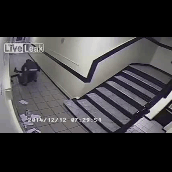

In [30]:

def to_gif(images,path = './animation.gif' ):
  converted_images = np.clip(images * 244, 0, 244).astype(np.uint8)
  imageio.mimsave(path, converted_images, fps=5)
  return embed.embed_file(path)


to_gif(sample_video)

In [31]:
class FrameGenerator:
    def __init__(self, path, n_frames, resolution,  training = False):
        """ Returns a set of frames with their associated label.

          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

        print(f'\nLabels for {path}:')
        print("Class names:", self.class_names)
        print("Class id:", self.class_ids_for_name)

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
    
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
          random.shuffle(pairs)

        for path, name in pairs:
          video_frames = frames_from_video_file(path, self.n_frames, output_size = (resolution, resolution))
          label = self.class_ids_for_name[name] # Encode labels
          yield video_frames, label

<br>
First, It's important to ensure that the data is labeled correctly in each data set.

In [32]:
from pathlib import PosixPath

def create_sets(batch_size, num_frames, resolution, subset_paths):

    print('Resolution', resolution)
    print('Batch_size', batch_size)
    print('Num Frames', num_frames)
          
    'CLASSES'
    CLASSES = sorted(os.listdir('./final_data/train/'))
    print("\nClasses identified by the directories:", CLASSES)
    
    
    output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                        tf.TensorSpec(shape = (), dtype = tf.int16))
    
    train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, resolution, training = True),
                                              output_signature = output_signature)
    
    val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames, resolution), 
                                             output_signature = output_signature)
    
    test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames, resolution),
                                             output_signature = output_signature)


    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    test_ds = test_ds.batch(batch_size)

    print('\n-Final shape of the datasets:')
    train_frames, train_labels = next(iter(train_ds))
    print(f'Shape of training set of frames: {train_frames.shape}')
    print(f'Shape of training labels: {train_labels.shape}')
    
    val_frames, val_labels = next(iter(val_ds))
    print(f'Shape of validation set of frames: {val_frames.shape}')
    print(f'Shape of validation labels: {val_labels.shape}')
    
    test_frames, test_labels = next(iter(test_ds))
    print(f'Shape of testing set of frames: {test_frames.shape}')
    print(f'Shape of testing labels: {test_labels.shape}')

    return train_ds, val_ds, test_ds

resolution = 224
subset_paths = {'train': PosixPath('./final_data/train/'), 'val': PosixPath('./final_data/val/'), 'test': PosixPath('./final_data/test/')}

train_ds_TEST, val_ds_TEST, test_TEST = create_sets(batch_size = 8, num_frames = 5, resolution = resolution, subset_paths = subset_paths)

Resolution 224
Batch_size 8
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (8, 5, 224, 224, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 5, 224, 224, 3)
Shape of validation labels: (8,)
Shape of testing set of frames: (8, 5, 224, 224, 3)
Shape of testing labels: (8,)


Its important to check that the dataset has been sufficiently shuffled by the _training = True_ option in the FrameGenerator function.


In [33]:
print('Checking if trainig data is shuffled')
for frames, labels in train_ds_TEST.take(5):
  print(labels)


Checking if trainig data is shuffled
tf.Tensor([0 0 1 0 0 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 1 1 0 0 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 1 1 1 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([0 1 1 1 0 1 0 0], shape=(8,), dtype=int16)
tf.Tensor([0 1 0 0 1 0 0 0], shape=(8,), dtype=int16)


# Building the Model

#### Evaluation functions

In [34]:
def get_actual_predicted_labels(model, dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]

  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [35]:
def plot_confusion_matrix(actual, predicted, labels, ds_type, model_id, num_frames, batch_size, learning_rate, dropout_rate, trainable_layers,dataset):
    cm = tf.math.confusion_matrix(actual, predicted)
    plt.figure(figsize=(8, 6)), 
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion matrix of Violence recognition for test ' + model_id)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.tight_layout()

    # Save the plot to a file
    output_dir = f'./conf_matrix__dropout_autolr_trlayers{dataset}/{model_id}_{num_frames}fps_{batch_size}bs_{learning_rate}lr_confusion_{dropout_rate}dr_{trainable_layers}tl'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, f'{ds_type}_confusion_matrix.png'))
    plt.close()
    print(f'Confusion matrix saved in: {output_dir}')
    return output_dir

In [36]:
import os
import csv
def plot_and_save_history(history, model_id, num_frames, batch_size, learning_rate, dropout_rate, trainable_layers, dataset):
    """
    Plots, saves the training history graphs, and stores history data in a CSV file.

    Args:
        history (History): Keras History object from the fit method.
        model_id (str): Identifier for the model.
        num_frames (int): Number of frames per video clip.
        batch_size (int): Batch size used during training.
        learning_rate (float): Learning rate used during training.
        dropout_rate (float): Dropout rate of the model.
        trainable_layers (int or None): Number of trainable layers.
    """
    # Extracting history data
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)

    # Plotting training and validation loss and accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Directory and file path setup
    output_dir = f'./train_data_dropout_autolr_trlayers{dataset}/training_plots_{model_id}_{num_frames}fps_{batch_size}bs_{learning_rate}lr_{dropout_rate}dr_{trainable_layers}tl'
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plot_file = os.path.join(output_dir, 'training_validation_performance.png')
    csv_file_path = os.path.join(output_dir, 'training_history.csv')

    # Save the plot
    plt.savefig(plot_file)
    plt.close()
    print(f'Training and validation performance plots saved in: {output_dir}')

    # Writing history data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
        for i in range(len(loss)):
            writer.writerow([i+1, loss[i], val_loss[i], accuracy[i], val_accuracy[i]])
    print(f'Training history data saved in CSV format in: {csv_file_path}')

In [37]:
from sklearn.metrics import roc_auc_score

def calculate_classification_metrics(y_actual, y_pred, labels, test_loss, test_accuracy, output_file_path):
    """
    Calculates, prints, and logs precision, recall, F1-score, AUC-ROC, and test accuracy for a classification model.

    Args:
        y_actual (list): Ground truth labels.
        y_pred (list): Predicted probabilities (for AUC-ROC).
        labels (list): List of classification labels.
        test_accuracy (float): Accuracy of the model on the test dataset.
        output_file_path (str): Path to the output text file to write the metrics.

    Returns:
        dict: A dictionary containing precision, recall, F1-score, AUC values, and test accuracy.
    """
    cm = tf.math.confusion_matrix(y_actual, np.round(y_pred))  # Round predictions for binary classification
    tp = np.diag(cm)  # True positives are on the diagonal
    precision = dict()
    recall = dict()
    f1 = dict()

    for i, label in enumerate(labels):
        col = cm[:, i]
        fp = np.sum(col) - tp[i]  # False positives
        row = cm[i, :]
        fn = np.sum(row) - tp[i]  # False negatives

        precision[label] = tp[i] / (tp[i] + fp) if (tp[i] + fp) > 0 else 0
        recall[label] = tp[i] / (tp[i] + fn) if (tp[i] + fn) > 0 else 0
        beta = 1.0  # F1-score
        f1[label] = (
            (1 + beta**2) * precision[label] * recall[label]
            / ((beta**2) * precision[label] + recall[label])
            if (precision[label] + recall[label]) > 0
            else 0
        )

    # Calculate AUC-ROC
    auc = roc_auc_score(y_actual, y_pred)

    # Prepare the text to both print and write to file
    output_lines = [
        "Performance Metrics:",
        "{:<15} {:>15} {:>15} {:>15} {:>15}".format("Label", "Precision", "Recall", "F1-Score", "AUC-ROC"),
        "-" * 70
    ]

    for label, prec in precision.items():
        rec = recall[label]
        f1_score = f1[label]
        output_lines.append("{:<15} {:>15.4f} {:>15.4f} {:>15.4f} {:>15.4f}".format(label, prec, rec, f1_score, auc))

    output_lines.append(f"Test Accuracy: {test_accuracy:.4f}")

    # Print and write to file
    output_file_path = os.path.join(output_file_path, 'classification_metrics.txt')
    
    with open(output_file_path, 'w') as file:
        for line in output_lines:
            print(line)
            file.write(line + '\n')

    return precision, recall, f1, auc


## Transfer-Learning

In [38]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


#### Building Frezeed Model

In [39]:
def build_model(model_id, resolution, trainable_layers=0):
    """
    Builds a Movinet classifier model with the specified model ID and resolution.

    Args:
        model_id (str): The ID of the Movinet model to be built.
        resolution (int): The resolution of the input images. It determines the spatial dimensions
            of the input frames (generally 224).

    Returns:
        tuple: A tuple containing the built Movinet classifier model and its backbone.
            The model is ready to be trained or used for inference.

    Raises:
        FileNotFoundError: If the pretrained weights for the specified model ID cannot be downloaded.
            This could happen if the model ID is incorrect or if there are issues with internet connectivity.
    """
    
    #1-Construct the backbone with proper parameters

    use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
    
    backbone = movinet.Movinet(
        model_id=model_id,
        causal=True,
        conv_type='2plus1d', #2plus1d
        se_type='2plus3d',
        activation='hard_swish',
        gating_activation='hard_sigmoid',
        use_positional_encoding=use_positional_encoding,
        use_external_states=False,
    )

    # Set the entire model as non-trainable if specific layers are set to be trainable
    backbone.trainable = False
    
    if trainable_layers != 0:
        # Make the last `trainable_layers` layers trainable
        for layer in backbone.layers[-trainable_layers:]:
            layer.trainable = True
            print(f"\nTraining layer: {layer}...")

    model = movinet_model.MovinetClassifier(
        backbone,
        num_classes=600,
        output_states=True
    )

    
    #2- Construct the model

    # Note: this is a temporary model constructed for the
    # purpose of loading the pre-trained checkpoint. Only
    # the backbone will be used to build the custom classifier.
    
    # Create example input
    inputs = tf.ones([1, 20, 224, 224, 3])
    
    # Build the model and load a pretrained checkpoint
    model.build(inputs.shape)

    
    #3-Load the pretrained weights

    # Download pretrained weights
    weights_dir = './old_weights/iw_model_id_stream'
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)

    if not os.path.exists(os.path.join(weights_dir, f"movinet_{model_id}_stream.tar.gz")):
        !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_{model_id}_stream.tar.gz -O {weights_dir}/movinet_{model_id}_stream.tar.gz -q -nc
        !tar -xvf {weights_dir}/movinet_{model_id}_stream.tar.gz -C {weights_dir}

    checkpoint_dir = f'{weights_dir}/movinet_{model_id}_stream'
    checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    
    if checkpoint_path is None:
        raise FileNotFoundError(f"Pretrained weights not found for model ID {model_id}")
    checkpoint = tf.train.Checkpoint(model=model)
    checkpoint = tf.train.Checkpoint(model=model)
    status = checkpoint.restore(checkpoint_path)
    status.assert_existing_objects_matched()
    
    return model, backbone



#### Building Classifier and Training Functions

In [40]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes, dropout_rate):
    """
    Builds a classifier on top of a backbone model using the functional API to handle multi-output scenarios.
    
    Args:
        batch_size (int): Batch size for training.
        num_frames (int): Number of frames per video clip.
        resolution (int): Resolution of input frames.
        backbone (tf.keras.Model): Pre-trained MoViNet model.
        num_classes (int): Number of classes for classification.
    """
    model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes,
      dropout_rate  = dropout_rate)
    
    model.build([batch_size, num_frames, resolution, resolution, 3])
    
    return model



def train( model_id, NUM_EPOCHS, resolution = 224, learning_rate = 0.0001, dropout_rate = 0.4, trainable_layers = 0, dataset = ''):
    """
      Trains a video classification model using a pre-trained MoViNet backbone.
    
      Args:
          model_id: String identifier for the model being trained.
          NUM_EPOCHS: Number of epochs to train the model for.
          resolution: Resolution (height and width) of the video frames.
    
      Returns:
          None.
    
      This function performs the following steps:
    
      1. Builds the model architecture:
          - Loads the pre-trained MoViNet backbone based on the specified model_id and resolution.
          - Constructs a classifier head on top of the backbone for the desired number of classes (2 in this case).
    
      2. Compiles the model:
          - Defines the loss function (Sparse Categorical Crossentropy)
          - Creates an Adam optimizer with a learning rate of 0.001
          - Compiles the model with the chosen loss, optimizer, and accuracy metric.
    
      3. Trains the model:
          - Prints a message indicating training start.
          - Defines the directory for saving trained models.
          - Sets up a callback to save the model weights only when validation accuracy improves (ModelCheckpoint).
          - Trains the model using the provided training dataset (train_ds) with validation data (val_ds) for NUM_EPOCHS.
          - Sets validation frequency to 1 epoch (validation happens after each epoch).
          - Enables verbose output for training progress.
    
      4. Evaluates the model:
          - Prints a message indicating model evaluation.
          - Evaluates the trained model on the test dataset (test_ds) and prints the results.
          - Calculates additional evaluation metrics like confusion matrix, precision, recall, F1-score, and AUC using custom functions 
          (get_actual_predicted_labels, plot_confusion_matrix, calculate_classification_metrics).
    
      5. Saves the weights of the best model for later streaming inference
    """

    # Construct loss, optimizer and compile the model
    with distribution_strategy.scope():
      model, backbone = build_model(model_id, resolution, trainable_layers)
      model = build_classifier(batch_size, num_frames, resolution, backbone, 2, dropout_rate)
      loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
      model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])
        

    '''**********************************************************'''
    
    print(f"\nTraining model {model_id}...")

    print(f'Manual Dropout and Automated Learning rate are implemented')
    print(f'RWF-2000, SCFD and Vioperu are the data selected')
    print(f'Training {trainable_layers} layers from the original model')
    print(f'\nNum epochs: {NUM_EPOCHS}')
    print(f'Batch Size: {batch_size}')
    print(f'Resolution: {resolution}')
    print(f'Num. Frames: {num_frames}')
    print(f'Learning Rate: {learning_rate}')
    print(f'Dropout Rate: {dropout_rate}\n')

    models_dir = f'./trained_models_dropout_autolr_trlayers{dataset}/'

    checkpoint_path = f'{models_dir}/movinet_{model_id}_{num_frames}fps_{batch_size}bs_{learning_rate}lr_{dropout_rate}dr_{trainable_layers}tl/movinet_{model_id}_stream_wbm'
    
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     monitor = 'val_accuracy',
                                                     mode = 'max',
                                                     save_best_only = True,
                                                     verbose=1)
    
    # Create a callback to reduce learning rate when validation loss plateaus
    lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                 factor=0.1,
                                                                 patience=2, #1 anteriormente
                                                                 min_lr=1e-7, #1e-6 anteriormente
                                                                 verbose=1)

    
    epochs = NUM_EPOCHS

    result = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=NUM_EPOCHS,
                        validation_freq=1,
                        verbose=1,
                        callbacks=[cp_callback, lr_scheduler_callback])


    
    plot_and_save_history(result, model_id, num_frames, batch_size, learning_rate, dropout_rate, trainable_layers,dataset)
    
    # Load the best weights onto the model
    model.load_weights(checkpoint_path)

    print(f"\nEvaluating model {model_id}...\n")

    test_loss, test_accuracy = model.evaluate(test_ds)

    print(f"\nOther evaluating metrics of the  {model_id} model \n")

    fg = FrameGenerator(subset_paths['train'], num_frames, resolution, training = True)
    label_names = list(fg.class_ids_for_name.keys())

    actual, predicted = get_actual_predicted_labels(model, test_ds)

    ouput_dir = plot_confusion_matrix(actual, predicted, label_names, 'test', model_id, num_frames, batch_size, learning_rate, dropout_rate, trainable_layers, dataset)
    
    p, r, f1, auc = calculate_classification_metrics(actual, predicted, label_names, test_loss, test_accuracy, ouput_dir) # Test dataset


    print(f"\nBest model {model_id} trained and saved!\n")

    print(f"****************************************************************")

    return model
    

# Training Models

### Model a0

#### Full dataset:  +Aug 

In [38]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data/train/'), 'val': PosixPath('./final_data/val/'), 'test': PosixPath('./final_data/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [432]:
a0_v0 = train( 'a0', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f954b023af0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f954b07afb0>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     69/Unknown - 256s 4s/step - loss: 0.5207 - accuracy: 0.7345
Epoch 1: val_accuracy improved from -inf to 0.77513, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
69/69 [==============================] - 301s 4s/step - loss: 0.5207 - accuracy: 0.7345 - val_loss: 0.5034 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 

[h264 @ 0x7f9c587283c0] mmco: unref short failure
[h264 @ 0x7f9c587283c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8227
Epoch 3: val_accuracy improved from 0.77513 to 0.79101, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
69/69 [==============================] - 285s 4s/step - loss: 0.3866 - accuracy: 0.8227 - val_loss: 0.4805 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 4/10
57/69 [=======================>......] - ETA: 43s - loss: 0.3845 - accuracy: 0.8328

[h264 @ 0x7f99201bb500] mmco: unref short failure
[h264 @ 0x7f99201bb500] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8272
Epoch 4: val_accuracy improved from 0.79101 to 0.80423, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
69/69 [==============================] - 285s 4s/step - loss: 0.3920 - accuracy: 0.8272 - val_loss: 0.4397 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 5/10
18/69 [======>.......................] - ETA: 3:12 - loss: 0.3334 - accuracy: 0.8472

[h264 @ 0x7f9b7cb54c40] mmco: unref short failure
[h264 @ 0x7f9b7cb54c40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8382
Epoch 5: val_accuracy did not improve from 0.80423
69/69 [==============================] - 288s 4s/step - loss: 0.3500 - accuracy: 0.8382 - val_loss: 0.5694 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 6/10
19/69 [=======>......................] - ETA: 2:55 - loss: 0.3917 - accuracy: 0.8322

[h264 @ 0x7fa1846ab900] mmco: unref short failure
[h264 @ 0x7fa1846ab900] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8346
Epoch 6: val_accuracy did not improve from 0.80423

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
69/69 [==============================] - 287s 4s/step - loss: 0.3568 - accuracy: 0.8346 - val_loss: 0.4682 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 7/10
37/69 [===============>..............] - ETA: 1:55 - loss: 0.2834 - accuracy: 0.8792

[h264 @ 0x7f9b31c9c2c0] mmco: unref short failure
[h264 @ 0x7f9b31c9c2c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8798
Epoch 7: val_accuracy did not improve from 0.80423
69/69 [==============================] - 286s 4s/step - loss: 0.2848 - accuracy: 0.8798 - val_loss: 0.4848 - val_accuracy: 0.7593 - lr: 2.0000e-04
Epoch 8/10
69/69 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8803
Epoch 8: val_accuracy did not improve from 0.80423

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
69/69 [==============================] - 286s 4s/step - loss: 0.2767 - accuracy: 0.8803 - val_loss: 0.5049 - val_accuracy: 0.7698 - lr: 2.0000e-04
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8825
Epoch 9: val_accuracy did not improve from 0.80423
69/69 [==============================] - 285s 4s/step - loss: 0.2724 - accuracy: 0.8825 - val_loss: 0.4772 - val_accuracy: 0.7910 - lr: 4.0000e-05
Epoch 10/10
17/69 [======>.......................] - ETA:

[h264 @ 0x7fa0ac11e100] mmco: unref short failure
[h264 @ 0x7fa0ac11e100] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.8935
Epoch 10: val_accuracy did not improve from 0.80423

Epoch 10: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
69/69 [==============================] - 287s 4s/step - loss: 0.2667 - accuracy: 0.8935 - val_loss: 0.4771 - val_accuracy: 0.7698 - lr: 4.0000e-05
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a0_5fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a0_5fps_32bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 38s 3s/step - loss: 0.5000 - accuracy: 0.7407

Other evaluating metrics of the  a0 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 44s 3s/step
Confusion matrix saved in: ./conf_matrix__

In [433]:
a0_v1 = train('a0', 10, resolution, learning_rate = 0.001, dropout_rate = 0.4, trainable_layers = 5)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8cfbc44580>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8cfbb73760>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8cfbd2e2c0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8cfbbef040>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f8cfbad4850>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 5 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.4

Epoch 1/10
     19/Unknown - 86s 4s/step - loss: 0.5594 - accuracy: 0.7319

[h264 @ 0x7f93b84f7ac0] mmco: unref short failure
[h264 @ 0x7f93b84f7ac0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 263s 4s/step - loss: 0.5173 - accuracy: 0.7527
Epoch 1: val_accuracy improved from -inf to 0.74339, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.001lr_0.4dr_5tl/movinet_a0_stream_wbm
69/69 [==============================] - 308s 4s/step - loss: 0.5173 - accuracy: 0.7527 - val_loss: 0.5174 - val_accuracy: 0.7434 - lr: 0.0010
Epoch 2/10
26/69 [==========>...................] - ETA: 2:32 - loss: 0.4243 - accuracy: 0.8125

[h264 @ 0x7f9744165800] mmco: unref short failure
[h264 @ 0x7f9744165800] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.7820
Epoch 2: val_accuracy improved from 0.74339 to 0.76455, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.001lr_0.4dr_5tl/movinet_a0_stream_wbm
69/69 [==============================] - 285s 4s/step - loss: 0.4562 - accuracy: 0.7820 - val_loss: 0.5210 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8016
Epoch 3: val_accuracy did not improve from 0.76455

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
69/69 [==============================] - 282s 4s/step - loss: 0.4286 - accuracy: 0.8016 - val_loss: 0.5964 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 4/10
27/69 [==========>...................] - ETA: 2:26 - loss: 0.4101 - accuracy: 0.8241

[h264 @ 0x7f938045e500] mmco: unref short failure
[h264 @ 0x7f938045e500] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8254
Epoch 4: val_accuracy improved from 0.76455 to 0.79101, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.001lr_0.4dr_5tl/movinet_a0_stream_wbm
69/69 [==============================] - 279s 4s/step - loss: 0.3870 - accuracy: 0.8254 - val_loss: 0.4951 - val_accuracy: 0.7910 - lr: 2.0000e-04
Epoch 5/10
69/69 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8391
Epoch 5: val_accuracy did not improve from 0.79101
69/69 [==============================] - 278s 4s/step - loss: 0.3718 - accuracy: 0.8391 - val_loss: 0.5070 - val_accuracy: 0.7646 - lr: 2.0000e-04
Epoch 6/10
45/69 [==================>...........] - ETA: 1:23 - loss: 0.3745 - accuracy: 0.8271

[h264 @ 0x7f9700011840] mmco: unref short failure
[h264 @ 0x7f9700011840] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8382
Epoch 6: val_accuracy did not improve from 0.79101

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
69/69 [==============================] - 281s 4s/step - loss: 0.3640 - accuracy: 0.8382 - val_loss: 0.5224 - val_accuracy: 0.7646 - lr: 2.0000e-04
Epoch 7/10
31/69 [============>.................] - ETA: 2:18 - loss: 0.3421 - accuracy: 0.8448

[h264 @ 0x7f98806a3300] mmco: unref short failure
[h264 @ 0x7f98806a3300] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.8364
Epoch 7: val_accuracy did not improve from 0.79101
69/69 [==============================] - 287s 4s/step - loss: 0.3538 - accuracy: 0.8364 - val_loss: 0.4859 - val_accuracy: 0.7884 - lr: 4.0000e-05
Epoch 8/10
39/69 [===============>..............] - ETA: 1:42 - loss: 0.3324 - accuracy: 0.8582

[h264 @ 0x7f96b44787c0] mmco: unref short failure
[h264 @ 0x7f96b44787c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.8451
Epoch 8: val_accuracy did not improve from 0.79101
69/69 [==============================] - 281s 4s/step - loss: 0.3488 - accuracy: 0.8451 - val_loss: 0.5031 - val_accuracy: 0.7725 - lr: 4.0000e-05
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.8304
Epoch 9: val_accuracy did not improve from 0.79101

Epoch 9: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
69/69 [==============================] - 285s 4s/step - loss: 0.3569 - accuracy: 0.8304 - val_loss: 0.4880 - val_accuracy: 0.7751 - lr: 4.0000e-05
Epoch 10/10
69/69 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8432
Epoch 10: val_accuracy did not improve from 0.79101
69/69 [==============================] - 286s 4s/step - loss: 0.3542 - accuracy: 0.8432 - val_loss: 0.5019 - val_accuracy: 0.7778 - lr: 8.0000e-06
Training and validation performance plots saved in: ./tr

In [466]:

a0_v2 = train('a0', 20, resolution, learning_rate = 0.01, dropout_rate = 0.2, trainable_layers = 5)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f9699d9c9d0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f9699d644c0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f9699c6b0a0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f9699ba9750>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f9699bf9780>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 5 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 20
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.01
Dropout Rate: 0.2

Epoch 1/20
     69/Unknown - 262s 4s/step - loss: 0.7047 - accuracy: 0.7061
Epoch 1: val_accuracy improved from -inf to 0.65344, saving model to ./tr

[h264 @ 0x7f947c06d540] mmco: unref short failure
[h264 @ 0x7f947c06d540] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.5176 - accuracy: 0.7623
Epoch 2: val_accuracy improved from 0.65344 to 0.70370, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.01lr_0.2dr_5tl/movinet_a0_stream_wbm
69/69 [==============================] - 283s 4s/step - loss: 0.5176 - accuracy: 0.7623 - val_loss: 0.6508 - val_accuracy: 0.7037 - lr: 0.0100
Epoch 3/20
56/69 [=======================>......] - ETA: 47s - loss: 0.4393 - accuracy: 0.8136

[h264 @ 0x7f963c030100] mmco: unref short failure
[h264 @ 0x7f963c030100] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.8030
Epoch 3: val_accuracy improved from 0.70370 to 0.73016, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.01lr_0.2dr_5tl/movinet_a0_stream_wbm
69/69 [==============================] - 284s 4s/step - loss: 0.4618 - accuracy: 0.8030 - val_loss: 0.6185 - val_accuracy: 0.7302 - lr: 0.0100
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8259
Epoch 4: val_accuracy did not improve from 0.73016
69/69 [==============================] - 282s 4s/step - loss: 0.3844 - accuracy: 0.8259 - val_loss: 0.8360 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 5/20
34/69 [=============>................] - ETA: 1:59 - loss: 0.3620 - accuracy: 0.8603

[h264 @ 0x7f98c0236440] mmco: unref short failure
[h264 @ 0x7f98c0236440] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.8423
Epoch 5: val_accuracy did not improve from 0.73016

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
69/69 [==============================] - 283s 4s/step - loss: 0.3817 - accuracy: 0.8423 - val_loss: 0.7849 - val_accuracy: 0.7275 - lr: 0.0100
Epoch 6/20
69/69 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.8839
Epoch 6: val_accuracy did not improve from 0.73016
69/69 [==============================] - 282s 4s/step - loss: 0.2751 - accuracy: 0.8839 - val_loss: 0.6836 - val_accuracy: 0.7222 - lr: 1.0000e-03
Epoch 7/20
69/69 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9059
Epoch 7: val_accuracy improved from 0.73016 to 0.75397, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.01lr_0.2dr_5tl/movinet_a0_stream_wbm

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
69/69 [==

[h264 @ 0x7f98d0388b80] mmco: unref short failure
[h264 @ 0x7f98d0388b80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.9177
Epoch 9: val_accuracy did not improve from 0.75397

Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
69/69 [==============================] - 282s 4s/step - loss: 0.2043 - accuracy: 0.9177 - val_loss: 0.7036 - val_accuracy: 0.7487 - lr: 1.0000e-04
Epoch 10/20
69/69 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9241
Epoch 10: val_accuracy improved from 0.75397 to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.01lr_0.2dr_5tl/movinet_a0_stream_wbm
69/69 [==============================] - 278s 4s/step - loss: 0.1933 - accuracy: 0.9241 - val_loss: 0.6583 - val_accuracy: 0.7593 - lr: 1.0000e-05
Epoch 11/20
28/69 [===========>..................] - ETA: 2:23 - loss: 0.2379 - accuracy: 0.9029

[h264 @ 0x7f9458a77fc0] mmco: unref short failure
[h264 @ 0x7f9458a77fc0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9164
Epoch 11: val_accuracy did not improve from 0.75926

Epoch 11: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
69/69 [==============================] - 279s 4s/step - loss: 0.2130 - accuracy: 0.9164 - val_loss: 0.6656 - val_accuracy: 0.7407 - lr: 1.0000e-05
Epoch 12/20
69/69 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9200
Epoch 12: val_accuracy did not improve from 0.75926
69/69 [==============================] - 290s 4s/step - loss: 0.2066 - accuracy: 0.9200 - val_loss: 0.6689 - val_accuracy: 0.7143 - lr: 1.0000e-06
Epoch 13/20
28/69 [===========>..................] - ETA: 2:28 - loss: 0.1783 - accuracy: 0.9330

[h264 @ 0x7f9740083b00] mmco: unref short failure
[h264 @ 0x7f9740083b00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.9200
Epoch 13: val_accuracy did not improve from 0.75926

Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.
69/69 [==============================] - 287s 4s/step - loss: 0.1995 - accuracy: 0.9200 - val_loss: 0.6359 - val_accuracy: 0.7407 - lr: 1.0000e-06
Epoch 14/20
 1/69 [..............................] - ETA: 4:08 - loss: 0.1202 - accuracy: 0.9688

[h264 @ 0x7f95b02fb080] mmco: unref short failure
[h264 @ 0x7f95b02fb080] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9145
Epoch 14: val_accuracy did not improve from 0.75926
69/69 [==============================] - 286s 4s/step - loss: 0.2102 - accuracy: 0.9145 - val_loss: 0.6801 - val_accuracy: 0.7407 - lr: 1.0000e-07
Epoch 15/20
69/69 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9127
Epoch 15: val_accuracy did not improve from 0.75926
69/69 [==============================] - 287s 4s/step - loss: 0.2104 - accuracy: 0.9127 - val_loss: 0.7090 - val_accuracy: 0.7381 - lr: 1.0000e-07
Epoch 16/20
40/69 [================>.............] - ETA: 1:42 - loss: 0.2099 - accuracy: 0.9133

[h264 @ 0x7f9348006380] mmco: unref short failure
[h264 @ 0x7f9348006380] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9191
Epoch 16: val_accuracy did not improve from 0.75926
69/69 [==============================] - 287s 4s/step - loss: 0.2104 - accuracy: 0.9191 - val_loss: 0.6728 - val_accuracy: 0.7196 - lr: 1.0000e-07
Epoch 17/20
69/69 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9269
Epoch 17: val_accuracy did not improve from 0.75926
69/69 [==============================] - 286s 4s/step - loss: 0.1949 - accuracy: 0.9269 - val_loss: 0.7003 - val_accuracy: 0.7407 - lr: 1.0000e-07
Epoch 18/20
69/69 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.9237
Epoch 18: val_accuracy did not improve from 0.75926
69/69 [==============================] - 286s 4s/step - loss: 0.2019 - accuracy: 0.9237 - val_loss: 0.6640 - val_accuracy: 0.7513 - lr: 1.0000e-07
Epoch 19/20
12/69 [====>.........................] - ETA: 3:22 - loss: 0.2196 - accuracy: 0.9141

[h264 @ 0x7f97fd62cb80] mmco: unref short failure
[h264 @ 0x7f97fd62cb80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9228
Epoch 19: val_accuracy did not improve from 0.75926
69/69 [==============================] - 288s 4s/step - loss: 0.1998 - accuracy: 0.9228 - val_loss: 0.7032 - val_accuracy: 0.7249 - lr: 1.0000e-07
Epoch 20/20
64/69 [==========================>...] - ETA: 18s - loss: 0.2055 - accuracy: 0.9277

[h264 @ 0x7f9a740f0b80] mmco: unref short failure
[h264 @ 0x7f9a740f0b80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9269
Epoch 20: val_accuracy did not improve from 0.75926
69/69 [==============================] - 290s 4s/step - loss: 0.2057 - accuracy: 0.9269 - val_loss: 0.6694 - val_accuracy: 0.7381 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a0_5fps_32bs_0.01lr_0.2dr_5tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a0_5fps_32bs_0.01lr_0.2dr_5tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 39s 3s/step - loss: 0.5779 - accuracy: 0.7619

Other evaluating metrics of the  a0 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 44s 3s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers/a0_5fps_32bs_0.01lr_confusion_0.2dr_5tl
Performance Metr

In [467]:
a0_v3 = train('a0', 20, resolution, learning_rate = 0.01, dropout_rate = 0.4, trainable_layers = 2) 


Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f949a8a3100>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f949a780910>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 20
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.01
Dropout Rate: 0.4

Epoch 1/20
      2/Unknown - 21s 4s/step - loss: 0.8006 - accuracy: 0.5938 

[h264 @ 0x7f9709912140] mmco: unref short failure
[h264 @ 0x7f9709912140] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 257s 4s/step - loss: 0.8165 - accuracy: 0.6997
Epoch 1: val_accuracy improved from -inf to 0.78307, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a0_5fps_32bs_0.01lr_0.4dr_2tl/movinet_a0_stream_wbm
69/69 [==============================] - 303s 4s/step - loss: 0.8165 - accuracy: 0.6997 - val_loss: 0.4887 - val_accuracy: 0.7831 - lr: 0.0100
Epoch 2/20
60/69 [=========================>....] - ETA: 32s - loss: 0.5496 - accuracy: 0.7656

[h264 @ 0x7f973c00cc00] mmco: unref short failure
[h264 @ 0x7f973c00cc00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7660
Epoch 2: val_accuracy did not improve from 0.78307
69/69 [==============================] - 284s 4s/step - loss: 0.5465 - accuracy: 0.7660 - val_loss: 0.5392 - val_accuracy: 0.7487 - lr: 0.0100
Epoch 3/20
24/69 [=========>....................] - ETA: 2:41 - loss: 0.4361 - accuracy: 0.8047

[h264 @ 0x7f98d40396c0] mmco: unref short failure
[h264 @ 0x7f98d40396c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.7939
Epoch 3: val_accuracy did not improve from 0.78307

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
69/69 [==============================] - 284s 4s/step - loss: 0.4720 - accuracy: 0.7939 - val_loss: 0.7209 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 4/20
59/69 [========================>.....] - ETA: 35s - loss: 0.3515 - accuracy: 0.8432

[h264 @ 0x7f9494171f80] mmco: unref short failure
[h264 @ 0x7f9494171f80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8387
Epoch 4: val_accuracy did not improve from 0.78307
69/69 [==============================] - 283s 4s/step - loss: 0.3553 - accuracy: 0.8387 - val_loss: 0.5557 - val_accuracy: 0.7540 - lr: 1.0000e-03
Epoch 5/20
69/69 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8693
Epoch 5: val_accuracy did not improve from 0.78307

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
69/69 [==============================] - 286s 4s/step - loss: 0.3090 - accuracy: 0.8693 - val_loss: 0.4954 - val_accuracy: 0.7804 - lr: 1.0000e-03
Epoch 6/20
 4/69 [>.............................] - ETA: 3:47 - loss: 0.2451 - accuracy: 0.9141

[h264 @ 0x7f9371aa7b40] mmco: unref short failure
[h264 @ 0x7f9371aa7b40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8894
Epoch 6: val_accuracy did not improve from 0.78307
69/69 [==============================] - 287s 4s/step - loss: 0.2856 - accuracy: 0.8894 - val_loss: 0.5199 - val_accuracy: 0.7698 - lr: 1.0000e-04
Epoch 7/20
69/69 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.8821
Epoch 7: val_accuracy did not improve from 0.78307

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
69/69 [==============================] - 287s 4s/step - loss: 0.2750 - accuracy: 0.8821 - val_loss: 0.5324 - val_accuracy: 0.7487 - lr: 1.0000e-04
Epoch 8/20
42/69 [=================>............] - ETA: 1:35 - loss: 0.2741 - accuracy: 0.8914

[h264 @ 0x7f9910588800] mmco: unref short failure
[h264 @ 0x7f9910588800] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.8921
Epoch 8: val_accuracy did not improve from 0.78307
69/69 [==============================] - 282s 4s/step - loss: 0.2681 - accuracy: 0.8921 - val_loss: 0.5247 - val_accuracy: 0.7566 - lr: 1.0000e-05
Epoch 9/20
69/69 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.8894
Epoch 9: val_accuracy did not improve from 0.78307

Epoch 9: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
69/69 [==============================] - 279s 4s/step - loss: 0.2711 - accuracy: 0.8894 - val_loss: 0.5238 - val_accuracy: 0.7434 - lr: 1.0000e-05
Epoch 10/20
69/69 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.8867
Epoch 10: val_accuracy did not improve from 0.78307
69/69 [==============================] - 283s 4s/step - loss: 0.2692 - accuracy: 0.8867 - val_loss: 0.5028 - val_accuracy: 0.7513 - lr: 1.0000e-06
Epoch 11/20
69/69 [==============================] - ETA:

[h264 @ 0x7f96e4035e00] mmco: unref short failure
[h264 @ 0x7f96e4035e00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.8862
Epoch 14: val_accuracy did not improve from 0.78307
69/69 [==============================] - 281s 4s/step - loss: 0.2653 - accuracy: 0.8862 - val_loss: 0.5211 - val_accuracy: 0.7540 - lr: 1.0000e-07
Epoch 15/20
 7/69 [==>...........................] - ETA: 3:41 - loss: 0.2740 - accuracy: 0.9018

[h264 @ 0x7f9570010280] mmco: unref short failure
[h264 @ 0x7f9570010280] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.8926
Epoch 15: val_accuracy did not improve from 0.78307
69/69 [==============================] - 287s 4s/step - loss: 0.2655 - accuracy: 0.8926 - val_loss: 0.5160 - val_accuracy: 0.7540 - lr: 1.0000e-07
Epoch 16/20
62/69 [=========================>....] - ETA: 25s - loss: 0.2635 - accuracy: 0.9012

[h264 @ 0x7f97080160c0] mmco: unref short failure
[h264 @ 0x7f97080160c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.8958
Epoch 16: val_accuracy did not improve from 0.78307
69/69 [==============================] - 286s 4s/step - loss: 0.2709 - accuracy: 0.8958 - val_loss: 0.5290 - val_accuracy: 0.7487 - lr: 1.0000e-07
Epoch 17/20
28/69 [===========>..................] - ETA: 2:32 - loss: 0.2748 - accuracy: 0.8895

[h264 @ 0x7f96f0346e00] mmco: unref short failure
[h264 @ 0x7f96f0346e00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.8853
Epoch 17: val_accuracy did not improve from 0.78307
69/69 [==============================] - 287s 4s/step - loss: 0.2748 - accuracy: 0.8853 - val_loss: 0.5441 - val_accuracy: 0.7381 - lr: 1.0000e-07
Epoch 18/20
69/69 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.8766
Epoch 18: val_accuracy did not improve from 0.78307
69/69 [==============================] - 286s 4s/step - loss: 0.2798 - accuracy: 0.8766 - val_loss: 0.5488 - val_accuracy: 0.7407 - lr: 1.0000e-07
Epoch 19/20
69/69 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.8803
Epoch 19: val_accuracy did not improve from 0.78307
69/69 [==============================] - 279s 4s/step - loss: 0.2697 - accuracy: 0.8803 - val_loss: 0.5461 - val_accuracy: 0.7566 - lr: 1.0000e-07
Epoch 20/20
54/69 [======================>.......] - ETA: 52s - loss: 0.2585 - accuracy: 0.8831

[h264 @ 0x7f97c0035440] mmco: unref short failure
[h264 @ 0x7f97c0035440] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.8848
Epoch 20: val_accuracy did not improve from 0.78307
69/69 [==============================] - 282s 4s/step - loss: 0.2646 - accuracy: 0.8848 - val_loss: 0.5202 - val_accuracy: 0.7646 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a0_5fps_32bs_0.01lr_0.4dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a0_5fps_32bs_0.01lr_0.4dr_2tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 40s 3s/step - loss: 0.5528 - accuracy: 0.7381

Other evaluating metrics of the  a0 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 45s 3s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers/a0_5fps_32bs_0.01lr_confusion_0.4dr_2tl
Performance Metr

#### NoVioPeru

In [118]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data_NoVioPeru/train/'), 'val': PosixPath('./final_data_NoVioPeru/val/'), 'test': PosixPath('./final_data_NoVioPeru/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoVioPeru = '_NoVioPeru'

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoVioPeru/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoVioPeru/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoVioPeru/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [119]:
a0_NoVio_v0 = train( 'a0', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoVioPeru)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe66ca573d0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fe66c7fa230>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     60/Unknown - 227s 4s/step - loss: 0.4899 - accuracy: 0.7635
Epoch 1: val_accuracy improved from -inf to 0.75714, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
60/60 [==============================] - 267s 4s/step - loss: 0.4899 - accuracy: 0.7635 - val_loss: 0.5788 - val_accuracy: 0.7571 - lr: 0.0010
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.4075 - 

2024-04-29 00:00:27.848201: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


60/60 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.8969
Epoch 9: val_accuracy improved from 0.76000 to 0.76857, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
60/60 [==============================] - 239s 4s/step - loss: 0.2446 - accuracy: 0.8969 - val_loss: 0.5352 - val_accuracy: 0.7686 - lr: 1.0000e-04
Epoch 10/10
60/60 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9052
Epoch 10: val_accuracy did not improve from 0.76857
60/60 [==============================] - 236s 4s/step - loss: 0.2302 - accuracy: 0.9052 - val_loss: 0.5333 - val_accuracy: 0.7629 - lr: 1.0000e-05
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_a

In [127]:
a0_NoVio_v1 = train('a0', 15, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 3, dataset = NoVioPeru)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe639ef0c70>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe60f0e66e0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fe668549ed0>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/15
     23/Unknown - 96s 4s/step - loss: 0.5859 - accuracy: 0.7038

[h264 @ 0x7fefc0034e40] mmco: unref short failure
[h264 @ 0x7fefc0034e40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 225s 4s/step - loss: 0.5185 - accuracy: 0.7500
Epoch 1: val_accuracy improved from -inf to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a0_stream_wbm
57/57 [==============================] - 270s 5s/step - loss: 0.5185 - accuracy: 0.7500 - val_loss: 0.5382 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/15
49/57 [========================>.....] - ETA: 29s - loss: 0.4309 - accuracy: 0.7985

[h264 @ 0x7ff2289bf300] mmco: unref short failure
[h264 @ 0x7ff2289bf300] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.8026
Epoch 2: val_accuracy improved from 0.75926 to 0.76455, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a0_stream_wbm
57/57 [==============================] - 250s 4s/step - loss: 0.4278 - accuracy: 0.8026 - val_loss: 0.5197 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 3/15
39/57 [===================>..........] - ETA: 1:06 - loss: 0.3868 - accuracy: 0.8157

[h264 @ 0x7fe94004f540] mmco: unref short failure
[h264 @ 0x7fe94004f540] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8065
Epoch 3: val_accuracy did not improve from 0.76455
57/57 [==============================] - 250s 4s/step - loss: 0.4042 - accuracy: 0.8065 - val_loss: 0.5189 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 4/15
52/57 [==========================>...] - ETA: 18s - loss: 0.3668 - accuracy: 0.8359

[h264 @ 0x7febba036300] mmco: unref short failure
[h264 @ 0x7febba036300] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8383
Epoch 4: val_accuracy did not improve from 0.76455
57/57 [==============================] - 252s 4s/step - loss: 0.3640 - accuracy: 0.8383 - val_loss: 0.7417 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 5/15
50/57 [=========================>....] - ETA: 25s - loss: 0.3557 - accuracy: 0.8462

[h264 @ 0x7feeb062bf00] mmco: unref short failure
[h264 @ 0x7feeb062bf00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8465
Epoch 5: val_accuracy improved from 0.76455 to 0.78042, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a0_stream_wbm
57/57 [==============================] - 251s 4s/step - loss: 0.3549 - accuracy: 0.8465 - val_loss: 0.5053 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 6/15
26/57 [============>.................] - ETA: 1:56 - loss: 0.3205 - accuracy: 0.8546

[h264 @ 0x7ff159535e80] mmco: unref short failure
[h264 @ 0x7ff159535e80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.8443
Epoch 6: val_accuracy did not improve from 0.78042
57/57 [==============================] - 250s 4s/step - loss: 0.3316 - accuracy: 0.8443 - val_loss: 0.6173 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 7/15
36/57 [=================>............] - ETA: 1:18 - loss: 0.3102 - accuracy: 0.8602

[h264 @ 0x7ff3c8d06d80] mmco: unref short failure
[h264 @ 0x7ff3c8d06d80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.8635
Epoch 7: val_accuracy did not improve from 0.78042

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 251s 4s/step - loss: 0.3154 - accuracy: 0.8635 - val_loss: 0.5279 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 8/15
57/57 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.8854
Epoch 8: val_accuracy improved from 0.78042 to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a0_stream_wbm
57/57 [==============================] - 252s 4s/step - loss: 0.2708 - accuracy: 0.8854 - val_loss: 0.5079 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 9/15
 8/57 [===>..........................] - ETA: 2:53 - loss: 0.2405 - accuracy: 0.9062

[h264 @ 0x7feda02a3e00] mmco: unref short failure
[h264 @ 0x7feda02a3e00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2545 - accuracy: 0.8991
Epoch 9: val_accuracy did not improve from 0.78836

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 250s 4s/step - loss: 0.2545 - accuracy: 0.8991 - val_loss: 0.5465 - val_accuracy: 0.7646 - lr: 1.0000e-04
Epoch 10/15
11/57 [====>.........................] - ETA: 2:59 - loss: 0.2481 - accuracy: 0.9148

[h264 @ 0x7fea80095340] mmco: unref short failure
[h264 @ 0x7fea80095340] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.8975
Epoch 10: val_accuracy did not improve from 0.78836
57/57 [==============================] - 253s 4s/step - loss: 0.2496 - accuracy: 0.8975 - val_loss: 0.5152 - val_accuracy: 0.7646 - lr: 1.0000e-05
Epoch 11/15
10/57 [====>.........................] - ETA: 2:58 - loss: 0.2259 - accuracy: 0.9250

[h264 @ 0x7fed94316d00] mmco: unref short failure
[h264 @ 0x7fed94316d00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8964
Epoch 11: val_accuracy did not improve from 0.78836

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 252s 4s/step - loss: 0.2577 - accuracy: 0.8964 - val_loss: 0.5295 - val_accuracy: 0.7593 - lr: 1.0000e-05
Epoch 12/15
57/57 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9073
Epoch 12: val_accuracy did not improve from 0.78836
57/57 [==============================] - 253s 4s/step - loss: 0.2444 - accuracy: 0.9073 - val_loss: 0.5304 - val_accuracy: 0.7646 - lr: 1.0000e-06
Epoch 13/15
57/57 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.8980
Epoch 13: val_accuracy did not improve from 0.78836

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 255s 4s/step - loss: 0.2529 - accuracy: 0.8980 - val_loss: 0.5091 - val_accura

[h264 @ 0x7fefb4034e80] mmco: unref short failure
[h264 @ 0x7fefb4034e80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.8997
Epoch 14: val_accuracy did not improve from 0.78836
57/57 [==============================] - 255s 4s/step - loss: 0.2525 - accuracy: 0.8997 - val_loss: 0.5110 - val_accuracy: 0.7725 - lr: 1.0000e-07
Epoch 15/15
 1/57 [..............................] - ETA: 3:18 - loss: 0.2987 - accuracy: 0.8438

[h264 @ 0x7ff1d48ee080] mmco: unref short failure
[h264 @ 0x7ff1d48ee080] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9079
Epoch 15: val_accuracy did not improve from 0.78836

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 252s 4s/step - loss: 0.2369 - accuracy: 0.9079 - val_loss: 0.5291 - val_accuracy: 0.7566 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.2dr_3tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.2dr_3tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 38s 3s/step - loss: 0.5824 - accuracy: 0.7487

Other evaluating metrics of the  a0 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 44s 3s/step
Confusion matrix saved in: ./con

#### No Augmentated Data

In [41]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [122]:
a0_NoAug_v0 = train( 'a0', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fefe88ccfa0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fefa4727430>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     57/Unknown - 272s 5s/step - loss: 0.5157 - accuracy: 0.7505
Epoch 1: val_accuracy improved from -inf to 0.77249, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
57/57 [==============================] - 321s 5s/step - loss: 0.5157 - accuracy: 0.7505 - val_loss: 0.4542 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 2/10
 6/57 [==>...........................] - ETA: 3:24 - loss: 0.4585 - ac

[h264 @ 0x7fe964ee1080] mmco: unref short failure
[h264 @ 0x7fe964ee1080] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8032
Epoch 2: val_accuracy did not improve from 0.77249
57/57 [==============================] - 264s 5s/step - loss: 0.4253 - accuracy: 0.8032 - val_loss: 0.6343 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 3/10
38/57 [===================>..........] - ETA: 1:14 - loss: 0.3827 - accuracy: 0.8183

[h264 @ 0x7fee901c0e80] mmco: unref short failure
[h264 @ 0x7fee901c0e80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3942 - accuracy: 0.8185
Epoch 3: val_accuracy did not improve from 0.77249

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 259s 5s/step - loss: 0.3942 - accuracy: 0.8185 - val_loss: 0.5489 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 4/10
 2/57 [>.............................] - ETA: 3:35 - loss: 0.3565 - accuracy: 0.8594

[h264 @ 0x7fee69043d40] mmco: unref short failure
[h264 @ 0x7fee69043d40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8366
Epoch 4: val_accuracy did not improve from 0.77249
57/57 [==============================] - 256s 5s/step - loss: 0.3601 - accuracy: 0.8366 - val_loss: 0.4963 - val_accuracy: 0.7672 - lr: 1.0000e-04
Epoch 5/10
15/57 [======>.......................] - ETA: 2:46 - loss: 0.3253 - accuracy: 0.8479

[h264 @ 0x7fe9c802c800] mmco: unref short failure
[h264 @ 0x7fe9c802c800] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.8542
Epoch 5: val_accuracy did not improve from 0.77249

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 257s 5s/step - loss: 0.3353 - accuracy: 0.8542 - val_loss: 0.5004 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 6/10
57/57 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.8613
Epoch 6: val_accuracy improved from 0.77249 to 0.78042, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
57/57 [==============================] - 259s 5s/step - loss: 0.3268 - accuracy: 0.8613 - val_loss: 0.4783 - val_accuracy: 0.7804 - lr: 1.0000e-05
Epoch 7/10
31/57 [===============>..............] - ETA: 1:36 - loss: 0.3312 - accuracy: 0.8569

[h264 @ 0x7fed4c07ca80] mmco: unref short failure
[h264 @ 0x7fed4c07ca80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8542
Epoch 7: val_accuracy did not improve from 0.78042

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 252s 4s/step - loss: 0.3348 - accuracy: 0.8542 - val_loss: 0.5092 - val_accuracy: 0.7804 - lr: 1.0000e-05
Epoch 8/10
57/57 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8520
Epoch 8: val_accuracy did not improve from 0.78042
57/57 [==============================] - 251s 4s/step - loss: 0.3429 - accuracy: 0.8520 - val_loss: 0.5355 - val_accuracy: 0.7646 - lr: 1.0000e-06
Epoch 9/10
39/57 [===================>..........] - ETA: 1:06 - loss: 0.3185 - accuracy: 0.8558

[h264 @ 0x7fea24033b40] mmco: unref short failure
[h264 @ 0x7fea24033b40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8525
Epoch 9: val_accuracy did not improve from 0.78042

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 251s 4s/step - loss: 0.3241 - accuracy: 0.8525 - val_loss: 0.5038 - val_accuracy: 0.7804 - lr: 1.0000e-06
Epoch 10/10
 8/57 [===>..........................] - ETA: 3:03 - loss: 0.2920 - accuracy: 0.8789

[h264 @ 0x7fe8bc736d00] mmco: unref short failure
[h264 @ 0x7fe8bc736d00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3254 - accuracy: 0.8618
Epoch 10: val_accuracy improved from 0.78042 to 0.79894, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
57/57 [==============================] - 252s 4s/step - loss: 0.3254 - accuracy: 0.8618 - val_loss: 0.4850 - val_accuracy: 0.7989 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a0_5fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a0_5fps_32bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 44s 4s/step - loss: 0.5056 - accuracy: 0.7672

Other evaluating metrics of the  a0 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==================

In [126]:
a0_NoAug_v1 = train('a0', 15, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 3, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe66855dc00>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe66855ded0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fea895f0e20>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/15
     29/Unknown - 118s 4s/step - loss: 0.5117 - accuracy: 0.7511

[h264 @ 0x7fe92c00d900] mmco: unref short failure
[h264 @ 0x7fe92c00d900] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 224s 4s/step - loss: 0.5040 - accuracy: 0.7544
Epoch 1: val_accuracy improved from -inf to 0.75661, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a0_stream_wbm
57/57 [==============================] - 269s 5s/step - loss: 0.5040 - accuracy: 0.7544 - val_loss: 0.5507 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 2/15
53/57 [==========================>...] - ETA: 14s - loss: 0.4173 - accuracy: 0.8090

[h264 @ 0x7feccc1d83c0] mmco: unref short failure
[h264 @ 0x7feccc1d83c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8065
Epoch 2: val_accuracy did not improve from 0.75661
57/57 [==============================] - 250s 4s/step - loss: 0.4192 - accuracy: 0.8065 - val_loss: 0.6373 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 3/15
11/57 [====>.........................] - ETA: 2:53 - loss: 0.4202 - accuracy: 0.7983

[h264 @ 0x7feec487ee00] mmco: unref short failure
[h264 @ 0x7feec487ee00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8169
Epoch 3: val_accuracy improved from 0.75661 to 0.77249, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a0_stream_wbm
57/57 [==============================] - 251s 4s/step - loss: 0.4025 - accuracy: 0.8169 - val_loss: 0.5034 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 4/15
57/57 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8300
Epoch 4: val_accuracy did not improve from 0.77249
57/57 [==============================] - 250s 4s/step - loss: 0.3779 - accuracy: 0.8300 - val_loss: 0.5425 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 5/15
19/57 [=========>....................] - ETA: 2:42 - loss: 0.3451 - accuracy: 0.8635

[h264 @ 0x7ff440048ec0] mmco: unref short failure
[h264 @ 0x7ff440048ec0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8525
Epoch 5: val_accuracy did not improve from 0.77249

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 267s 5s/step - loss: 0.3500 - accuracy: 0.8525 - val_loss: 0.5438 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 6/15
57/57 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8717
Epoch 6: val_accuracy did not improve from 0.77249
57/57 [==============================] - 251s 4s/step - loss: 0.3066 - accuracy: 0.8717 - val_loss: 0.5186 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 7/15
31/57 [===============>..............] - ETA: 1:40 - loss: 0.2824 - accuracy: 0.8861

[h264 @ 0x7fed6062d8c0] mmco: unref short failure
[h264 @ 0x7fed6062d8c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.8761
Epoch 7: val_accuracy improved from 0.77249 to 0.77778, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a0_stream_wbm

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 253s 4s/step - loss: 0.2918 - accuracy: 0.8761 - val_loss: 0.5165 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 8/15
57/57 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8805
Epoch 8: val_accuracy did not improve from 0.77778
57/57 [==============================] - 257s 4s/step - loss: 0.2869 - accuracy: 0.8805 - val_loss: 0.5451 - val_accuracy: 0.7751 - lr: 1.0000e-05
Epoch 9/15
57/57 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.8745
Epoch 9: val_accuracy did not improve from 0.77778

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-

[h264 @ 0x7ff12c32f980] mmco: unref short failure
[h264 @ 0x7ff12c32f980] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.8843
Epoch 10: val_accuracy did not improve from 0.77778
57/57 [==============================] - 249s 4s/step - loss: 0.2902 - accuracy: 0.8843 - val_loss: 0.5543 - val_accuracy: 0.7540 - lr: 1.0000e-06
Epoch 11/15
13/57 [=====>........................] - ETA: 2:46 - loss: 0.2776 - accuracy: 0.8846

[h264 @ 0x7febf81f8000] mmco: unref short failure
[h264 @ 0x7febf81f8000] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8745
Epoch 11: val_accuracy did not improve from 0.77778

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 251s 4s/step - loss: 0.2953 - accuracy: 0.8745 - val_loss: 0.5406 - val_accuracy: 0.7698 - lr: 1.0000e-06
Epoch 12/15
57/57 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.8849
Epoch 12: val_accuracy did not improve from 0.77778
57/57 [==============================] - 251s 4s/step - loss: 0.2796 - accuracy: 0.8849 - val_loss: 0.5477 - val_accuracy: 0.7540 - lr: 1.0000e-07
Epoch 13/15
37/57 [==================>...........] - ETA: 1:14 - loss: 0.2918 - accuracy: 0.8742

[h264 @ 0x7ff1887c7100] mmco: unref short failure
[h264 @ 0x7ff1887c7100] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.8816
Epoch 13: val_accuracy did not improve from 0.77778

Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 254s 4s/step - loss: 0.2811 - accuracy: 0.8816 - val_loss: 0.5237 - val_accuracy: 0.7778 - lr: 1.0000e-07
Epoch 14/15
57/57 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8816
Epoch 14: val_accuracy did not improve from 0.77778
57/57 [==============================] - 253s 4s/step - loss: 0.2922 - accuracy: 0.8816 - val_loss: 0.5225 - val_accuracy: 0.7778 - lr: 1.0000e-07
Epoch 15/15
40/57 [====================>.........] - ETA: 1:03 - loss: 0.3108 - accuracy: 0.8656

[h264 @ 0x7feaa01f4800] mmco: unref short failure
[h264 @ 0x7feaa01f4800] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8712
Epoch 15: val_accuracy did not improve from 0.77778
57/57 [==============================] - 251s 4s/step - loss: 0.3001 - accuracy: 0.8712 - val_loss: 0.5223 - val_accuracy: 0.7672 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a0_5fps_32bs_0.001lr_0.2dr_3tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a0_5fps_32bs_0.001lr_0.2dr_3tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 38s 3s/step - loss: 0.5330 - accuracy: 0.7593

Other evaluating metrics of the  a0 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 44s 3s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers_NoAug/a0_5fps_32bs_0.001lr_confusion

In [42]:
a0_NoAug_v2 = train( 'a0', 15, resolution, learning_rate = 0.001, dropout_rate = 0., trainable_layers = 2, dataset = NoAug)


Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f1028116350>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f0fd47871f0>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.4

Epoch 1/15
     23/Unknown - 102s 4s/step - loss: 0.5657 - accuracy: 0.7120

[h264 @ 0x7f08b802ca40] mmco: unref short failure
[h264 @ 0x7f08b802ca40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 224s 4s/step - loss: 0.5036 - accuracy: 0.7577
Epoch 1: val_accuracy improved from -inf to 0.76984, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.4dr_2tl/movinet_a0_stream_wbm
57/57 [==============================] - 269s 5s/step - loss: 0.5036 - accuracy: 0.7577 - val_loss: 0.5423 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 2/15
50/57 [=========================>....] - ETA: 25s - loss: 0.4256 - accuracy: 0.8131

[h264 @ 0x7f08b412e040] mmco: unref short failure
[h264 @ 0x7f08b412e040] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8103
Epoch 2: val_accuracy improved from 0.76984 to 0.78571, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.4dr_2tl/movinet_a0_stream_wbm
57/57 [==============================] - 249s 4s/step - loss: 0.4319 - accuracy: 0.8103 - val_loss: 0.4807 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 3/15
57/57 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.8125
Epoch 3: val_accuracy did not improve from 0.78571
57/57 [==============================] - 250s 4s/step - loss: 0.4034 - accuracy: 0.8125 - val_loss: 0.5093 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 4/15
55/57 [===========================>..] - ETA: 7s - loss: 0.4063 - accuracy: 0.8222 

[h264 @ 0x7f09e0043e40] mmco: unref short failure
[h264 @ 0x7f09e0043e40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8213
Epoch 4: val_accuracy did not improve from 0.78571

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 250s 4s/step - loss: 0.4063 - accuracy: 0.8213 - val_loss: 0.5135 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 5/15
 8/57 [===>..........................] - ETA: 2:49 - loss: 0.3435 - accuracy: 0.8516

[h264 @ 0x7f07f012f200] mmco: unref short failure
[h264 @ 0x7f07f012f200] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.8476
Epoch 5: val_accuracy did not improve from 0.78571
57/57 [==============================] - 248s 4s/step - loss: 0.3484 - accuracy: 0.8476 - val_loss: 0.5080 - val_accuracy: 0.7672 - lr: 1.0000e-04
Epoch 6/15
14/57 [======>.......................] - ETA: 2:38 - loss: 0.3434 - accuracy: 0.8259

[h264 @ 0x7f0b2429e340] mmco: unref short failure
[h264 @ 0x7f0b2429e340] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8553
Epoch 6: val_accuracy did not improve from 0.78571

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 248s 4s/step - loss: 0.3294 - accuracy: 0.8553 - val_loss: 0.5107 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 7/15
57/57 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8525
Epoch 7: val_accuracy did not improve from 0.78571
57/57 [==============================] - 250s 4s/step - loss: 0.3359 - accuracy: 0.8525 - val_loss: 0.5365 - val_accuracy: 0.7540 - lr: 1.0000e-05
Epoch 8/15
11/57 [====>.........................] - ETA: 2:50 - loss: 0.3166 - accuracy: 0.8665

[h264 @ 0x7f09100ddf80] mmco: unref short failure
[h264 @ 0x7f09100ddf80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8607
Epoch 8: val_accuracy did not improve from 0.78571

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 249s 4s/step - loss: 0.3225 - accuracy: 0.8607 - val_loss: 0.5123 - val_accuracy: 0.7831 - lr: 1.0000e-05
Epoch 9/15
 5/57 [=>............................] - ETA: 3:00 - loss: 0.2970 - accuracy: 0.8875

2024-04-29 16:09:55.791334: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


57/57 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8618
Epoch 9: val_accuracy did not improve from 0.78571
57/57 [==============================] - 250s 4s/step - loss: 0.3291 - accuracy: 0.8618 - val_loss: 0.5243 - val_accuracy: 0.7778 - lr: 1.0000e-06
Epoch 10/15
13/57 [=====>........................] - ETA: 2:42 - loss: 0.3279 - accuracy: 0.8534

[h264 @ 0x7f09d808f500] mmco: unref short failure
[h264 @ 0x7f09d808f500] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8503
Epoch 10: val_accuracy did not improve from 0.78571

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 248s 4s/step - loss: 0.3276 - accuracy: 0.8503 - val_loss: 0.5302 - val_accuracy: 0.7751 - lr: 1.0000e-06
Epoch 11/15
57/57 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.8564
Epoch 11: val_accuracy did not improve from 0.78571
57/57 [==============================] - 253s 4s/step - loss: 0.3222 - accuracy: 0.8564 - val_loss: 0.5326 - val_accuracy: 0.7698 - lr: 1.0000e-07
Epoch 12/15
57/57 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8547
Epoch 12: val_accuracy did not improve from 0.78571

Epoch 12: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 247s 4s/step - loss: 0.3424 - accuracy: 0.8547 - val_loss: 0.5444 - val_accuracy: 0.7381 - lr: 

[h264 @ 0x7f091c2a3200] mmco: unref short failure
[h264 @ 0x7f091c2a3200] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.8569
Epoch 13: val_accuracy did not improve from 0.78571
57/57 [==============================] - 249s 4s/step - loss: 0.3328 - accuracy: 0.8569 - val_loss: 0.5339 - val_accuracy: 0.7619 - lr: 1.0000e-07
Epoch 14/15
24/57 [===========>..................] - ETA: 2:02 - loss: 0.3600 - accuracy: 0.8438

[h264 @ 0x7f08bc189240] mmco: unref short failure
[h264 @ 0x7f08bc189240] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8536
Epoch 14: val_accuracy did not improve from 0.78571
57/57 [==============================] - 248s 4s/step - loss: 0.3379 - accuracy: 0.8536 - val_loss: 0.5154 - val_accuracy: 0.7831 - lr: 1.0000e-07
Epoch 15/15
 1/57 [..............................] - ETA: 3:24 - loss: 0.4616 - accuracy: 0.7812

2024-04-29 16:34:38.141220: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


28/57 [=============>................] - ETA: 1:46 - loss: 0.3382 - accuracy: 0.8493

[h264 @ 0x7f08748fa340] mmco: unref short failure
[h264 @ 0x7f08748fa340] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8569
Epoch 15: val_accuracy did not improve from 0.78571
57/57 [==============================] - 247s 4s/step - loss: 0.3413 - accuracy: 0.8569 - val_loss: 0.5103 - val_accuracy: 0.7751 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a0_5fps_32bs_0.001lr_0.4dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a0_5fps_32bs_0.001lr_0.4dr_2tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 40s 3s/step - loss: 0.5400 - accuracy: 0.7593

Other evaluating metrics of the  a0 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 43s 3s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers_NoAug/a0_5fps_32bs_0.001lr_confusion

In [43]:
a0_NoAug_v2 = train( 'a0', 15, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 0, dataset = NoAug)


Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/15
     12/Unknown - 53s 3s/step - loss: 0.6433 - accuracy: 0.6016

[h264 @ 0x7f080c015f40] mmco: unref short failure
[h264 @ 0x7f080c015f40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 220s 4s/step - loss: 0.5325 - accuracy: 0.7204
Epoch 1: val_accuracy improved from -inf to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.3dr_0tl/movinet_a0_stream_wbm
57/57 [==============================] - 265s 4s/step - loss: 0.5325 - accuracy: 0.7204 - val_loss: 0.4931 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8103
Epoch 2: val_accuracy did not improve from 0.75926
57/57 [==============================] - 246s 4s/step - loss: 0.4119 - accuracy: 0.8103 - val_loss: 0.4952 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 3/15
10/57 [====>.........................] - ETA: 2:47 - loss: 0.4189 - accuracy: 0.8000

[h264 @ 0x7f0b502f8880] mmco: unref short failure
[h264 @ 0x7f0b502f8880] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.8048
Epoch 3: val_accuracy did not improve from 0.75926

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 247s 4s/step - loss: 0.4246 - accuracy: 0.8048 - val_loss: 0.5175 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 4/15
57/57 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8262
Epoch 4: val_accuracy improved from 0.75926 to 0.77249, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.3dr_0tl/movinet_a0_stream_wbm
57/57 [==============================] - 246s 4s/step - loss: 0.3726 - accuracy: 0.8262 - val_loss: 0.5350 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 5/15
16/57 [=======>......................] - ETA: 2:32 - loss: 0.3458 - accuracy: 0.8496

[h264 @ 0x7f07bc31d2c0] mmco: unref short failure
[h264 @ 0x7f07bc31d2c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8443
Epoch 5: val_accuracy improved from 0.77249 to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_32bs_0.001lr_0.3dr_0tl/movinet_a0_stream_wbm

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 247s 4s/step - loss: 0.3337 - accuracy: 0.8443 - val_loss: 0.5192 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 6/15
22/57 [==========>...................] - ETA: 2:10 - loss: 0.3495 - accuracy: 0.8537

[h264 @ 0x7f0b2cb8cb00] mmco: unref short failure
[h264 @ 0x7f0b2cb8cb00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8640
Epoch 6: val_accuracy did not improve from 0.79365
57/57 [==============================] - 247s 4s/step - loss: 0.3318 - accuracy: 0.8640 - val_loss: 0.5519 - val_accuracy: 0.7513 - lr: 1.0000e-05
Epoch 7/15
57/57 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8498
Epoch 7: val_accuracy did not improve from 0.79365

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 247s 4s/step - loss: 0.3384 - accuracy: 0.8498 - val_loss: 0.5103 - val_accuracy: 0.7778 - lr: 1.0000e-05
Epoch 8/15
54/57 [===========================>..] - ETA: 10s - loss: 0.3329 - accuracy: 0.8490

[h264 @ 0x7f081851bf80] mmco: unref short failure
[h264 @ 0x7f081851bf80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8487
Epoch 8: val_accuracy did not improve from 0.79365
57/57 [==============================] - 247s 4s/step - loss: 0.3352 - accuracy: 0.8487 - val_loss: 0.5266 - val_accuracy: 0.7831 - lr: 1.0000e-06
Epoch 9/15
51/57 [=========================>....] - ETA: 21s - loss: 0.3180 - accuracy: 0.8634

[h264 @ 0x7f0a2c2a1e00] mmco: unref short failure
[h264 @ 0x7f0a2c2a1e00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3251 - accuracy: 0.8564
Epoch 9: val_accuracy did not improve from 0.79365

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 247s 4s/step - loss: 0.3251 - accuracy: 0.8564 - val_loss: 0.5072 - val_accuracy: 0.7910 - lr: 1.0000e-06
Epoch 10/15
42/57 [=====================>........] - ETA: 56s - loss: 0.3441 - accuracy: 0.8542 

[h264 @ 0x7f08fc1b7200] mmco: unref short failure
[h264 @ 0x7f08fc1b7200] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8476
Epoch 10: val_accuracy did not improve from 0.79365
57/57 [==============================] - 250s 4s/step - loss: 0.3429 - accuracy: 0.8476 - val_loss: 0.5435 - val_accuracy: 0.7725 - lr: 1.0000e-07
Epoch 11/15
57/57 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8553
Epoch 11: val_accuracy did not improve from 0.79365

Epoch 11: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 248s 4s/step - loss: 0.3308 - accuracy: 0.8553 - val_loss: 0.5391 - val_accuracy: 0.7646 - lr: 1.0000e-07
Epoch 12/15
57/57 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8492
Epoch 12: val_accuracy did not improve from 0.79365
57/57 [==============================] - 246s 4s/step - loss: 0.3308 - accuracy: 0.8492 - val_loss: 0.5262 - val_accuracy: 0.7593 - lr: 1.0000e-07
Epoch 13/15
27/57 [=============>................] - ETA: 1:50 - los

[h264 @ 0x7f0ab866cec0] mmco: unref short failure
[h264 @ 0x7f0ab866cec0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8558
Epoch 13: val_accuracy did not improve from 0.79365
57/57 [==============================] - 248s 4s/step - loss: 0.3304 - accuracy: 0.8558 - val_loss: 0.5188 - val_accuracy: 0.7857 - lr: 1.0000e-07
Epoch 14/15
43/57 [=====================>........] - ETA: 51s - loss: 0.3261 - accuracy: 0.8597

[h264 @ 0x7f0cd400f180] mmco: unref short failure
[h264 @ 0x7f0cd400f180] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.8547
Epoch 14: val_accuracy did not improve from 0.79365
57/57 [==============================] - 246s 4s/step - loss: 0.3295 - accuracy: 0.8547 - val_loss: 0.5125 - val_accuracy: 0.7804 - lr: 1.0000e-07
Epoch 15/15
57/57 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8679
Epoch 15: val_accuracy did not improve from 0.79365
57/57 [==============================] - 246s 4s/step - loss: 0.3252 - accuracy: 0.8679 - val_loss: 0.5531 - val_accuracy: 0.7672 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a0_5fps_32bs_0.001lr_0.3dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a0_5fps_32bs_0.001lr_0.3dr_0tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 37s 3s/step - loss: 0.5349 - accuracy: 0.7646

Other evaluati

##### No Aug 64 Batch

In [35]:
batch_size = 64
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 172
Batch_size 64
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (64, 5, 172, 172, 3)
Shape of training labels: (64,)
Shape of validation set of frames: (64, 5, 172, 172, 3)
Shape of validation labels: (64,)
Shape of testing set of frames: (64, 5, 172, 172, 3)
Shape of testing labels: (64,)


In [37]:
a0_NoAug_v4 = train( 'a0', 10, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8abc4f7250>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f8abc430f70>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 64
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, n

2024-05-01 18:05:26.373437: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-01 18:05:26.384425: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-01 18:05:26.401238: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-01 18:05:26.411633: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-01 18:05:26.455761: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-01 18:05:26.793223: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 259.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-01 18:05:26.861612: W external/local_tsl/tsl/framework/bfc_all

     10/Unknown - 164s 9s/step - loss: 0.5885 - accuracy: 0.6906

[h264 @ 0x7f6e4051e740] mmco: unref short failure
[h264 @ 0x7f6e4051e740] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     29/Unknown - 360s 10s/step - loss: 0.5271 - accuracy: 0.7352

2024-05-01 18:10:13.775241: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11873737519760769770
2024-05-01 18:10:13.775292: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9082778617358442696
2024-05-01 18:10:13.775341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7693315099103674542
2024-05-01 18:10:13.775354: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3118404380496945428
2024-05-01 18:10:13.775376: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18284646212139123027
2024-05-01 18:10:13.775384: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 373948038696625053
2024-05-01 18:10:13.775391: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it


Epoch 1: val_accuracy improved from -inf to 0.75132, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_64bs_0.001lr_0.1dr_2tl/movinet_a0_stream_wbm


2024-05-01 18:11:35.133820: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6663219643798673290
2024-05-01 18:11:35.133884: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8469294178200002968
2024-05-01 18:11:35.133918: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14501227843075777747
2024-05-01 18:11:35.133940: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6393794067530515600
2024-05-01 18:11:35.133951: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5759443117452960513
2024-05-01 18:11:35.133961: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5432865730681683989
2024-05-01 18:11:35.133995: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

29/29 [==============================] - 442s 13s/step - loss: 0.5271 - accuracy: 0.7352 - val_loss: 0.5305 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.7917 
Epoch 2: val_accuracy improved from 0.75132 to 0.76984, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_64bs_0.001lr_0.1dr_2tl/movinet_a0_stream_wbm
29/29 [==============================] - 347s 12s/step - loss: 0.4321 - accuracy: 0.7917 - val_loss: 0.5086 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 3/10
 4/29 [===>..........................] - ETA: 4:24 - loss: 0.3959 - accuracy: 0.8086

[h264 @ 0x7f692ebc6380] mmco: unref short failure
[h264 @ 0x7f692ebc6380] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8125 
Epoch 3: val_accuracy did not improve from 0.76984
29/29 [==============================] - 348s 12s/step - loss: 0.4005 - accuracy: 0.8125 - val_loss: 0.5541 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.3734 - accuracy: 0.8279 
Epoch 4: val_accuracy improved from 0.76984 to 0.78571, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_64bs_0.001lr_0.1dr_2tl/movinet_a0_stream_wbm
29/29 [==============================] - 352s 12s/step - loss: 0.3734 - accuracy: 0.8279 - val_loss: 0.5072 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 5/10
29/29 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8498 
Epoch 5: val_accuracy did not improve from 0.78571
29/29 [==============================] - 350s 12s/step - loss: 0.3492 - accuracy: 0.8498 - val_loss: 0.5439 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 6/10


[h264 @ 0x7f6c75e21380] mmco: unref short failure
[h264 @ 0x7f6c75e21380] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8580 
Epoch 7: val_accuracy did not improve from 0.78571
29/29 [==============================] - 357s 12s/step - loss: 0.3101 - accuracy: 0.8580 - val_loss: 0.5553 - val_accuracy: 0.7804 - lr: 1.0000e-04
Epoch 8/10
26/29 [=========================>....] - ETA: 31s - loss: 0.3098 - accuracy: 0.8630

[h264 @ 0x7f6b4ca63080] mmco: unref short failure
[h264 @ 0x7f6b4ca63080] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8673 
Epoch 8: val_accuracy did not improve from 0.78571

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
29/29 [==============================] - 350s 12s/step - loss: 0.3018 - accuracy: 0.8673 - val_loss: 0.5275 - val_accuracy: 0.7831 - lr: 1.0000e-04
Epoch 9/10
29/29 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8788 
Epoch 9: val_accuracy did not improve from 0.78571
29/29 [==============================] - 345s 12s/step - loss: 0.2842 - accuracy: 0.8788 - val_loss: 0.5339 - val_accuracy: 0.7804 - lr: 1.0000e-05
Epoch 10/10
29/29 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.8805 
Epoch 10: val_accuracy improved from 0.78571 to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a0_5fps_64bs_0.001lr_0.1dr_2tl/movinet_a0_stream_wbm
29/29 [==============================] - 349s 12s/step - loss: 0.28

2024-05-01 19:04:58.167784: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6663219643798673290
2024-05-01 19:04:58.167851: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14501227843075777747
2024-05-01 19:04:58.167877: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8469294178200002968
2024-05-01 19:04:58.167902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5432865730681683989
2024-05-01 19:04:58.167922: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6393794067530515600
2024-05-01 19:04:58.167932: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 850103648691914292
2024-05-01 19:04:58.167943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv ite

6/6 [==============================] - 78s 9s/step


2024-05-01 19:07:08.150214: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7573954190491371795
2024-05-01 19:07:08.150268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18287464680756596511
2024-05-01 19:07:08.150282: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17326042820975170728
2024-05-01 19:07:08.150291: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1301473004123133108
2024-05-01 19:07:08.150297: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4045377903469578013
2024-05-01 19:07:08.150303: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6499962875647367233
2024-05-01 19:07:08.150309: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers_NoAug/a0_5fps_64bs_0.001lr_confusion_0.1dr_2tl
Performance Metrics:
Label                 Precision          Recall        F1-Score         AUC-ROC
----------------------------------------------------------------------
Fight                    0.7397          0.8571          0.7941          0.7778
No_Fight                 0.8302          0.6984          0.7586          0.7778
Test Accuracy: 0.7619
Test Loss: 0.7619

Best model a0 trained and saved!

****************************************************************


#### No Aug NoVioData

In [155]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data_NoVioPeru_NoAug/train/'), 'val': PosixPath('./final_data_NoVioPeru_NoAug/val/'), 'test': PosixPath('./final_data_NoVioPeru_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoVio_NoAug= '_NoVioPeru_NoAug'

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoVioPeru_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoVioPeru_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoVioPeru_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [156]:
a0_NoVio_NoAug_v0 = train( 'a0', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoVio_NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe4397f3fd0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fe438b6bca0>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     50/Unknown - 236s 4s/step - loss: 0.4907 - accuracy: 0.7531
Epoch 1: val_accuracy improved from -inf to 0.79714, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru_NoAug//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
50/50 [==============================] - 278s 5s/step - loss: 0.4907 - accuracy: 0.7531 - val_loss: 0.4647 - val_accuracy: 0.7971 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.3

#### No Augmentated VioPeru Data

In [37]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data_NoAugVioPeru/train/'), 'val': PosixPath('./final_data_NoAugVioPeru/val/'), 'test': PosixPath('./final_data_NoAugVioPeru/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAugVio= '_NoAugVioPeru'

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAugVioPeru/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAugVioPeru/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAugVioPeru/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [39]:
a0_NoAugVio_v0 = train( 'a0', 20, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoAugVio)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fa2b863cbb0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fa27c3a22f0>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 20
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/20
     69/Unknown - 248s 3s/step - loss: 0.5279 - accuracy: 0.7381
Epoch 1: val_accuracy improved from -inf to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
69/69 [==============================] - 292s 4s/step - loss: 0.5279 - accuracy: 0.7381 - val_loss: 0.5523 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/20
50/69 [====================>.........] - ETA: 1:05 - loss: 0.43

[h264 @ 0x7fa05586f740] mmco: unref short failure
[h264 @ 0x7fa05586f740] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4398 - accuracy: 0.7971
Epoch 2: val_accuracy did not improve from 0.75926
69/69 [==============================] - 275s 4s/step - loss: 0.4398 - accuracy: 0.7971 - val_loss: 0.5321 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 3/20
62/69 [=========================>....] - ETA: 24s - loss: 0.4085 - accuracy: 0.8155

[h264 @ 0x7f9e000197c0] mmco: unref short failure
[h264 @ 0x7f9e000197c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8122
Epoch 3: val_accuracy did not improve from 0.75926
69/69 [==============================] - 275s 4s/step - loss: 0.4110 - accuracy: 0.8122 - val_loss: 0.4945 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 4/20
67/69 [============================>.] - ETA: 6s - loss: 0.3710 - accuracy: 0.8284 

[h264 @ 0x7f9be0024340] mmco: unref short failure
[h264 @ 0x7f9be0024340] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8295
Epoch 4: val_accuracy improved from 0.75926 to 0.77513, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
69/69 [==============================] - 276s 4s/step - loss: 0.3704 - accuracy: 0.8295 - val_loss: 0.5009 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 5/20
36/69 [==============>...............] - ETA: 1:58 - loss: 0.3385 - accuracy: 0.8507

[h264 @ 0x7f9cf8036980] mmco: unref short failure
[h264 @ 0x7f9cf8036980] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.8524
Epoch 5: val_accuracy did not improve from 0.77513
69/69 [==============================] - 278s 4s/step - loss: 0.3421 - accuracy: 0.8524 - val_loss: 0.4871 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 6/20
50/69 [====================>.........] - ETA: 1:03 - loss: 0.3527 - accuracy: 0.8350

[h264 @ 0x7f9deca73940] mmco: unref short failure
[h264 @ 0x7f9deca73940] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.8446
Epoch 6: val_accuracy did not improve from 0.77513
69/69 [==============================] - 276s 4s/step - loss: 0.3422 - accuracy: 0.8446 - val_loss: 0.5576 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 7/20
14/69 [=====>........................] - ETA: 3:04 - loss: 0.2881 - accuracy: 0.8728

[h264 @ 0x7f9b1c310680] mmco: unref short failure
[h264 @ 0x7f9b1c310680] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8624
Epoch 7: val_accuracy did not improve from 0.77513

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 276s 4s/step - loss: 0.3040 - accuracy: 0.8624 - val_loss: 0.6215 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 8/20
69/69 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.8931
Epoch 8: val_accuracy improved from 0.77513 to 0.78307, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm
69/69 [==============================] - 276s 4s/step - loss: 0.2529 - accuracy: 0.8931 - val_loss: 0.5253 - val_accuracy: 0.7831 - lr: 1.0000e-04
Epoch 9/20
10/69 [===>..........................] - ETA: 3:10 - loss: 0.2567 - accuracy: 0.9062

[h264 @ 0x7f9ccc34a500] mmco: unref short failure
[h264 @ 0x7f9ccc34a500] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.8976
Epoch 9: val_accuracy did not improve from 0.78307

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 275s 4s/step - loss: 0.2581 - accuracy: 0.8976 - val_loss: 0.5254 - val_accuracy: 0.7831 - lr: 1.0000e-04
Epoch 10/20
69/69 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.8839
Epoch 10: val_accuracy did not improve from 0.78307
69/69 [==============================] - 273s 4s/step - loss: 0.2571 - accuracy: 0.8839 - val_loss: 0.4876 - val_accuracy: 0.7672 - lr: 1.0000e-05
Epoch 11/20
42/69 [=================>............] - ETA: 1:33 - loss: 0.2491 - accuracy: 0.9048

[h264 @ 0x7f9ce8165280] mmco: unref short failure
[h264 @ 0x7f9ce8165280] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9063
Epoch 11: val_accuracy did not improve from 0.78307

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 274s 4s/step - loss: 0.2370 - accuracy: 0.9063 - val_loss: 0.5225 - val_accuracy: 0.7672 - lr: 1.0000e-05
Epoch 12/20
51/69 [=====================>........] - ETA: 1:02 - loss: 0.2324 - accuracy: 0.9112

[h264 @ 0x7f9e2801a800] mmco: unref short failure
[h264 @ 0x7f9e2801a800] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.9068
Epoch 12: val_accuracy did not improve from 0.78307
69/69 [==============================] - 274s 4s/step - loss: 0.2358 - accuracy: 0.9068 - val_loss: 0.5180 - val_accuracy: 0.7804 - lr: 1.0000e-06
Epoch 13/20
22/69 [========>.....................] - ETA: 2:47 - loss: 0.2262 - accuracy: 0.9091

[h264 @ 0x7f9b6c0072c0] mmco: unref short failure
[h264 @ 0x7f9b6c0072c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9045
Epoch 13: val_accuracy did not improve from 0.78307

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
69/69 [==============================] - 274s 4s/step - loss: 0.2369 - accuracy: 0.9045 - val_loss: 0.4977 - val_accuracy: 0.7725 - lr: 1.0000e-06
Epoch 14/20
69/69 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.8903
Epoch 14: val_accuracy did not improve from 0.78307
69/69 [==============================] - 274s 4s/step - loss: 0.2511 - accuracy: 0.8903 - val_loss: 0.5502 - val_accuracy: 0.7566 - lr: 1.0000e-07
Epoch 15/20
61/69 [=========================>....] - ETA: 27s - loss: 0.2442 - accuracy: 0.9006

[h264 @ 0x7f9ecc02fd80] mmco: unref short failure
[h264 @ 0x7f9ecc02fd80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9017
Epoch 15: val_accuracy improved from 0.78307 to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a0_stream_wbm

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-07.
69/69 [==============================] - 274s 4s/step - loss: 0.2414 - accuracy: 0.9017 - val_loss: 0.5086 - val_accuracy: 0.7884 - lr: 1.0000e-07
Epoch 16/20
34/69 [=============>................] - ETA: 1:59 - loss: 0.2466 - accuracy: 0.9035

[h264 @ 0x7f9f24059e00] mmco: unref short failure
[h264 @ 0x7f9f24059e00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.9013
Epoch 16: val_accuracy did not improve from 0.78836
69/69 [==============================] - 273s 4s/step - loss: 0.2454 - accuracy: 0.9013 - val_loss: 0.5055 - val_accuracy: 0.7884 - lr: 1.0000e-07
Epoch 17/20
69/69 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.8976
Epoch 17: val_accuracy did not improve from 0.78836
69/69 [==============================] - 275s 4s/step - loss: 0.2365 - accuracy: 0.8976 - val_loss: 0.5309 - val_accuracy: 0.7672 - lr: 1.0000e-07
Epoch 18/20
19/69 [=======>......................] - ETA: 2:54 - loss: 0.2354 - accuracy: 0.9030

[h264 @ 0x7f9eac009f00] mmco: unref short failure
[h264 @ 0x7f9eac009f00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.8976
Epoch 18: val_accuracy did not improve from 0.78836
69/69 [==============================] - 275s 4s/step - loss: 0.2479 - accuracy: 0.8976 - val_loss: 0.4992 - val_accuracy: 0.7804 - lr: 1.0000e-07
Epoch 19/20
56/69 [=======================>......] - ETA: 45s - loss: 0.2422 - accuracy: 0.9074

[h264 @ 0x7f9aec079e40] mmco: unref short failure
[h264 @ 0x7f9aec079e40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9086
Epoch 19: val_accuracy did not improve from 0.78836
69/69 [==============================] - 275s 4s/step - loss: 0.2380 - accuracy: 0.9086 - val_loss: 0.5339 - val_accuracy: 0.7540 - lr: 1.0000e-07
Epoch 20/20
16/69 [=====>........................] - ETA: 2:58 - loss: 0.2347 - accuracy: 0.8984

[h264 @ 0x7f9d6007bd00] mmco: unref short failure
[h264 @ 0x7f9d6007bd00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.8880
Epoch 20: val_accuracy did not improve from 0.78836
69/69 [==============================] - 273s 4s/step - loss: 0.2566 - accuracy: 0.8880 - val_loss: 0.5263 - val_accuracy: 0.7698 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAugVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAugVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a0...

12/12 [==============================] - 37s 3s/step - loss: 0.5620 - accuracy: 0.7619

Other evaluating metrics of the  a0 model 


Labels for final_data_NoAugVioPeru/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 43s 3s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers_NoAugVioPeru/a0

In [41]:
a0_NoAugVio_v1 = train( 'a0', 15, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 0, dataset = NoAugVio)



Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/15
     69/Unknown - 249s 3s/step - loss: 0.5544 - accuracy: 0.7290
Epoch 1: val_accuracy improved from -inf to 0.74603, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.3dr_0tl/movinet_a0_stream_wbm
69/69 [==============================] - 294s 4s/step - loss: 0.5544 - accuracy: 0.7290 - val_loss: 0.4989 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 2/15
59/69 [========================>.....] - ETA: 35s - loss: 0.4532 - accuracy: 0.7807

[h264 @ 0x7f9a2c041200] mmco: unref short failure
[h264 @ 0x7f9a2c041200] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.7838
Epoch 2: val_accuracy improved from 0.74603 to 0.78571, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.3dr_0tl/movinet_a0_stream_wbm
69/69 [==============================] - 277s 4s/step - loss: 0.4461 - accuracy: 0.7838 - val_loss: 0.5007 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 3/15
46/69 [===================>..........] - ETA: 1:20 - loss: 0.4086 - accuracy: 0.8050

[h264 @ 0x7f9f58525c80] mmco: unref short failure
[h264 @ 0x7f9f58525c80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8090
Epoch 3: val_accuracy did not improve from 0.78571
69/69 [==============================] - 277s 4s/step - loss: 0.4050 - accuracy: 0.8090 - val_loss: 0.4960 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 4/15
16/69 [=====>........................] - ETA: 3:12 - loss: 0.4084 - accuracy: 0.8086

[h264 @ 0x7f9a0c009e40] mmco: unref short failure
[h264 @ 0x7f9a0c009e40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8295
Epoch 4: val_accuracy did not improve from 0.78571
69/69 [==============================] - 275s 4s/step - loss: 0.3651 - accuracy: 0.8295 - val_loss: 0.4912 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 5/15
33/69 [=============>................] - ETA: 2:07 - loss: 0.3530 - accuracy: 0.8400

[h264 @ 0x7f9d0005e500] mmco: unref short failure
[h264 @ 0x7f9d0005e500] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.8464
Epoch 5: val_accuracy did not improve from 0.78571
69/69 [==============================] - 276s 4s/step - loss: 0.3539 - accuracy: 0.8464 - val_loss: 0.4872 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 6/15
69/69 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8496
Epoch 6: val_accuracy did not improve from 0.78571
69/69 [==============================] - 275s 4s/step - loss: 0.3407 - accuracy: 0.8496 - val_loss: 0.5568 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 7/15
69/69 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.8647
Epoch 7: val_accuracy did not improve from 0.78571

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 273s 4s/step - loss: 0.3047 - accuracy: 0.8647 - val_loss: 0.8107 - val_accuracy: 0.6772 - lr: 0.0010
Epoch 8/15
69/69 [==============================] - ETA: 0s - loss: 0

[h264 @ 0x7f9b34041680] mmco: unref short failure
[h264 @ 0x7f9b34041680] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9054
Epoch 10: val_accuracy did not improve from 0.78571
69/69 [==============================] - 274s 4s/step - loss: 0.2328 - accuracy: 0.9054 - val_loss: 0.5059 - val_accuracy: 0.7831 - lr: 1.0000e-05
Epoch 11/15
69/69 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9077

[h264 @ 0x7f9ca40d5e40] mmco: unref short failure
[h264 @ 0x7f9ca40d5e40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one



Epoch 11: val_accuracy did not improve from 0.78571

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 273s 4s/step - loss: 0.2209 - accuracy: 0.9077 - val_loss: 0.5210 - val_accuracy: 0.7672 - lr: 1.0000e-05
Epoch 12/15
69/69 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.9090
Epoch 12: val_accuracy did not improve from 0.78571
69/69 [==============================] - 273s 4s/step - loss: 0.2264 - accuracy: 0.9090 - val_loss: 0.5453 - val_accuracy: 0.7513 - lr: 1.0000e-06
Epoch 13/15
69/69 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9081
Epoch 13: val_accuracy did not improve from 0.78571

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
69/69 [==============================] - 274s 4s/step - loss: 0.2254 - accuracy: 0.9081 - val_loss: 0.5272 - val_accuracy: 0.7593 - lr: 1.0000e-06
Epoch 14/15
22/69 [========>.....................] - E

[h264 @ 0x7f9a10520a40] mmco: unref short failure
[h264 @ 0x7f9a10520a40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.9177
Epoch 14: val_accuracy did not improve from 0.78571
69/69 [==============================] - 275s 4s/step - loss: 0.2216 - accuracy: 0.9177 - val_loss: 0.5706 - val_accuracy: 0.7619 - lr: 1.0000e-07
Epoch 15/15
69/69 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9068
Epoch 15: val_accuracy did not improve from 0.78571

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-07.
69/69 [==============================] - 275s 4s/step - loss: 0.2301 - accuracy: 0.9068 - val_loss: 0.5420 - val_accuracy: 0.7434 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAugVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.3dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAugVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.3dr_0tl/training_history.csv

Evaluating model a0...

12/12 [===================

In [43]:
a0_NoAugVio_v2 = train( 'a0', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 4, dataset = NoAugVio)


Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fa0903fd5a0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fa0905d1840>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fa0903d7490>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fa0e2950610>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 4 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     69/Unknown - 250s 3s/step - loss: 0.5029 - accuracy: 0.7509
Epoch 1: val_accuracy improved from -inf to 0.77513, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.1dr_4tl/movinet_a0_stream_w

[h264 @ 0x7f9e94c71300] mmco: unref short failure
[h264 @ 0x7f9e94c71300] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.7971
Epoch 2: val_accuracy improved from 0.77513 to 0.78042, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.1dr_4tl/movinet_a0_stream_wbm
69/69 [==============================] - 278s 4s/step - loss: 0.4423 - accuracy: 0.7971 - val_loss: 0.4862 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 3/15
69/69 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8126
Epoch 3: val_accuracy did not improve from 0.78042
69/69 [==============================] - 275s 4s/step - loss: 0.4085 - accuracy: 0.8126 - val_loss: 0.5206 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 4/15
29/69 [===========>..................] - ETA: 2:22 - loss: 0.3780 - accuracy: 0.8362

[h264 @ 0x7f9e40032740] mmco: unref short failure
[h264 @ 0x7f9e40032740] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.8213
Epoch 4: val_accuracy did not improve from 0.78042
69/69 [==============================] - 276s 4s/step - loss: 0.3919 - accuracy: 0.8213 - val_loss: 0.4821 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 5/15
13/69 [====>.........................] - ETA: 3:17 - loss: 0.3376 - accuracy: 0.8413

[h264 @ 0x7f9a5c038f80] mmco: unref short failure
[h264 @ 0x7f9a5c038f80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8346
Epoch 5: val_accuracy improved from 0.78042 to 0.80423, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0.1dr_4tl/movinet_a0_stream_wbm
69/69 [==============================] - 278s 4s/step - loss: 0.3638 - accuracy: 0.8346 - val_loss: 0.4402 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 6/15
23/69 [=========>....................] - ETA: 2:39 - loss: 0.3638 - accuracy: 0.8302

[h264 @ 0x7f9b2403f640] mmco: unref short failure
[h264 @ 0x7f9b2403f640] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.8464
Epoch 6: val_accuracy did not improve from 0.80423
69/69 [==============================] - 278s 4s/step - loss: 0.3440 - accuracy: 0.8464 - val_loss: 0.5523 - val_accuracy: 0.7381 - lr: 0.0010
Epoch 7/15


[h264 @ 0x7f9c60326000] mmco: unref short failure
[h264 @ 0x7f9c60326000] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3175 - accuracy: 0.8624
Epoch 7: val_accuracy did not improve from 0.80423

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 277s 4s/step - loss: 0.3175 - accuracy: 0.8624 - val_loss: 0.6107 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 8/15
69/69 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8857
Epoch 8: val_accuracy did not improve from 0.80423
69/69 [==============================] - 277s 4s/step - loss: 0.2764 - accuracy: 0.8857 - val_loss: 0.5309 - val_accuracy: 0.7487 - lr: 1.0000e-04
Epoch 9/15
28/69 [===========>..................] - ETA: 2:16 - loss: 0.2435 - accuracy: 0.9018

[h264 @ 0x7f9c4402b380] mmco: unref short failure
[h264 @ 0x7f9c4402b380] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.8967
Epoch 9: val_accuracy did not improve from 0.80423

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 276s 4s/step - loss: 0.2493 - accuracy: 0.8967 - val_loss: 0.5576 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 10/15
31/69 [============>.................] - ETA: 2:07 - loss: 0.2660 - accuracy: 0.8851

[h264 @ 0x7f9ce43d3780] mmco: unref short failure
[h264 @ 0x7f9ce43d3780] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.8981
Epoch 10: val_accuracy did not improve from 0.80423
69/69 [==============================] - 274s 4s/step - loss: 0.2565 - accuracy: 0.8981 - val_loss: 0.5392 - val_accuracy: 0.7646 - lr: 1.0000e-05
Epoch 11/15
67/69 [============================>.] - ETA: 6s - loss: 0.2500 - accuracy: 0.8974 

[h264 @ 0x7f99f0199740] mmco: unref short failure
[h264 @ 0x7f99f0199740] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.8985
Epoch 11: val_accuracy did not improve from 0.80423

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 275s 4s/step - loss: 0.2495 - accuracy: 0.8985 - val_loss: 0.5194 - val_accuracy: 0.7619 - lr: 1.0000e-05
Epoch 12/15
69/69 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9031
Epoch 12: val_accuracy did not improve from 0.80423
69/69 [==============================] - 275s 4s/step - loss: 0.2520 - accuracy: 0.9031 - val_loss: 0.5355 - val_accuracy: 0.7646 - lr: 1.0000e-06
Epoch 13/15
15/69 [=====>........................] - ETA: 3:14 - loss: 0.2334 - accuracy: 0.9062

[h264 @ 0x7f9ab4311800] mmco: unref short failure
[h264 @ 0x7f9ab4311800] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.8981
Epoch 13: val_accuracy did not improve from 0.80423

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
69/69 [==============================] - 276s 4s/step - loss: 0.2465 - accuracy: 0.8981 - val_loss: 0.5454 - val_accuracy: 0.7672 - lr: 1.0000e-06
Epoch 14/15
46/69 [===================>..........] - ETA: 1:19 - loss: 0.2534 - accuracy: 0.8967

[h264 @ 0x7f9a0006f000] mmco: unref short failure
[h264 @ 0x7f9a0006f000] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.8999
Epoch 14: val_accuracy did not improve from 0.80423
69/69 [==============================] - 275s 4s/step - loss: 0.2491 - accuracy: 0.8999 - val_loss: 0.5510 - val_accuracy: 0.7222 - lr: 1.0000e-07
Epoch 15/15
69/69 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.8990
Epoch 15: val_accuracy did not improve from 0.80423

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-07.
69/69 [==============================] - 275s 4s/step - loss: 0.2458 - accuracy: 0.8990 - val_loss: 0.4990 - val_accuracy: 0.7751 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAugVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.1dr_4tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAugVioPeru/training_plots_a0_5fps_32bs_0.001lr_0.1dr_4tl/training_history.csv

Evaluating model a0...

12/12 [===================

In [42]:
a0_NoAugVio_v3 = train( 'a0', 15, resolution, learning_rate = 0.001, dropout_rate = 0, trainable_layers = 4, dataset = NoAugVio)


Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fa0e2ff0fa0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fa0e2ff13c0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fa0d392b550>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fa0d3982fb0>...

Training model a0...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 4 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0

Epoch 1/15
     53/Unknown - 199s 3s/step - loss: 0.5039 - accuracy: 0.7494

[h264 @ 0x7f9ba86d8780] mmco: unref short failure
[h264 @ 0x7f9ba86d8780] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 251s 3s/step - loss: 0.5000 - accuracy: 0.7523
Epoch 1: val_accuracy improved from -inf to 0.72487, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0dr_4tl/movinet_a0_stream_wbm
69/69 [==============================] - 296s 4s/step - loss: 0.5000 - accuracy: 0.7523 - val_loss: 0.5155 - val_accuracy: 0.7249 - lr: 0.0010
Epoch 2/15
13/69 [====>.........................] - ETA: 3:12 - loss: 0.4398 - accuracy: 0.7861

[h264 @ 0x7fa0101cce00] mmco: unref short failure
[h264 @ 0x7fa0101cce00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.7843
Epoch 2: val_accuracy improved from 0.72487 to 0.75132, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0dr_4tl/movinet_a0_stream_wbm
69/69 [==============================] - 278s 4s/step - loss: 0.4483 - accuracy: 0.7843 - val_loss: 0.5161 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 3/15
13/69 [====>.........................] - ETA: 3:26 - loss: 0.4268 - accuracy: 0.8077

[h264 @ 0x7f9d60311680] mmco: unref short failure
[h264 @ 0x7f9d60311680] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8163
Epoch 3: val_accuracy improved from 0.75132 to 0.76720, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0dr_4tl/movinet_a0_stream_wbm

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 277s 4s/step - loss: 0.4013 - accuracy: 0.8163 - val_loss: 0.5219 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 4/15
69/69 [==============================] - ETA: 0s - loss: 0.3486 - accuracy: 0.8455
Epoch 4: val_accuracy did not improve from 0.76720
69/69 [==============================] - 275s 4s/step - loss: 0.3486 - accuracy: 0.8455 - val_loss: 0.4900 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 5/15
69/69 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8551
Epoch 5: val_accuracy improved from 0.76720 to 0.77513, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPer

[h264 @ 0x7f9a481e4680] mmco: unref short failure
[h264 @ 0x7f9a481e4680] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3260 - accuracy: 0.8615
Epoch 7: val_accuracy did not improve from 0.77513
69/69 [==============================] - 275s 4s/step - loss: 0.3260 - accuracy: 0.8615 - val_loss: 0.5043 - val_accuracy: 0.7698 - lr: 1.0000e-04
Epoch 8/15
46/69 [===================>..........] - ETA: 1:20 - loss: 0.3299 - accuracy: 0.8492

[h264 @ 0x7f9e25e35100] mmco: unref short failure
[h264 @ 0x7f9e25e35100] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.8537
Epoch 8: val_accuracy improved from 0.77513 to 0.77778, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0dr_4tl/movinet_a0_stream_wbm
69/69 [==============================] - 276s 4s/step - loss: 0.3338 - accuracy: 0.8537 - val_loss: 0.4815 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 9/15
53/69 [======================>.......] - ETA: 55s - loss: 0.3192 - accuracy: 0.8679

[h264 @ 0x7f9c7dce7500] mmco: unref short failure
[h264 @ 0x7f9c7dce7500] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.8652
Epoch 9: val_accuracy improved from 0.77778 to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a0_5fps_32bs_0.001lr_0dr_4tl/movinet_a0_stream_wbm
69/69 [==============================] - 276s 4s/step - loss: 0.3210 - accuracy: 0.8652 - val_loss: 0.4928 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 10/15
69/69 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8624
Epoch 10: val_accuracy did not improve from 0.78836

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 275s 4s/step - loss: 0.3208 - accuracy: 0.8624 - val_loss: 0.5045 - val_accuracy: 0.7593 - lr: 1.0000e-04
Epoch 11/15
35/69 [==============>...............] - ETA: 1:58 - loss: 0.3078 - accuracy: 0.8679

[h264 @ 0x7fa010257a00] mmco: unref short failure
[h264 @ 0x7fa010257a00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8748
Epoch 11: val_accuracy did not improve from 0.78836
69/69 [==============================] - 276s 4s/step - loss: 0.2986 - accuracy: 0.8748 - val_loss: 0.4924 - val_accuracy: 0.7751 - lr: 1.0000e-05
Epoch 12/15
12/69 [====>.........................] - ETA: 3:14 - loss: 0.2783 - accuracy: 0.8802

[h264 @ 0x7fa05400f2c0] mmco: unref short failure
[h264 @ 0x7fa05400f2c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8716
Epoch 12: val_accuracy did not improve from 0.78836

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 275s 4s/step - loss: 0.3032 - accuracy: 0.8716 - val_loss: 0.4953 - val_accuracy: 0.7778 - lr: 1.0000e-05
Epoch 13/15
69/69 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8656
Epoch 13: val_accuracy did not improve from 0.78836
69/69 [==============================] - 275s 4s/step - loss: 0.3020 - accuracy: 0.8656 - val_loss: 0.5031 - val_accuracy: 0.7725 - lr: 1.0000e-06
Epoch 14/15
69/69 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8766
Epoch 14: val_accuracy did not improve from 0.78836
69/69 [==============================] - 275s 4s/step - loss: 0.2990 - accuracy: 0.8766 - val_loss: 0.4790 - val_accuracy: 0.7857 - lr: 1.0000e-06
Epoch 15/15
69/69 [==============================] 

### - Model a1

#### Full dataset:  +Aug 

In [38]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data/train/'), 'val': PosixPath('./final_data/val/'), 'test': PosixPath('./final_data/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [39]:
a1v0 = train('a1',10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2)


Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7ff0ec1b5390>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7ff0c86afeb0>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     49/Unknown - 207s 4s/step - loss: 0.5011 - accuracy: 0.7608

[h264 @ 0x7feb79712040] mmco: unref short failure
[h264 @ 0x7feb79712040] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 282s 4s/step - loss: 0.4873 - accuracy: 0.7692
Epoch 1: val_accuracy improved from -inf to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm
69/69 [==============================] - 336s 5s/step - loss: 0.4873 - accuracy: 0.7692 - val_loss: 0.5191 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/10
23/69 [=========>....................] - ETA: 2:57 - loss: 0.4035 - accuracy: 0.8193

[h264 @ 0x7febe80717c0] mmco: unref short failure
[h264 @ 0x7febe80717c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.8158
Epoch 2: val_accuracy improved from 0.75926 to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm
69/69 [==============================] - 304s 4s/step - loss: 0.4011 - accuracy: 0.8158 - val_loss: 0.5018 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8469
Epoch 3: val_accuracy did not improve from 0.78836
69/69 [==============================] - 302s 4s/step - loss: 0.3536 - accuracy: 0.8469 - val_loss: 0.5074 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 4/10
23/69 [=========>....................] - ETA: 2:58 - loss: 0.3329 - accuracy: 0.8546

[h264 @ 0x7fe9b80df640] mmco: unref short failure
[h264 @ 0x7fe9b80df640] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8537
Epoch 4: val_accuracy did not improve from 0.78836

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 306s 4s/step - loss: 0.3256 - accuracy: 0.8537 - val_loss: 0.5337 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 5/10
44/69 [==================>...........] - ETA: 1:36 - loss: 0.2768 - accuracy: 0.8885

[h264 @ 0x7feb9450f040] mmco: unref short failure
[h264 @ 0x7feb9450f040] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8953
Epoch 5: val_accuracy did not improve from 0.78836
69/69 [==============================] - 308s 4s/step - loss: 0.2620 - accuracy: 0.8953 - val_loss: 0.5153 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 6/10
62/69 [=========================>....] - ETA: 26s - loss: 0.2750 - accuracy: 0.8846

[h264 @ 0x7feef40b96c0] mmco: unref short failure
[h264 @ 0x7feef40b96c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8853
Epoch 6: val_accuracy did not improve from 0.78836

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 305s 4s/step - loss: 0.2736 - accuracy: 0.8853 - val_loss: 0.5369 - val_accuracy: 0.7513 - lr: 1.0000e-04
Epoch 7/10
37/69 [===============>..............] - ETA: 2:02 - loss: 0.2605 - accuracy: 0.8868

[h264 @ 0x7fea54003c40] mmco: unref short failure
[h264 @ 0x7fea54003c40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.8917
Epoch 7: val_accuracy did not improve from 0.78836
69/69 [==============================] - 304s 4s/step - loss: 0.2602 - accuracy: 0.8917 - val_loss: 0.5246 - val_accuracy: 0.7540 - lr: 1.0000e-05
Epoch 8/10
69/69 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.8958
Epoch 8: val_accuracy did not improve from 0.78836

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 305s 4s/step - loss: 0.2593 - accuracy: 0.8958 - val_loss: 0.5148 - val_accuracy: 0.7751 - lr: 1.0000e-05
Epoch 9/10
32/69 [============>.................] - ETA: 2:20 - loss: 0.2565 - accuracy: 0.8857

[h264 @ 0x7feea4516700] mmco: unref short failure
[h264 @ 0x7feea4516700] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.8917
Epoch 9: val_accuracy did not improve from 0.78836
69/69 [==============================] - 304s 4s/step - loss: 0.2564 - accuracy: 0.8917 - val_loss: 0.5076 - val_accuracy: 0.7646 - lr: 1.0000e-06
Epoch 10/10
48/69 [===================>..........] - ETA: 1:20 - loss: 0.2608 - accuracy: 0.8971

[h264 @ 0x7fe9f403b740] mmco: unref short failure
[h264 @ 0x7fe9f403b740] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.8926
Epoch 10: val_accuracy did not improve from 0.78836
69/69 [==============================] - 303s 4s/step - loss: 0.2573 - accuracy: 0.8926 - val_loss: 0.4883 - val_accuracy: 0.7831 - lr: 1.0000e-06
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 42s 4s/step - loss: 0.5003 - accuracy: 0.8042

Other evaluating metrics of the  a1 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 52s 4s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers/a1_5fps_32bs_0.001lr_confusion_0.2dr_2tl
Performance M

In [42]:

a1v1= train('a1',10, resolution, learning_rate = 0.001, dropout_rate = 0.4, trainable_layers = 2)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fef876b7f10>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fef875fb4f0>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.4

Epoch 1/10
     17/Unknown - 85s 4s/step - loss: 0.5726 - accuracy: 0.6801

[h264 @ 0x7fea8c02c500] mmco: unref short failure
[h264 @ 0x7fea8c02c500] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 280s 4s/step - loss: 0.4896 - accuracy: 0.7651
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.4dr_2tl/movinet_a1_stream_wbm
69/69 [==============================] - 333s 5s/step - loss: 0.4896 - accuracy: 0.7651 - val_loss: 0.5437 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 2/10
36/69 [==============>...............] - ETA: 2:07 - loss: 0.4120 - accuracy: 0.8229

[h264 @ 0x7fed340239c0] mmco: unref short failure
[h264 @ 0x7fed340239c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8199
Epoch 2: val_accuracy did not improve from 0.77778
69/69 [==============================] - 301s 4s/step - loss: 0.4008 - accuracy: 0.8199 - val_loss: 0.5421 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 3/10
 1/69 [..............................] - ETA: 2:57 - loss: 0.3883 - accuracy: 0.8125

[h264 @ 0x7fefbc067d40] mmco: unref short failure
[h264 @ 0x7fefbc067d40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8341
Epoch 3: val_accuracy did not improve from 0.77778
69/69 [==============================] - 295s 4s/step - loss: 0.3680 - accuracy: 0.8341 - val_loss: 0.6561 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8387
Epoch 4: val_accuracy improved from 0.77778 to 0.78307, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.4dr_2tl/movinet_a1_stream_wbm
69/69 [==============================] - 297s 4s/step - loss: 0.3542 - accuracy: 0.8387 - val_loss: 0.4899 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 5/10
46/69 [===================>..........] - ETA: 1:26 - loss: 0.3171 - accuracy: 0.8594

[h264 @ 0x7ff12c3ae4c0] mmco: unref short failure
[h264 @ 0x7ff12c3ae4c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.8611
Epoch 5: val_accuracy did not improve from 0.78307
69/69 [==============================] - 295s 4s/step - loss: 0.3176 - accuracy: 0.8611 - val_loss: 0.6164 - val_accuracy: 0.7354 - lr: 0.0010
Epoch 6/10
69/69 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8729
Epoch 6: val_accuracy improved from 0.78307 to 0.79630, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.4dr_2tl/movinet_a1_stream_wbm

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 297s 4s/step - loss: 0.2973 - accuracy: 0.8729 - val_loss: 0.5491 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 7/10
69/69 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.8921
Epoch 7: val_accuracy did not improve from 0.79630
69/69 [==============================] - 298s 4s/step - loss: 0.2487 - accuracy: 0.8921 

[h264 @ 0x7fea859842c0] mmco: unref short failure
[h264 @ 0x7fea859842c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.8949
Epoch 8: val_accuracy did not improve from 0.79630

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 297s 4s/step - loss: 0.2377 - accuracy: 0.8949 - val_loss: 0.5215 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9104
Epoch 9: val_accuracy did not improve from 0.79630
69/69 [==============================] - 297s 4s/step - loss: 0.2281 - accuracy: 0.9104 - val_loss: 0.5259 - val_accuracy: 0.7884 - lr: 1.0000e-05
Epoch 10/10
69/69 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9072
Epoch 10: val_accuracy did not improve from 0.79630

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 300s 4s/step - loss: 0.2231 - accuracy: 0.9072 - val_loss: 0.5521 - val_accuracy: 

In [43]:
a1v2 = train('a1',20, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 0)



Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 20
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/20
     69/Unknown - 278s 4s/step - loss: 0.5091 - accuracy: 0.7454
Epoch 1: val_accuracy improved from -inf to 0.73280, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_0tl/movinet_a1_stream_wbm
69/69 [==============================] - 330s 4s/step - loss: 0.5091 - accuracy: 0.7454 - val_loss: 0.5272 - val_accuracy: 0.7328 - lr: 0.0010
Epoch 2/20
55/69 [======================>.......] - ETA: 52s - loss: 0.4008 - accuracy: 0.8165

[h264 @ 0x7fec980a9780] mmco: unref short failure
[h264 @ 0x7fec980a9780] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.8222
Epoch 2: val_accuracy improved from 0.73280 to 0.75661, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_0tl/movinet_a1_stream_wbm
69/69 [==============================] - 300s 4s/step - loss: 0.3946 - accuracy: 0.8222 - val_loss: 0.4846 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 3/20
 8/69 [==>...........................] - ETA: 3:43 - loss: 0.3759 - accuracy: 0.8438

[h264 @ 0x7febfc230640] mmco: unref short failure
[h264 @ 0x7febfc230640] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8492
Epoch 3: val_accuracy improved from 0.75661 to 0.77778, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_0tl/movinet_a1_stream_wbm
69/69 [==============================] - 299s 4s/step - loss: 0.3384 - accuracy: 0.8492 - val_loss: 0.5123 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.8624
Epoch 4: val_accuracy did not improve from 0.77778

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 300s 4s/step - loss: 0.3159 - accuracy: 0.8624 - val_loss: 0.5373 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 5/20
 7/69 [==>...........................] - ETA: 3:44 - loss: 0.2571 - accuracy: 0.8795

[h264 @ 0x7feec0028f00] mmco: unref short failure
[h264 @ 0x7feec0028f00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9027
Epoch 5: val_accuracy did not improve from 0.77778
69/69 [==============================] - 299s 4s/step - loss: 0.2448 - accuracy: 0.9027 - val_loss: 0.5130 - val_accuracy: 0.7646 - lr: 1.0000e-04
Epoch 6/20
16/69 [=====>........................] - ETA: 3:17 - loss: 0.2272 - accuracy: 0.9082

[h264 @ 0x7fe904716e80] mmco: unref short failure
[h264 @ 0x7fe904716e80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.9013
Epoch 6: val_accuracy improved from 0.77778 to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_0tl/movinet_a1_stream_wbm

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 298s 4s/step - loss: 0.2406 - accuracy: 0.9013 - val_loss: 0.5039 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 7/20
69/69 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.9136
Epoch 7: val_accuracy did not improve from 0.79365
69/69 [==============================] - 298s 4s/step - loss: 0.2147 - accuracy: 0.9136 - val_loss: 0.5216 - val_accuracy: 0.7751 - lr: 1.0000e-05
Epoch 8/20
29/69 [===========>..................] - ETA: 2:27 - loss: 0.2100 - accuracy: 0.9213

[h264 @ 0x7fedb056d8c0] mmco: unref short failure
[h264 @ 0x7fedb056d8c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9141
Epoch 8: val_accuracy did not improve from 0.79365

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 292s 4s/step - loss: 0.2158 - accuracy: 0.9141 - val_loss: 0.5007 - val_accuracy: 0.7937 - lr: 1.0000e-05
Epoch 9/20
69/69 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9145
Epoch 9: val_accuracy did not improve from 0.79365
69/69 [==============================] - 292s 4s/step - loss: 0.2183 - accuracy: 0.9145 - val_loss: 0.5071 - val_accuracy: 0.7910 - lr: 1.0000e-06
Epoch 10/20
60/69 [=========================>....] - ETA: 33s - loss: 0.2185 - accuracy: 0.9151

2024-04-28 13:58:03.469019: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


69/69 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9150
Epoch 10: val_accuracy did not improve from 0.79365

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
69/69 [==============================] - 294s 4s/step - loss: 0.2175 - accuracy: 0.9150 - val_loss: 0.5219 - val_accuracy: 0.7672 - lr: 1.0000e-06
Epoch 11/20
66/69 [===========================>..] - ETA: 11s - loss: 0.2167 - accuracy: 0.9176

[h264 @ 0x7fef280ea8c0] mmco: unref short failure
[h264 @ 0x7fef280ea8c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9168
Epoch 11: val_accuracy did not improve from 0.79365
69/69 [==============================] - 296s 4s/step - loss: 0.2164 - accuracy: 0.9168 - val_loss: 0.5328 - val_accuracy: 0.7725 - lr: 1.0000e-07
Epoch 12/20
69/69 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9109
Epoch 12: val_accuracy did not improve from 0.79365

Epoch 12: ReduceLROnPlateau reducing learning rate to 1e-07.
69/69 [==============================] - 300s 4s/step - loss: 0.2207 - accuracy: 0.9109 - val_loss: 0.5151 - val_accuracy: 0.7884 - lr: 1.0000e-07
Epoch 13/20
32/69 [============>.................] - ETA: 2:16 - loss: 0.2178 - accuracy: 0.9170

[h264 @ 0x7fefc55287c0] mmco: unref short failure
[h264 @ 0x7fefc55287c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9159
Epoch 13: val_accuracy did not improve from 0.79365
69/69 [==============================] - 299s 4s/step - loss: 0.2161 - accuracy: 0.9159 - val_loss: 0.5203 - val_accuracy: 0.7751 - lr: 1.0000e-07
Epoch 14/20
65/69 [===========================>..] - ETA: 15s - loss: 0.2038 - accuracy: 0.9216

[h264 @ 0x7fef40a36ac0] mmco: unref short failure
[h264 @ 0x7fef40a36ac0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9218
Epoch 14: val_accuracy did not improve from 0.79365
69/69 [==============================] - 298s 4s/step - loss: 0.2049 - accuracy: 0.9218 - val_loss: 0.5130 - val_accuracy: 0.7698 - lr: 1.0000e-07
Epoch 15/20
19/69 [=======>......................] - ETA: 3:09 - loss: 0.1866 - accuracy: 0.9375

[h264 @ 0x7fed700333c0] mmco: unref short failure
[h264 @ 0x7fed700333c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2082 - accuracy: 0.9191
Epoch 15: val_accuracy did not improve from 0.79365
69/69 [==============================] - 298s 4s/step - loss: 0.2082 - accuracy: 0.9191 - val_loss: 0.5275 - val_accuracy: 0.7698 - lr: 1.0000e-07
Epoch 16/20
18/69 [======>.......................] - ETA: 3:25 - loss: 0.2169 - accuracy: 0.9045

[h264 @ 0x7fef301f0e80] mmco: unref short failure
[h264 @ 0x7fef301f0e80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9113
Epoch 16: val_accuracy did not improve from 0.79365
69/69 [==============================] - 306s 4s/step - loss: 0.2194 - accuracy: 0.9113 - val_loss: 0.5701 - val_accuracy: 0.7407 - lr: 1.0000e-07
Epoch 17/20
25/69 [=========>....................] - ETA: 2:43 - loss: 0.2143 - accuracy: 0.9187

[h264 @ 0x7fee881acf80] mmco: unref short failure
[h264 @ 0x7fee881acf80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9150
Epoch 17: val_accuracy did not improve from 0.79365
69/69 [==============================] - 302s 4s/step - loss: 0.2191 - accuracy: 0.9150 - val_loss: 0.5164 - val_accuracy: 0.7593 - lr: 1.0000e-07
Epoch 18/20
66/69 [===========================>..] - ETA: 11s - loss: 0.2161 - accuracy: 0.9195

[h264 @ 0x7fea08262100] mmco: unref short failure
[h264 @ 0x7fea08262100] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9205
Epoch 18: val_accuracy did not improve from 0.79365
69/69 [==============================] - 301s 4s/step - loss: 0.2146 - accuracy: 0.9205 - val_loss: 0.5171 - val_accuracy: 0.7646 - lr: 1.0000e-07
Epoch 19/20
62/69 [=========================>....] - ETA: 26s - loss: 0.2103 - accuracy: 0.9214

[h264 @ 0x7fefbc047240] mmco: unref short failure
[h264 @ 0x7fefbc047240] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9228
Epoch 19: val_accuracy did not improve from 0.79365
69/69 [==============================] - 301s 4s/step - loss: 0.2112 - accuracy: 0.9228 - val_loss: 0.5318 - val_accuracy: 0.7698 - lr: 1.0000e-07
Epoch 20/20


[h264 @ 0x7fef2408bc00] mmco: unref short failure
[h264 @ 0x7fef2408bc00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9095
Epoch 20: val_accuracy did not improve from 0.79365
69/69 [==============================] - 303s 4s/step - loss: 0.2251 - accuracy: 0.9095 - val_loss: 0.5463 - val_accuracy: 0.7646 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.2dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.2dr_0tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 41s 4s/step - loss: 0.4392 - accuracy: 0.7910

Other evaluating metrics of the  a1 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 50s 4s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers/a1_5fps_32bs_0.001lr_confusion_0.2dr_0tl
Performance M

In [44]:
a1v3 = train('a1',20, resolution, learning_rate = 0.001, dropout_rate = 0.4, trainable_layers = 0)



Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 20
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.4

Epoch 1/20
      3/Unknown - 32s 4s/step - loss: 0.9397 - accuracy: 0.3958

[h264 @ 0x7fea6c064400] mmco: unref short failure
[h264 @ 0x7fea6c064400] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 278s 4s/step - loss: 0.5112 - accuracy: 0.7431
Epoch 1: val_accuracy improved from -inf to 0.76720, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.4dr_0tl/movinet_a1_stream_wbm
69/69 [==============================] - 330s 4s/step - loss: 0.5112 - accuracy: 0.7431 - val_loss: 0.5265 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.7902
Epoch 2: val_accuracy did not improve from 0.76720
69/69 [==============================] - 293s 4s/step - loss: 0.4480 - accuracy: 0.7902 - val_loss: 0.5437 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 0.3514 - accuracy: 0.8400
Epoch 3: val_accuracy did not improve from 0.76720

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 293s 4s/step - loss: 0.3514 - accuracy: 0.8400 - val_loss: 0.5480 - 

[h264 @ 0x7fed81168940] mmco: unref short failure
[h264 @ 0x7fed81168940] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8803
Epoch 5: val_accuracy did not improve from 0.78307
69/69 [==============================] - 293s 4s/step - loss: 0.2872 - accuracy: 0.8803 - val_loss: 0.5132 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 6/20
69/69 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.8885
Epoch 6: val_accuracy did not improve from 0.78307

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 296s 4s/step - loss: 0.2648 - accuracy: 0.8885 - val_loss: 0.4952 - val_accuracy: 0.7672 - lr: 1.0000e-04
Epoch 7/20
69/69 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.8963
Epoch 7: val_accuracy did not improve from 0.78307
69/69 [==============================] - 293s 4s/step - loss: 0.2635 - accuracy: 0.8963 - val_loss: 0.4723 - val_accuracy: 0.7831 - lr: 1.0000e-05
Epoch 8/20
69/69 [==============================] - ETA: 

[h264 @ 0x7fef7805c440] mmco: unref short failure
[h264 @ 0x7fef7805c440] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8899
Epoch 10: val_accuracy improved from 0.78307 to 0.79894, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.4dr_0tl/movinet_a1_stream_wbm
69/69 [==============================] - 292s 4s/step - loss: 0.2719 - accuracy: 0.8899 - val_loss: 0.4873 - val_accuracy: 0.7989 - lr: 1.0000e-06
Epoch 11/20
54/69 [======================>.......] - ETA: 55s - loss: 0.2686 - accuracy: 0.8953

[h264 @ 0x7febc415f700] mmco: unref short failure
[h264 @ 0x7febc415f700] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.8958
Epoch 11: val_accuracy did not improve from 0.79894

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
69/69 [==============================] - 291s 4s/step - loss: 0.2647 - accuracy: 0.8958 - val_loss: 0.4942 - val_accuracy: 0.7910 - lr: 1.0000e-06
Epoch 12/20
56/69 [=======================>......] - ETA: 47s - loss: 0.2637 - accuracy: 0.8890

[h264 @ 0x7feecc07c400] mmco: unref short failure
[h264 @ 0x7feecc07c400] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8899
Epoch 12: val_accuracy did not improve from 0.79894
69/69 [==============================] - 295s 4s/step - loss: 0.2623 - accuracy: 0.8899 - val_loss: 0.5116 - val_accuracy: 0.7831 - lr: 1.0000e-07
Epoch 13/20
21/69 [========>.....................] - ETA: 3:02 - loss: 0.2376 - accuracy: 0.9122

[h264 @ 0x7fef28014a00] mmco: unref short failure
[h264 @ 0x7fef28014a00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8935
Epoch 13: val_accuracy did not improve from 0.79894

Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.
69/69 [==============================] - 293s 4s/step - loss: 0.2623 - accuracy: 0.8935 - val_loss: 0.4944 - val_accuracy: 0.7804 - lr: 1.0000e-07
Epoch 14/20
69/69 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.8844
Epoch 14: val_accuracy did not improve from 0.79894
69/69 [==============================] - 293s 4s/step - loss: 0.2706 - accuracy: 0.8844 - val_loss: 0.5200 - val_accuracy: 0.7698 - lr: 1.0000e-07
Epoch 15/20
58/69 [========================>.....] - ETA: 40s - loss: 0.2590 - accuracy: 0.8971

[h264 @ 0x7febe011b980] mmco: unref short failure
[h264 @ 0x7febe011b980] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.8963
Epoch 15: val_accuracy did not improve from 0.79894
69/69 [==============================] - 292s 4s/step - loss: 0.2618 - accuracy: 0.8963 - val_loss: 0.4909 - val_accuracy: 0.7751 - lr: 1.0000e-07
Epoch 16/20
69/69 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8899
Epoch 16: val_accuracy did not improve from 0.79894
69/69 [==============================] - 292s 4s/step - loss: 0.2672 - accuracy: 0.8899 - val_loss: 0.5000 - val_accuracy: 0.7831 - lr: 1.0000e-07
Epoch 17/20
69/69 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.8867
Epoch 17: val_accuracy did not improve from 0.79894
69/69 [==============================] - 292s 4s/step - loss: 0.2639 - accuracy: 0.8867 - val_loss: 0.4796 - val_accuracy: 0.7989 - lr: 1.0000e-07
Epoch 18/20
69/69 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.8931
Epoch 18: val_accuracy did not impr

[h264 @ 0x7fef405dec80] mmco: unref short failure
[h264 @ 0x7fef405dec80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8880
Epoch 19: val_accuracy did not improve from 0.79894
69/69 [==============================] - 291s 4s/step - loss: 0.2676 - accuracy: 0.8880 - val_loss: 0.4856 - val_accuracy: 0.7725 - lr: 1.0000e-07
Epoch 20/20
 8/69 [==>...........................] - ETA: 3:52 - loss: 0.2646 - accuracy: 0.8906

[h264 @ 0x7fe8e8059a80] mmco: unref short failure
[h264 @ 0x7fe8e8059a80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.8981
Epoch 20: val_accuracy did not improve from 0.79894
69/69 [==============================] - 291s 4s/step - loss: 0.2624 - accuracy: 0.8981 - val_loss: 0.4909 - val_accuracy: 0.7884 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.4dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.4dr_0tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 40s 3s/step - loss: 0.4370 - accuracy: 0.7884

Other evaluating metrics of the  a1 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 49s 4s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers/a1_5fps_32bs_0.001lr_confusion_0.4dr_0tl
Performance M

In [45]:
a1v4 = train('a1',10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 3)


Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fed7855f0a0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fed79b6ff40>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fed7a8f34c0>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     36/Unknown - 154s 4s/step - loss: 0.5414 - accuracy: 0.7326

[h264 @ 0x7fed0c517540] mmco: unref short failure
[h264 @ 0x7fed0c517540] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 271s 4s/step - loss: 0.4979 - accuracy: 0.7601
Epoch 1: val_accuracy improved from -inf to 0.75132, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm
69/69 [==============================] - 325s 4s/step - loss: 0.4979 - accuracy: 0.7601 - val_loss: 0.5179 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8176
Epoch 2: val_accuracy improved from 0.75132 to 0.77513, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm
69/69 [==============================] - 292s 4s/step - loss: 0.4086 - accuracy: 0.8176 - val_loss: 0.4932 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8186
Epoch 3: val_accuracy did not improve from 0.77513
69/69 [==============================] - 293s 4s/step - loss: 0

[h264 @ 0x7fef34027d40] mmco: unref short failure
[h264 @ 0x7fef34027d40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.8789
Epoch 5: val_accuracy did not improve from 0.77513
69/69 [==============================] - 291s 4s/step - loss: 0.2978 - accuracy: 0.8789 - val_loss: 0.5298 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 6/10
12/69 [====>.........................] - ETA: 3:29 - loss: 0.2742 - accuracy: 0.8776

[h264 @ 0x7fef2455bb00] mmco: unref short failure
[h264 @ 0x7fef2455bb00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8780
Epoch 6: val_accuracy improved from 0.77513 to 0.77778, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 294s 4s/step - loss: 0.2764 - accuracy: 0.8780 - val_loss: 0.5017 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 7/10
23/69 [=========>....................] - ETA: 2:49 - loss: 0.2684 - accuracy: 0.8791

[h264 @ 0x7fec6404e780] mmco: unref short failure
[h264 @ 0x7fec6404e780] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8798
Epoch 7: val_accuracy did not improve from 0.77778
69/69 [==============================] - 291s 4s/step - loss: 0.2710 - accuracy: 0.8798 - val_loss: 0.5379 - val_accuracy: 0.7646 - lr: 1.0000e-05
Epoch 8/10
 7/69 [==>...........................] - ETA: 3:50 - loss: 0.3061 - accuracy: 0.8661

[h264 @ 0x7feaf5d9bb80] mmco: unref short failure
[h264 @ 0x7feaf5d9bb80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.8844
Epoch 8: val_accuracy improved from 0.77778 to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 292s 4s/step - loss: 0.2668 - accuracy: 0.8844 - val_loss: 0.5270 - val_accuracy: 0.7937 - lr: 1.0000e-05
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.8940
Epoch 9: val_accuracy did not improve from 0.79365
69/69 [==============================] - 291s 4s/step - loss: 0.2670 - accuracy: 0.8940 - val_loss: 0.4943 - val_accuracy: 0.7884 - lr: 1.0000e-06
Epoch 10/10
50/69 [====================>.........] - ETA: 1:08 - loss: 0.2803 - accuracy: 0.8769

[h264 @ 0x7feb50e8e800] mmco: unref short failure
[h264 @ 0x7feb50e8e800] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.8857
Epoch 10: val_accuracy did not improve from 0.79365

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
69/69 [==============================] - 291s 4s/step - loss: 0.2667 - accuracy: 0.8857 - val_loss: 0.5149 - val_accuracy: 0.7910 - lr: 1.0000e-06
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.2dr_3tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.2dr_3tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 41s 4s/step - loss: 0.4753 - accuracy: 0.7804

Other evaluating metrics of the  a1 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 49s 4s/step
Confusion matrix saved in: ./conf_matrix_

In [46]:
a1v4 = train('a1',10, resolution, learning_rate = 0.001, dropout_rate = 0, trainable_layers = 0) # Sin dropout Sin capas entrenables


Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0

Epoch 1/10
      3/Unknown - 30s 4s/step - loss: 0.7250 - accuracy: 0.5312

[h264 @ 0x7feec80c8fc0] mmco: unref short failure
[h264 @ 0x7feec80c8fc0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 266s 4s/step - loss: 0.5072 - accuracy: 0.7482
Epoch 1: val_accuracy improved from -inf to 0.76984, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0dr_0tl/movinet_a1_stream_wbm
69/69 [==============================] - 316s 4s/step - loss: 0.5072 - accuracy: 0.7482 - val_loss: 0.4872 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.3727 - accuracy: 0.8236
Epoch 2: val_accuracy did not improve from 0.76984
69/69 [==============================] - 287s 4s/step - loss: 0.3727 - accuracy: 0.8236 - val_loss: 0.5359 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 3/10
27/69 [==========>...................] - ETA: 2:31 - loss: 0.3404 - accuracy: 0.8588

[h264 @ 0x7fe9b87a0300] mmco: unref short failure
[h264 @ 0x7fe9b87a0300] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8597
Epoch 3: val_accuracy did not improve from 0.76984

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 286s 4s/step - loss: 0.3342 - accuracy: 0.8597 - val_loss: 0.5187 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 4/10
58/69 [========================>.....] - ETA: 39s - loss: 0.2572 - accuracy: 0.8890

[h264 @ 0x7fea5c013480] mmco: unref short failure
[h264 @ 0x7fea5c013480] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8867
Epoch 4: val_accuracy did not improve from 0.76984
69/69 [==============================] - 287s 4s/step - loss: 0.2637 - accuracy: 0.8867 - val_loss: 0.5071 - val_accuracy: 0.7566 - lr: 1.0000e-04
Epoch 5/10
69/69 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9040
Epoch 5: val_accuracy improved from 0.76984 to 0.79630, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0dr_0tl/movinet_a1_stream_wbm

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 287s 4s/step - loss: 0.2424 - accuracy: 0.9040 - val_loss: 0.5038 - val_accuracy: 0.7963 - lr: 1.0000e-04
Epoch 6/10
64/69 [==========================>...] - ETA: 17s - loss: 0.2366 - accuracy: 0.9087

[h264 @ 0x7fea3c429dc0] mmco: unref short failure
[h264 @ 0x7fea3c429dc0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9077
Epoch 6: val_accuracy did not improve from 0.79630
69/69 [==============================] - 285s 4s/step - loss: 0.2391 - accuracy: 0.9077 - val_loss: 0.5275 - val_accuracy: 0.7698 - lr: 1.0000e-05
Epoch 7/10
69/69 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9040
Epoch 7: val_accuracy did not improve from 0.79630

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 284s 4s/step - loss: 0.2400 - accuracy: 0.9040 - val_loss: 0.5095 - val_accuracy: 0.7778 - lr: 1.0000e-05
Epoch 8/10
69/69 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9109
Epoch 8: val_accuracy did not improve from 0.79630
69/69 [==============================] - 285s 4s/step - loss: 0.2312 - accuracy: 0.9109 - val_loss: 0.5058 - val_accuracy: 0.7804 - lr: 1.0000e-06
Epoch 9/10
69/69 [==============================] - ETA: 

[h264 @ 0x7fea8400dbc0] mmco: unref short failure
[h264 @ 0x7fea8400dbc0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9113
Epoch 10: val_accuracy did not improve from 0.79630
69/69 [==============================] - 286s 4s/step - loss: 0.2284 - accuracy: 0.9113 - val_loss: 0.5229 - val_accuracy: 0.7725 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0dr_0tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 39s 3s/step - loss: 0.4536 - accuracy: 0.7884

Other evaluating metrics of the  a1 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 52s 3s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers/a1_5fps_32bs_0.001lr_confusion_0dr_0tl
Performance Metrics

#### NoVioPeru

In [128]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data_NoVioPeru/train/'), 'val': PosixPath('./final_data_NoVioPeru/val/'), 'test': PosixPath('./final_data_NoVioPeru/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoVioPeru = '_NoVioPeru'

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoVioPeru/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoVioPeru/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoVioPeru/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [129]:
a1_NoVio_v0 = train( 'a1', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoVioPeru)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe5c1114220>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fe5c08c6f80>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     60/Unknown - 231s 4s/step - loss: 0.4462 - accuracy: 0.8016
Epoch 1: val_accuracy improved from -inf to 0.76286, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm
60/60 [==============================] - 276s 4s/step - loss: 0.4462 - accuracy: 0.8016 - val_loss: 0.5674 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.3862 - 

In [130]:
a1_NoVio_v1 = train('a1', 15, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 3, dataset = NoVioPeru)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe5832aae90>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe582e31630>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fe582df26b0>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/15
     60/Unknown - 228s 3s/step - loss: 0.4588 - accuracy: 0.7927
Epoch 1: val_accuracy improved from -inf to 0.80286, saving model to ./trained_models_dropout_autolr_trlayers_NoVioPeru//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm
60/60 [==============================] - 274s 4s/step - loss: 0.4588 - accuracy: 0.7927 - val_loss: 0.4551 - v

#### No Augmentated Data

In [44]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [132]:
a1_NoAug_v0 = train( 'a1', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe52c06e830>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fe503444610>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     33/Unknown - 145s 4s/step - loss: 0.5325 - accuracy: 0.7443

[h264 @ 0x7ff145406d00] mmco: unref short failure
[h264 @ 0x7ff145406d00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 237s 4s/step - loss: 0.5084 - accuracy: 0.7500
Epoch 1: val_accuracy improved from -inf to 0.75661, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm
57/57 [==============================] - 288s 5s/step - loss: 0.5084 - accuracy: 0.7500 - val_loss: 0.5023 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.3817 - accuracy: 0.8257
Epoch 2: val_accuracy improved from 0.75661 to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm
57/57 [==============================] - 260s 5s/step - loss: 0.3817 - accuracy: 0.8257 - val_loss: 0.5793 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.8427
Epoch 3: val_accuracy improved from 0.75926 to 0.78042, saving model to ./trained_models_dropout_autol

[h264 @ 0x7fef0003a740] mmco: unref short failure
[h264 @ 0x7fef0003a740] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8684
Epoch 5: val_accuracy improved from 0.78042 to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 259s 5s/step - loss: 0.3119 - accuracy: 0.8684 - val_loss: 0.5089 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 6/10
57/57 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.8745
Epoch 6: val_accuracy improved from 0.79365 to 0.79630, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm
57/57 [==============================] - 259s 5s/step - loss: 0.2891 - accuracy: 0.8745 - val_loss: 0.4864 - val_accuracy: 0.7963 - lr: 1.0000e-05
Epoch 7/10
40/57 [====================>.........] - ETA: 1:04 - loss: 0.2952 - accuracy: 

[h264 @ 0x7feb70311b40] mmco: unref short failure
[h264 @ 0x7feb70311b40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8766
Epoch 7: val_accuracy did not improve from 0.79630
57/57 [==============================] - 258s 5s/step - loss: 0.2922 - accuracy: 0.8766 - val_loss: 0.5283 - val_accuracy: 0.7619 - lr: 1.0000e-05
Epoch 8/10
12/57 [=====>........................] - ETA: 3:00 - loss: 0.3118 - accuracy: 0.8724

[h264 @ 0x7fea5818a280] mmco: unref short failure
[h264 @ 0x7fea5818a280] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8745
Epoch 8: val_accuracy did not improve from 0.79630

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 257s 5s/step - loss: 0.2948 - accuracy: 0.8745 - val_loss: 0.5250 - val_accuracy: 0.7831 - lr: 1.0000e-05
Epoch 9/10
57/57 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.8805
Epoch 9: val_accuracy did not improve from 0.79630
57/57 [==============================] - 258s 5s/step - loss: 0.2843 - accuracy: 0.8805 - val_loss: 0.5075 - val_accuracy: 0.7751 - lr: 1.0000e-06
Epoch 10/10
 5/57 [=>............................] - ETA: 3:25 - loss: 0.3158 - accuracy: 0.8750

[h264 @ 0x7fed7c04fd40] mmco: unref short failure
[h264 @ 0x7fed7c04fd40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.8794
Epoch 10: val_accuracy did not improve from 0.79630

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 259s 5s/step - loss: 0.2890 - accuracy: 0.8794 - val_loss: 0.5020 - val_accuracy: 0.7963 - lr: 1.0000e-06
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a1_5fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a1_5fps_32bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 40s 3s/step - loss: 0.4298 - accuracy: 0.8016

Other evaluating metrics of the  a1 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 48s 3s/step
Confusion matrix saved 

In [133]:
a1_NoAug_v1 = train('a1', 15, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 3, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe4a08d1060>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7fe4a08d0ee0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7fe4a09036d0>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/15
     52/Unknown - 220s 4s/step - loss: 0.5146 - accuracy: 0.7440

[h264 @ 0x7fea4c0324c0] mmco: unref short failure
[h264 @ 0x7fea4c0324c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 239s 4s/step - loss: 0.5028 - accuracy: 0.7516
Epoch 1: val_accuracy improved from -inf to 0.77513, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm
57/57 [==============================] - 290s 5s/step - loss: 0.5028 - accuracy: 0.7516 - val_loss: 0.5058 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 2/15
 8/57 [===>..........................] - ETA: 3:01 - loss: 0.4000 - accuracy: 0.7969

[h264 @ 0x7fedb0375280] mmco: unref short failure
[h264 @ 0x7fedb0375280] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.8087
Epoch 2: val_accuracy did not improve from 0.77513
57/57 [==============================] - 259s 5s/step - loss: 0.4122 - accuracy: 0.8087 - val_loss: 0.5101 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 3/15
57/57 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.8306
Epoch 3: val_accuracy improved from 0.77513 to 0.78571, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 259s 5s/step - loss: 0.3840 - accuracy: 0.8306 - val_loss: 0.5426 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 4/15
57/57 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8586
Epoch 4: val_accuracy improved from 0.78571 to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5f

[h264 @ 0x7feb04482a80] mmco: unref short failure
[h264 @ 0x7feb04482a80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8712
Epoch 5: val_accuracy did not improve from 0.78836

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 259s 5s/step - loss: 0.3110 - accuracy: 0.8712 - val_loss: 0.5182 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 6/15
57/57 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.8717
Epoch 6: val_accuracy did not improve from 0.78836
57/57 [==============================] - 259s 5s/step - loss: 0.2976 - accuracy: 0.8717 - val_loss: 0.5034 - val_accuracy: 0.7804 - lr: 1.0000e-05
Epoch 7/15
52/57 [==========================>...] - ETA: 19s - loss: 0.2832 - accuracy: 0.8762

[h264 @ 0x7feba804d300] mmco: unref short failure
[h264 @ 0x7feba804d300] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.8739
Epoch 7: val_accuracy improved from 0.78836 to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm
57/57 [==============================] - 259s 5s/step - loss: 0.2868 - accuracy: 0.8739 - val_loss: 0.4930 - val_accuracy: 0.7937 - lr: 1.0000e-05
Epoch 8/15
57/57 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8755
Epoch 8: val_accuracy improved from 0.79365 to 0.79894, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.2dr_3tl/movinet_a1_stream_wbm
57/57 [==============================] - 258s 5s/step - loss: 0.2903 - accuracy: 0.8755 - val_loss: 0.5095 - val_accuracy: 0.7989 - lr: 1.0000e-05
Epoch 9/15
57/57 [==============================] - ETA: 0s - loss: 0.2999 - accuracy: 0.8701
Epoch 9: val_accuracy did not improve from 0.79894
57/57 [===============

[h264 @ 0x7fee8c4cdc80] mmco: unref short failure
[h264 @ 0x7fee8c4cdc80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8783
Epoch 11: val_accuracy did not improve from 0.79894

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 259s 5s/step - loss: 0.2993 - accuracy: 0.8783 - val_loss: 0.5094 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 12/15
31/57 [===============>..............] - ETA: 1:41 - loss: 0.2918 - accuracy: 0.8750

[h264 @ 0x7feec002ca00] mmco: unref short failure
[h264 @ 0x7feec002ca00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.8766
Epoch 12: val_accuracy did not improve from 0.79894
57/57 [==============================] - 259s 5s/step - loss: 0.2898 - accuracy: 0.8766 - val_loss: 0.5305 - val_accuracy: 0.7646 - lr: 1.0000e-06
Epoch 13/15
57/57 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.8843
Epoch 13: val_accuracy did not improve from 0.79894

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 259s 5s/step - loss: 0.2855 - accuracy: 0.8843 - val_loss: 0.5190 - val_accuracy: 0.7910 - lr: 1.0000e-06
Epoch 14/15
57/57 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.8838
Epoch 14: val_accuracy did not improve from 0.79894
57/57 [==============================] - 259s 5s/step - loss: 0.2854 - accuracy: 0.8838 - val_loss: 0.5146 - val_accuracy: 0.7910 - lr: 1.0000e-07
Epoch 15/15
48/57 [========================>.....] 

[h264 @ 0x7febb08628c0] mmco: unref short failure
[h264 @ 0x7febb08628c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.8646
Epoch 15: val_accuracy did not improve from 0.79894

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 259s 5s/step - loss: 0.2949 - accuracy: 0.8646 - val_loss: 0.5193 - val_accuracy: 0.7804 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a1_5fps_32bs_0.001lr_0.2dr_3tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a1_5fps_32bs_0.001lr_0.2dr_3tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 40s 3s/step - loss: 0.4721 - accuracy: 0.7646

Other evaluating metrics of the  a1 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 49s 4s/step
Confusion matrix saved in: ./conf_matrix

In [45]:
a1_NoAug_v2 = train( 'a1', 15, resolution, learning_rate = 0.001, dropout_rate = 0.4, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f0c667c4dc0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f0c66613be0>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.4

Epoch 1/15
     57/Unknown - 238s 4s/step - loss: 0.4718 - accuracy: 0.7703
Epoch 1: val_accuracy improved from -inf to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.4dr_2tl/movinet_a1_stream_wbm
57/57 [==============================] - 289s 5s/step - loss: 0.4718 - accuracy: 0.7703 - val_loss: 0.5058 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.4070 - accu

[h264 @ 0x7f089c047a80] mmco: unref short failure
[h264 @ 0x7f089c047a80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.8618
Epoch 4: val_accuracy did not improve from 0.79365
57/57 [==============================] - 256s 5s/step - loss: 0.3280 - accuracy: 0.8618 - val_loss: 0.5525 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 5/15
10/57 [====>.........................] - ETA: 3:05 - loss: 0.2931 - accuracy: 0.8750

[h264 @ 0x7f0d202ba300] mmco: unref short failure
[h264 @ 0x7f0d202ba300] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.8624
Epoch 5: val_accuracy did not improve from 0.79365

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 255s 4s/step - loss: 0.3096 - accuracy: 0.8624 - val_loss: 0.5135 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 6/15
 7/57 [==>...........................] - ETA: 3:09 - loss: 0.3155 - accuracy: 0.8929

[h264 @ 0x7f0b4c8fd480] mmco: unref short failure
[h264 @ 0x7f0b4c8fd480] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8662
Epoch 6: val_accuracy did not improve from 0.79365
57/57 [==============================] - 255s 4s/step - loss: 0.2968 - accuracy: 0.8662 - val_loss: 0.5123 - val_accuracy: 0.7884 - lr: 1.0000e-05
Epoch 7/15
57/57 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8761
Epoch 7: val_accuracy did not improve from 0.79365

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 255s 4s/step - loss: 0.2932 - accuracy: 0.8761 - val_loss: 0.5070 - val_accuracy: 0.7937 - lr: 1.0000e-05
Epoch 8/15
20/57 [=========>....................] - ETA: 2:17 - loss: 0.3215 - accuracy: 0.8516

[h264 @ 0x7f0d2102d280] mmco: unref short failure
[h264 @ 0x7f0d2102d280] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8745
Epoch 8: val_accuracy did not improve from 0.79365
57/57 [==============================] - 255s 4s/step - loss: 0.2966 - accuracy: 0.8745 - val_loss: 0.5019 - val_accuracy: 0.7804 - lr: 1.0000e-06
Epoch 9/15
44/57 [======================>.......] - ETA: 48s - loss: 0.2781 - accuracy: 0.8807

[h264 @ 0x7f08c83d74c0] mmco: unref short failure
[h264 @ 0x7f08c83d74c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.8783
Epoch 9: val_accuracy did not improve from 0.79365
57/57 [==============================] - 255s 4s/step - loss: 0.2799 - accuracy: 0.8783 - val_loss: 0.5288 - val_accuracy: 0.7778 - lr: 1.0000e-06
Epoch 10/15
57/57 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8690
Epoch 10: val_accuracy did not improve from 0.79365
57/57 [==============================] - 255s 4s/step - loss: 0.3019 - accuracy: 0.8690 - val_loss: 0.5007 - val_accuracy: 0.7831 - lr: 1.0000e-06
Epoch 11/15
45/57 [======================>.......] - ETA: 45s - loss: 0.2925 - accuracy: 0.8722

[h264 @ 0x7f0bd806e2c0] mmco: unref short failure
[h264 @ 0x7f0bd806e2c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8766
Epoch 11: val_accuracy did not improve from 0.79365
57/57 [==============================] - 254s 4s/step - loss: 0.2922 - accuracy: 0.8766 - val_loss: 0.4912 - val_accuracy: 0.7884 - lr: 1.0000e-06
Epoch 12/15
 5/57 [=>............................] - ETA: 3:24 - loss: 0.3710 - accuracy: 0.7875

[h264 @ 0x7f09a400b580] mmco: unref short failure
[h264 @ 0x7f09a400b580] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.8717
Epoch 12: val_accuracy did not improve from 0.79365
57/57 [==============================] - 254s 4s/step - loss: 0.2949 - accuracy: 0.8717 - val_loss: 0.5222 - val_accuracy: 0.7910 - lr: 1.0000e-06
Epoch 13/15
 5/57 [=>............................] - ETA: 3:29 - loss: 0.2858 - accuracy: 0.8813

[h264 @ 0x7f09dc025000] mmco: unref short failure
[h264 @ 0x7f09dc025000] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.8723
Epoch 13: val_accuracy did not improve from 0.79365

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 257s 5s/step - loss: 0.2899 - accuracy: 0.8723 - val_loss: 0.4916 - val_accuracy: 0.7884 - lr: 1.0000e-06
Epoch 14/15
57/57 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8745
Epoch 14: val_accuracy did not improve from 0.79365
57/57 [==============================] - 254s 4s/step - loss: 0.2908 - accuracy: 0.8745 - val_loss: 0.5139 - val_accuracy: 0.7884 - lr: 1.0000e-07
Epoch 15/15
 1/57 [..............................] - ETA: 3:21 - loss: 0.2993 - accuracy: 0.9062

[h264 @ 0x7f0b64800fc0] mmco: unref short failure
[h264 @ 0x7f0b64800fc0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8712
Epoch 15: val_accuracy did not improve from 0.79365

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 255s 4s/step - loss: 0.3027 - accuracy: 0.8712 - val_loss: 0.5347 - val_accuracy: 0.7778 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a1_5fps_32bs_0.001lr_0.4dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a1_5fps_32bs_0.001lr_0.4dr_2tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 39s 3s/step - loss: 0.4934 - accuracy: 0.7619

Other evaluating metrics of the  a1 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 47s 3s/step
Confusion matrix saved in: ./conf_matrix

In [46]:
a1_NoAug_v2 = train( 'a1', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 0, dataset = NoAug)



Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     29/Unknown - 126s 4s/step - loss: 0.5387 - accuracy: 0.7349

[h264 @ 0x7f07584b7a80] mmco: unref short failure
[h264 @ 0x7f07584b7a80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 234s 4s/step - loss: 0.5021 - accuracy: 0.7549
Epoch 1: val_accuracy improved from -inf to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.1dr_0tl/movinet_a1_stream_wbm
57/57 [==============================] - 283s 5s/step - loss: 0.5021 - accuracy: 0.7549 - val_loss: 0.5431 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8257
Epoch 2: val_accuracy did not improve from 0.75926
57/57 [==============================] - 257s 5s/step - loss: 0.3842 - accuracy: 0.8257 - val_loss: 0.5663 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 3/15
57/57 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8438
Epoch 3: val_accuracy did not improve from 0.75926
57/57 [==============================] - 256s 4s/step - loss: 0.3557 - accuracy: 0.8438 - val_loss: 0.5214 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 4/15
55/57 [====================

[h264 @ 0x7f0840021d80] mmco: unref short failure
[h264 @ 0x7f0840021d80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8657
Epoch 4: val_accuracy improved from 0.75926 to 0.76720, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.1dr_0tl/movinet_a1_stream_wbm
57/57 [==============================] - 255s 4s/step - loss: 0.3125 - accuracy: 0.8657 - val_loss: 0.5293 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 5/15
46/57 [=======================>......] - ETA: 40s - loss: 0.2785 - accuracy: 0.8764

[h264 @ 0x7f0b946d1b80] mmco: unref short failure
[h264 @ 0x7f0b946d1b80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.8695
Epoch 5: val_accuracy improved from 0.76720 to 0.77513, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.1dr_0tl/movinet_a1_stream_wbm

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 254s 4s/step - loss: 0.2832 - accuracy: 0.8695 - val_loss: 0.5796 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 6/15
57/57 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9123
Epoch 6: val_accuracy did not improve from 0.77513
57/57 [==============================] - 253s 4s/step - loss: 0.2124 - accuracy: 0.9123 - val_loss: 0.5500 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 7/15
57/57 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9243
Epoch 7: val_accuracy improved from 0.77513 to 0.78042, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a

[h264 @ 0x7f0a341ee400] mmco: unref short failure
[h264 @ 0x7f0a341ee400] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9216
Epoch 8: val_accuracy did not improve from 0.78042
57/57 [==============================] - 255s 4s/step - loss: 0.1990 - accuracy: 0.9216 - val_loss: 0.5513 - val_accuracy: 0.7672 - lr: 1.0000e-05
Epoch 9/15
57/57 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9282
Epoch 9: val_accuracy did not improve from 0.78042

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 255s 5s/step - loss: 0.1841 - accuracy: 0.9282 - val_loss: 0.5666 - val_accuracy: 0.7698 - lr: 1.0000e-05
Epoch 10/15
22/57 [==========>...................] - ETA: 2:08 - loss: 0.1787 - accuracy: 0.9304

[h264 @ 0x7f09d81aa840] mmco: unref short failure
[h264 @ 0x7f09d81aa840] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9337
Epoch 10: val_accuracy did not improve from 0.78042
57/57 [==============================] - 256s 4s/step - loss: 0.1833 - accuracy: 0.9337 - val_loss: 0.5876 - val_accuracy: 0.7593 - lr: 1.0000e-06
Epoch 11/15
53/57 [==========================>...] - ETA: 15s - loss: 0.1904 - accuracy: 0.9281

[h264 @ 0x7f0804242100] mmco: unref short failure
[h264 @ 0x7f0804242100] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9276
Epoch 11: val_accuracy did not improve from 0.78042

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 255s 4s/step - loss: 0.1901 - accuracy: 0.9276 - val_loss: 0.5493 - val_accuracy: 0.7566 - lr: 1.0000e-06
Epoch 12/15
45/57 [======================>.......] - ETA: 45s - loss: 0.2008 - accuracy: 0.9264

[h264 @ 0x7f0904776d00] mmco: unref short failure
[h264 @ 0x7f0904776d00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9276
Epoch 12: val_accuracy improved from 0.78042 to 0.78307, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a1_5fps_32bs_0.001lr_0.1dr_0tl/movinet_a1_stream_wbm
57/57 [==============================] - 255s 4s/step - loss: 0.1950 - accuracy: 0.9276 - val_loss: 0.5385 - val_accuracy: 0.7831 - lr: 1.0000e-07
Epoch 13/15
19/57 [=========>....................] - ETA: 2:25 - loss: 0.1872 - accuracy: 0.9276

[h264 @ 0x7f0a145af380] mmco: unref short failure
[h264 @ 0x7f0a145af380] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9342
Epoch 13: val_accuracy did not improve from 0.78307

Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 255s 4s/step - loss: 0.1854 - accuracy: 0.9342 - val_loss: 0.5330 - val_accuracy: 0.7804 - lr: 1.0000e-07
Epoch 14/15
57/57 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9397
Epoch 14: val_accuracy did not improve from 0.78307
57/57 [==============================] - 256s 5s/step - loss: 0.1852 - accuracy: 0.9397 - val_loss: 0.5456 - val_accuracy: 0.7751 - lr: 1.0000e-07
Epoch 15/15
57/57 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9320
Epoch 15: val_accuracy did not improve from 0.78307
57/57 [==============================] - 257s 5s/step - loss: 0.1835 - accuracy: 0.9320 - val_loss: 0.5578 - val_accuracy: 0.7698 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dro

#### No Augmentated VioPeru Data

In [44]:
batch_size = 32
num_frames = 5
resolution = 172

subset_paths = {'train': PosixPath('./final_data_NoAugVioPeru/train/'), 'val': PosixPath('./final_data_NoAugVioPeru/val/'), 'test': PosixPath('./final_data_NoAugVioPeru/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAugVio= '_NoAugVioPeru'

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAugVioPeru/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAugVioPeru/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAugVioPeru/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [45]:
a1_NoAugVio_v0 = train( 'a1', 20, resolution, learning_rate = 0.001, dropout_rate = 0, trainable_layers = 4, dataset = NoAugVio)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f1594420100>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f159450f8b0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f1640548b20>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f16929e21a0>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 4 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 20
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0

Epoch 1/20
      1/Unknown - 24s 24s/step - loss: 0.6978 - accuracy: 0.4688

2024-05-08 16:14:08.966433: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f121c1076d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-08 16:14:08.966502: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-08 16:14:08.974499: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715177648.997741  353529 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-08 16:14:08.999113: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-08 16:14:08.999290: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


     66/Unknown - 259s 4s/step - loss: 0.4836 - accuracy: 0.7661

[h264 @ 0x7f0ee0071b40] mmco: unref short failure
[h264 @ 0x7f0ee0071b40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 267s 4s/step - loss: 0.4858 - accuracy: 0.7649
Epoch 1: val_accuracy improved from -inf to 0.75397, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a1_5fps_32bs_0.001lr_0dr_4tl/movinet_a1_stream_wbm
69/69 [==============================] - 317s 4s/step - loss: 0.4858 - accuracy: 0.7649 - val_loss: 0.5103 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 2/20
44/69 [==================>...........] - ETA: 1:32 - loss: 0.4239 - accuracy: 0.8011

[h264 @ 0x7f0b58033ac0] mmco: unref short failure
[h264 @ 0x7f0b58033ac0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.8056
Epoch 2: val_accuracy improved from 0.75397 to 0.76455, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a1_5fps_32bs_0.001lr_0dr_4tl/movinet_a1_stream_wbm
69/69 [==============================] - 286s 4s/step - loss: 0.4148 - accuracy: 0.8056 - val_loss: 0.5250 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 3/20
 5/69 [=>............................] - ETA: 3:19 - loss: 0.3238 - accuracy: 0.8625

[h264 @ 0x7f0cd406dec0] mmco: unref short failure
[h264 @ 0x7f0cd406dec0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8357
Epoch 3: val_accuracy improved from 0.76455 to 0.79894, saving model to ./trained_models_dropout_autolr_trlayers_NoAugVioPeru//movinet_a1_5fps_32bs_0.001lr_0dr_4tl/movinet_a1_stream_wbm
69/69 [==============================] - 288s 4s/step - loss: 0.3694 - accuracy: 0.8357 - val_loss: 0.4736 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 4/20
52/69 [=====================>........] - ETA: 1:01 - loss: 0.3212 - accuracy: 0.8594

[h264 @ 0x7f0fcc17e180] mmco: unref short failure
[h264 @ 0x7f0fcc17e180] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8581
Epoch 4: val_accuracy did not improve from 0.79894
69/69 [==============================] - 287s 4s/step - loss: 0.3240 - accuracy: 0.8581 - val_loss: 0.5350 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 5/20
62/69 [=========================>....] - ETA: 25s - loss: 0.3051 - accuracy: 0.8624

[h264 @ 0x7f0bf1e43340] mmco: unref short failure
[h264 @ 0x7f0bf1e43340] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.8613
Epoch 5: val_accuracy did not improve from 0.79894

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 287s 4s/step - loss: 0.3080 - accuracy: 0.8613 - val_loss: 0.5559 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 6/20
27/69 [==========>...................] - ETA: 2:31 - loss: 0.2709 - accuracy: 0.8704

[h264 @ 0x7f0db109e1c0] mmco: unref short failure
[h264 @ 0x7f0db109e1c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8832
Epoch 6: val_accuracy did not improve from 0.79894
69/69 [==============================] - 286s 4s/step - loss: 0.2695 - accuracy: 0.8832 - val_loss: 0.5826 - val_accuracy: 0.7672 - lr: 1.0000e-04
Epoch 7/20
69/69 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.9014
Epoch 7: val_accuracy did not improve from 0.79894

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 287s 4s/step - loss: 0.2387 - accuracy: 0.9014 - val_loss: 0.5308 - val_accuracy: 0.7804 - lr: 1.0000e-04
Epoch 8/20
45/69 [==================>...........] - ETA: 1:26 - loss: 0.2273 - accuracy: 0.9097

[h264 @ 0x7f0ebc1972c0] mmco: unref short failure
[h264 @ 0x7f0ebc1972c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9046
Epoch 8: val_accuracy did not improve from 0.79894
69/69 [==============================] - 286s 4s/step - loss: 0.2319 - accuracy: 0.9046 - val_loss: 0.5400 - val_accuracy: 0.7884 - lr: 1.0000e-05
Epoch 9/20
 7/69 [==>...........................] - ETA: 3:37 - loss: 0.2554 - accuracy: 0.9152

2024-05-08 16:52:54.206765: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


55/69 [======================>.......] - ETA: 50s - loss: 0.2401 - accuracy: 0.9000

[h264 @ 0x7f0d341c57c0] mmco: unref short failure
[h264 @ 0x7f0d341c57c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.8996
Epoch 9: val_accuracy did not improve from 0.79894

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 285s 4s/step - loss: 0.2377 - accuracy: 0.8996 - val_loss: 0.5646 - val_accuracy: 0.7619 - lr: 1.0000e-05
Epoch 10/20
69/69 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9110
Epoch 10: val_accuracy did not improve from 0.79894
69/69 [==============================] - 294s 4s/step - loss: 0.2282 - accuracy: 0.9110 - val_loss: 0.5198 - val_accuracy: 0.7698 - lr: 1.0000e-06
Epoch 11/20
63/69 [==========================>...] - ETA: 21s - loss: 0.2298 - accuracy: 0.9122

[h264 @ 0x7f0c69b78040] mmco: unref short failure
[h264 @ 0x7f0c69b78040] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9124
Epoch 11: val_accuracy did not improve from 0.79894

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
69/69 [==============================] - 289s 4s/step - loss: 0.2269 - accuracy: 0.9124 - val_loss: 0.5330 - val_accuracy: 0.7831 - lr: 1.0000e-06
Epoch 12/20
 8/69 [==>...........................] - ETA: 3:30 - loss: 0.2524 - accuracy: 0.8750

[h264 @ 0x7f0d1802c9c0] mmco: unref short failure
[h264 @ 0x7f0d1802c9c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9032
Epoch 12: val_accuracy did not improve from 0.79894
69/69 [==============================] - 285s 4s/step - loss: 0.2341 - accuracy: 0.9032 - val_loss: 0.5110 - val_accuracy: 0.7937 - lr: 1.0000e-07
Epoch 13/20
69/69 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9128
Epoch 13: val_accuracy did not improve from 0.79894

Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-07.
69/69 [==============================] - 288s 4s/step - loss: 0.2265 - accuracy: 0.9128 - val_loss: 0.5314 - val_accuracy: 0.7751 - lr: 1.0000e-07
Epoch 14/20
48/69 [===================>..........] - ETA: 1:17 - loss: 0.2275 - accuracy: 0.9056

[h264 @ 0x7f0bd818c980] mmco: unref short failure
[h264 @ 0x7f0bd818c980] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9000
Epoch 14: val_accuracy did not improve from 0.79894
69/69 [==============================] - 289s 4s/step - loss: 0.2353 - accuracy: 0.9000 - val_loss: 0.5218 - val_accuracy: 0.7857 - lr: 1.0000e-07
Epoch 15/20
69/69 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9133
Epoch 15: val_accuracy did not improve from 0.79894
69/69 [==============================] - 285s 4s/step - loss: 0.2326 - accuracy: 0.9133 - val_loss: 0.5459 - val_accuracy: 0.7804 - lr: 1.0000e-07
Epoch 16/20
69/69 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9096
Epoch 16: val_accuracy did not improve from 0.79894
69/69 [==============================] - 287s 4s/step - loss: 0.2308 - accuracy: 0.9096 - val_loss: 0.5459 - val_accuracy: 0.7831 - lr: 1.0000e-07
Epoch 17/20
69/69 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9019
Epoch 17: val_accuracy did not impr

[h264 @ 0x7f0eec0f6d00] mmco: unref short failure
[h264 @ 0x7f0eec0f6d00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9151
Epoch 19: val_accuracy did not improve from 0.79894
69/69 [==============================] - 287s 4s/step - loss: 0.2181 - accuracy: 0.9151 - val_loss: 0.5572 - val_accuracy: 0.7672 - lr: 1.0000e-07
Epoch 20/20
69/69 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9051
Epoch 20: val_accuracy did not improve from 0.79894
69/69 [==============================] - 286s 4s/step - loss: 0.2324 - accuracy: 0.9051 - val_loss: 0.5484 - val_accuracy: 0.7778 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAugVioPeru/training_plots_a1_5fps_32bs_0.001lr_0dr_4tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAugVioPeru/training_plots_a1_5fps_32bs_0.001lr_0dr_4tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 39s 3s/step - loss: 0.4869 - accuracy: 0.7725

Othe

### Model a2

#### No Augmentated Data

In [39]:
batch_size = 32
num_frames = 5
resolution = 224

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 224
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 224, 224, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 224, 224, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 224, 224, 3)
Shape of testing labels: (32,)


In [48]:
a2_NoAug_v0 = train( 'a2', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f0ba6498dc0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f0ba63d7cd0>...
movinet_a2_stream/
movinet_a2_stream/ckpt-1.data-00000-of-00001
movinet_a2_stream/ckpt-1.index
movinet_a2_stream/checkpoint

Training model a2...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 224
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     46/Unknown - 216s 4s/step - loss: 0.4746 - accuracy: 0.7704

[h264 @ 0x7f07680ef180] mmco: unref short failure
[h264 @ 0x7f07680ef180] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 263s 4s/step - loss: 0.4660 - accuracy: 0.7719
Epoch 1: val_accuracy improved from -inf to 0.76984, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a2_stream_wbm
57/57 [==============================] - 319s 5s/step - loss: 0.4660 - accuracy: 0.7719 - val_loss: 0.5445 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.8218
Epoch 2: val_accuracy improved from 0.76984 to 0.80159, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a2_stream_wbm
57/57 [==============================] - 288s 5s/step - loss: 0.3941 - accuracy: 0.8218 - val_loss: 0.4847 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 3/10
54/57 [===========================>..] - ETA: 12s - loss: 0.3711 - accuracy: 0.8310

[h264 @ 0x7f0a9c012700] mmco: unref short failure
[h264 @ 0x7f0a9c012700] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8289
Epoch 3: val_accuracy did not improve from 0.80159
57/57 [==============================] - 284s 5s/step - loss: 0.3741 - accuracy: 0.8289 - val_loss: 0.4761 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8410
Epoch 4: val_accuracy improved from 0.80159 to 0.81746, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a2_stream_wbm
57/57 [==============================] - 282s 5s/step - loss: 0.3430 - accuracy: 0.8410 - val_loss: 0.4197 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 5/10
57/57 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8476
Epoch 5: val_accuracy did not improve from 0.81746
57/57 [==============================] - 279s 5s/step - loss: 0.3565 - accuracy: 0.8476 - val_loss: 0.6181 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 6/10
39/57 

[h264 @ 0x7f0b7003c700] mmco: unref short failure
[h264 @ 0x7f0b7003c700] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8503
Epoch 6: val_accuracy did not improve from 0.81746

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 279s 5s/step - loss: 0.3332 - accuracy: 0.8503 - val_loss: 0.4880 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 7/10
24/57 [===========>..................] - ETA: 2:18 - loss: 0.3367 - accuracy: 0.8542

[h264 @ 0x7f0b300507c0] mmco: unref short failure
[h264 @ 0x7f0b300507c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8602
Epoch 7: val_accuracy did not improve from 0.81746
57/57 [==============================] - 280s 5s/step - loss: 0.3312 - accuracy: 0.8602 - val_loss: 0.4344 - val_accuracy: 0.7910 - lr: 1.0000e-04
Epoch 8/10
57/57 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.8706
Epoch 8: val_accuracy improved from 0.81746 to 0.82540, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a2_stream_wbm
57/57 [==============================] - 284s 5s/step - loss: 0.3122 - accuracy: 0.8706 - val_loss: 0.4017 - val_accuracy: 0.8254 - lr: 1.0000e-04
Epoch 9/10
57/57 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8761
Epoch 9: val_accuracy did not improve from 0.82540
57/57 [==============================] - 283s 5s/step - loss: 0.2900 - accuracy: 0.8761 - val_loss: 0.4035 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch

[h264 @ 0x7f08ec1c08c0] mmco: unref short failure
[h264 @ 0x7f08ec1c08c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.8772
Epoch 10: val_accuracy did not improve from 0.82540

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 281s 5s/step - loss: 0.2817 - accuracy: 0.8772 - val_loss: 0.4277 - val_accuracy: 0.8175 - lr: 1.0000e-04
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a2_5fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a2_5fps_32bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a2...

12/12 [==============================] - 44s 4s/step - loss: 0.4720 - accuracy: 0.7963

Other evaluating metrics of the  a2 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 55s 4s/step
Confusion matrix saved 

In [ ]:
a2_NoAug_v1 = train('a2', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 3, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f1176bbdc60>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f11766f1540>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f11766f26e0>...

Training model a2...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 224
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     57/Unknown - 259s 4s/step - loss: 0.4905 - accuracy: 0.7626
Epoch 1: val_accuracy improved from -inf to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.1dr_3tl/movinet_a2_stream_wbm
57/57 [==============================] - 317s 5s/step - loss: 0.4905 - accuracy: 0.7626 - val_loss: 0.5327 - val_a

[h264 @ 0x7f0838040640] mmco: unref short failure
[h264 @ 0x7f0838040640] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3850 - accuracy: 0.8196
Epoch 2: val_accuracy did not improve from 0.78836
57/57 [==============================] - 280s 5s/step - loss: 0.3850 - accuracy: 0.8196 - val_loss: 0.6151 - val_accuracy: 0.7434 - lr: 0.0010
Epoch 3/15
53/57 [==========================>...] - ETA: 16s - loss: 0.3769 - accuracy: 0.8308

[h264 @ 0x7f09143cbd40] mmco: unref short failure
[h264 @ 0x7f09143cbd40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8317
Epoch 3: val_accuracy did not improve from 0.78836
57/57 [==============================] - 281s 5s/step - loss: 0.3757 - accuracy: 0.8317 - val_loss: 0.4757 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 4/15
34/57 [================>.............] - ETA: 1:37 - loss: 0.3513 - accuracy: 0.8539

[h264 @ 0x7f08a4877b40] mmco: unref short failure
[h264 @ 0x7f08a4877b40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8432
Epoch 4: val_accuracy did not improve from 0.78836
57/57 [==============================] - 281s 5s/step - loss: 0.3593 - accuracy: 0.8432 - val_loss: 0.4935 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 5/15
57/57 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.8438
Epoch 5: val_accuracy did not improve from 0.78836
57/57 [==============================] - 277s 5s/step - loss: 0.3346 - accuracy: 0.8438 - val_loss: 0.4734 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 6/15
31/57 [===============>..............] - ETA: 1:46 - loss: 0.2965 - accuracy: 0.8740

[h264 @ 0x7f0bcc02cd40] mmco: unref short failure
[h264 @ 0x7f0bcc02cd40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8668
Epoch 6: val_accuracy did not improve from 0.78836
57/57 [==============================] - 275s 5s/step - loss: 0.3126 - accuracy: 0.8668 - val_loss: 0.5281 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 7/15
57/57 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.8470
Epoch 7: val_accuracy improved from 0.78836 to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.1dr_3tl/movinet_a2_stream_wbm

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 276s 5s/step - loss: 0.3354 - accuracy: 0.8470 - val_loss: 0.5019 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 8/15
57/57 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8679
Epoch 8: val_accuracy did not improve from 0.79365
57/57 [==============================] - 281s 5s/step - loss: 0.3020 - accuracy: 0

[h264 @ 0x7f0b60ac6c00] mmco: unref short failure
[h264 @ 0x7f0b60ac6c00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.8783
Epoch 9: val_accuracy did not improve from 0.79365

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 283s 5s/step - loss: 0.2864 - accuracy: 0.8783 - val_loss: 0.4920 - val_accuracy: 0.7857 - lr: 1.0000e-04
Epoch 10/15
57/57 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8629
Epoch 10: val_accuracy improved from 0.79365 to 0.80423, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.1dr_3tl/movinet_a2_stream_wbm
57/57 [==============================] - 281s 5s/step - loss: 0.3033 - accuracy: 0.8629 - val_loss: 0.4454 - val_accuracy: 0.8042 - lr: 1.0000e-05
Epoch 11/15
57/57 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.8772
Epoch 11: val_accuracy did not improve from 0.80423
57/57 [==============================] - 276s 5s/step - loss: 0.2778 -

[h264 @ 0x7f0aa83dad40] mmco: unref short failure
[h264 @ 0x7f0aa83dad40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8739
Epoch 12: val_accuracy did not improve from 0.80423

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 284s 5s/step - loss: 0.2816 - accuracy: 0.8739 - val_loss: 0.4553 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 13/15
25/57 [============>.................] - ETA: 2:09 - loss: 0.2744 - accuracy: 0.8813

[h264 @ 0x7f077451c380] mmco: unref short failure
[h264 @ 0x7f077451c380] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8766
Epoch 13: val_accuracy did not improve from 0.80423
57/57 [==============================] - 286s 5s/step - loss: 0.2921 - accuracy: 0.8766 - val_loss: 0.4502 - val_accuracy: 0.7857 - lr: 1.0000e-06
Epoch 14/15
57/57 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8849
Epoch 14: val_accuracy did not improve from 0.80423

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 282s 5s/step - loss: 0.2742 - accuracy: 0.8849 - val_loss: 0.4522 - val_accuracy: 0.7989 - lr: 1.0000e-06
Epoch 15/15
57/57 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8695
Epoch 15: val_accuracy did not improve from 0.80423
57/57 [==============================] - 281s 5s/step - loss: 0.2959 - accuracy: 0.8695 - val_loss: 0.4533 - val_accuracy: 0.7963 - lr: 1.0000e-07
Training and validation performance plots saved in:

In [ ]:
a2_NoAug_v2 = train('a2', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 0, dataset = NoAug)



Training model a2...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 224
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     57/Unknown - 259s 4s/step - loss: 0.4972 - accuracy: 0.7473
Epoch 1: val_accuracy improved from -inf to 0.78042, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.1dr_0tl/movinet_a2_stream_wbm
57/57 [==============================] - 312s 5s/step - loss: 0.4972 - accuracy: 0.7473 - val_loss: 0.4883 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 2/15
56/57 [============================>.] - ETA: 4s - loss: 0.3955 - accuracy: 0.8186

[h264 @ 0x7f09ac00f140] mmco: unref short failure
[h264 @ 0x7f09ac00f140] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.8191
Epoch 2: val_accuracy improved from 0.78042 to 0.78571, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.1dr_0tl/movinet_a2_stream_wbm
57/57 [==============================] - 275s 5s/step - loss: 0.3962 - accuracy: 0.8191 - val_loss: 0.5127 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 3/15
29/57 [==============>...............] - ETA: 1:53 - loss: 0.3471 - accuracy: 0.8448

[h264 @ 0x7f0b98032880] mmco: unref short failure
[h264 @ 0x7f0b98032880] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8284
Epoch 3: val_accuracy improved from 0.78571 to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.1dr_0tl/movinet_a2_stream_wbm
57/57 [==============================] - 277s 5s/step - loss: 0.3762 - accuracy: 0.8284 - val_loss: 0.4557 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 4/15
42/57 [=====================>........] - ETA: 1:02 - loss: 0.3381 - accuracy: 0.8497

[h264 @ 0x7f0804022180] mmco: unref short failure
[h264 @ 0x7f0804022180] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.8459
Epoch 4: val_accuracy did not improve from 0.79365
57/57 [==============================] - 276s 5s/step - loss: 0.3422 - accuracy: 0.8459 - val_loss: 0.4828 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 5/15
57/57 [==============================] - ETA: 0s - loss: 0.3323 - accuracy: 0.8514
Epoch 5: val_accuracy improved from 0.79365 to 0.79894, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.1dr_0tl/movinet_a2_stream_wbm
57/57 [==============================] - 275s 5s/step - loss: 0.3323 - accuracy: 0.8514 - val_loss: 0.4538 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 6/15
57/57 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8662
Epoch 6: val_accuracy did not improve from 0.79894
57/57 [==============================] - 277s 5s/step - loss: 0.3097 - accuracy: 0.8662 - val_loss: 0.4593 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 7/15
57/57 

[h264 @ 0x7f09f011b700] mmco: unref short failure
[h264 @ 0x7f09f011b700] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8657
Epoch 8: val_accuracy did not improve from 0.81481
57/57 [==============================] - 276s 5s/step - loss: 0.2963 - accuracy: 0.8657 - val_loss: 0.4538 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 9/15
57/57 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.8662
Epoch 9: val_accuracy did not improve from 0.81481

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 278s 5s/step - loss: 0.2958 - accuracy: 0.8662 - val_loss: 0.4793 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 10/15
57/57 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.8849
Epoch 10: val_accuracy did not improve from 0.81481
57/57 [==============================] - 278s 5s/step - loss: 0.2635 - accuracy: 0.8849 - val_loss: 0.4901 - val_accuracy: 0.7989 - lr: 1.0000e-04
Epoch 11/15
27/57 [=============>................] - ETA: 2:03 

[h264 @ 0x7f0a942d3240] mmco: unref short failure
[h264 @ 0x7f0a942d3240] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9024
Epoch 11: val_accuracy did not improve from 0.81481

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 278s 5s/step - loss: 0.2277 - accuracy: 0.9024 - val_loss: 0.5052 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 12/15
57/57 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.8980
Epoch 12: val_accuracy did not improve from 0.81481
57/57 [==============================] - 279s 5s/step - loss: 0.2518 - accuracy: 0.8980 - val_loss: 0.4655 - val_accuracy: 0.7989 - lr: 1.0000e-05
Epoch 13/15
57/57 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9024
Epoch 13: val_accuracy did not improve from 0.81481

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 285s 5s/step - loss: 0.2330 - accuracy: 0.9024 - val_loss: 0.4912 - val_accura

[h264 @ 0x7f07f803fd00] mmco: unref short failure
[h264 @ 0x7f07f803fd00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.8997
Epoch 14: val_accuracy did not improve from 0.81481
57/57 [==============================] - 277s 5s/step - loss: 0.2474 - accuracy: 0.8997 - val_loss: 0.4629 - val_accuracy: 0.7937 - lr: 1.0000e-06
Epoch 15/15
57/57 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.8991
Epoch 15: val_accuracy did not improve from 0.81481

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 278s 5s/step - loss: 0.2464 - accuracy: 0.8991 - val_loss: 0.5075 - val_accuracy: 0.7884 - lr: 1.0000e-06
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a2_5fps_32bs_0.001lr_0.1dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a2_5fps_32bs_0.001lr_0.1dr_0tl/training_history.csv

Evaluating model a2...

12/12 [================

In [40]:
a2_NoAug_v3 = train('a2', 15, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 0, dataset = NoAug)



Training model a2...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 224
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/15
      1/Unknown - 25s 25s/step - loss: 0.7062 - accuracy: 0.4062

2024-05-11 00:48:29.453954: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f234c128020 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-11 00:48:29.453990: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-11 00:48:29.462012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715381309.484940  691904 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-11 00:48:29.486573: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-11 00:48:29.486740: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


     13/Unknown - 74s 4s/step - loss: 0.5744 - accuracy: 0.7236

[h264 @ 0x7f20a8885e80] mmco: unref short failure
[h264 @ 0x7f20a8885e80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 257s 4s/step - loss: 0.4808 - accuracy: 0.7697
Epoch 1: val_accuracy improved from -inf to 0.75661, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.3dr_0tl/movinet_a2_stream_wbm
57/57 [==============================] - 311s 5s/step - loss: 0.4808 - accuracy: 0.7697 - val_loss: 0.5191 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 2/15
 1/57 [..............................] - ETA: 4:45 - loss: 0.4124 - accuracy: 0.7812

[h264 @ 0x7f1d748db5c0] mmco: unref short failure
[h264 @ 0x7f1d748db5c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.8224
Epoch 2: val_accuracy improved from 0.75661 to 0.79894, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.3dr_0tl/movinet_a2_stream_wbm
57/57 [==============================] - 279s 5s/step - loss: 0.3903 - accuracy: 0.8224 - val_loss: 0.4909 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 3/15
43/57 [=====================>........] - ETA: 56s - loss: 0.3691 - accuracy: 0.8336 

[h264 @ 0x7f1ef5542780] mmco: unref short failure
[h264 @ 0x7f1ef5542780] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.8339
Epoch 3: val_accuracy improved from 0.79894 to 0.81481, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_32bs_0.001lr_0.3dr_0tl/movinet_a2_stream_wbm
57/57 [==============================] - 275s 5s/step - loss: 0.3730 - accuracy: 0.8339 - val_loss: 0.4165 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 4/15
47/57 [=======================>......] - ETA: 40s - loss: 0.3477 - accuracy: 0.8484

[h264 @ 0x7f20dc0e3a80] mmco: unref short failure
[h264 @ 0x7f20dc0e3a80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8443
Epoch 4: val_accuracy did not improve from 0.81481
57/57 [==============================] - 276s 5s/step - loss: 0.3560 - accuracy: 0.8443 - val_loss: 0.5180 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 5/15
57/57 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8520
Epoch 5: val_accuracy did not improve from 0.81481

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 279s 5s/step - loss: 0.3292 - accuracy: 0.8520 - val_loss: 0.4656 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 6/15
13/57 [=====>........................] - ETA: 3:02 - loss: 0.2979 - accuracy: 0.8750

[h264 @ 0x7f1e8c597f40] mmco: unref short failure
[h264 @ 0x7f1e8c597f40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8668
Epoch 6: val_accuracy did not improve from 0.81481
57/57 [==============================] - 275s 5s/step - loss: 0.3103 - accuracy: 0.8668 - val_loss: 0.4785 - val_accuracy: 0.8095 - lr: 1.0000e-04
Epoch 7/15
57/57 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.8766
Epoch 7: val_accuracy did not improve from 0.81481

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
57/57 [==============================] - 275s 5s/step - loss: 0.2940 - accuracy: 0.8766 - val_loss: 0.4372 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 8/15
16/57 [=======>......................] - ETA: 2:47 - loss: 0.2890 - accuracy: 0.8730

[h264 @ 0x7f1d540bc240] mmco: unref short failure
[h264 @ 0x7f1d540bc240] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8904
Epoch 8: val_accuracy did not improve from 0.81481
57/57 [==============================] - 278s 5s/step - loss: 0.2788 - accuracy: 0.8904 - val_loss: 0.4434 - val_accuracy: 0.7884 - lr: 1.0000e-05
Epoch 9/15
57/57 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8739
Epoch 9: val_accuracy did not improve from 0.81481

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 274s 5s/step - loss: 0.2867 - accuracy: 0.8739 - val_loss: 0.4507 - val_accuracy: 0.7831 - lr: 1.0000e-05
Epoch 10/15
57/57 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8750
Epoch 10: val_accuracy did not improve from 0.81481
57/57 [==============================] - 276s 5s/step - loss: 0.2930 - accuracy: 0.8750 - val_loss: 0.4641 - val_accuracy: 0.7989 - lr: 1.0000e-06
Epoch 11/15
57/57 [==============================] - ET

[h264 @ 0x7f216c007d00] mmco: unref short failure
[h264 @ 0x7f216c007d00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.8860
Epoch 13: val_accuracy did not improve from 0.81481
57/57 [==============================] - 273s 5s/step - loss: 0.2883 - accuracy: 0.8860 - val_loss: 0.4100 - val_accuracy: 0.8122 - lr: 1.0000e-07
Epoch 14/15
31/57 [===============>..............] - ETA: 1:49 - loss: 0.2913 - accuracy: 0.8690

[h264 @ 0x7f1d7083bac0] mmco: unref short failure
[h264 @ 0x7f1d7083bac0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8755
Epoch 14: val_accuracy did not improve from 0.81481
57/57 [==============================] - 279s 5s/step - loss: 0.2886 - accuracy: 0.8755 - val_loss: 0.4464 - val_accuracy: 0.8095 - lr: 1.0000e-07
Epoch 15/15
26/57 [============>.................] - ETA: 2:06 - loss: 0.2908 - accuracy: 0.8882

[h264 @ 0x7f1f040c3440] mmco: unref short failure
[h264 @ 0x7f1f040c3440] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8799
Epoch 15: val_accuracy did not improve from 0.81481

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 279s 5s/step - loss: 0.2913 - accuracy: 0.8799 - val_loss: 0.4458 - val_accuracy: 0.8069 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a2_5fps_32bs_0.001lr_0.3dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a2_5fps_32bs_0.001lr_0.3dr_0tl/training_history.csv

Evaluating model a2...

12/12 [==============================] - 43s 4s/step - loss: 0.4185 - accuracy: 0.8122

Other evaluating metrics of the  a2 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 52s 4s/step
Confusion matrix saved in: ./conf_matrix

In [35]:
batch_size = 64
num_frames = 5
resolution = 224

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}

train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)
NoAug= '_NoAug'

Resolution 224
Batch_size 64
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (64, 5, 224, 224, 3)
Shape of training labels: (64,)
Shape of validation set of frames: (64, 5, 224, 224, 3)
Shape of validation labels: (64,)
Shape of testing set of frames: (64, 5, 224, 224, 3)
Shape of testing labels: (64,)


In [36]:
a2_NoAug_v4 = train('a2', 10, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 0, dataset = NoAug)



Training model a2...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 64
Resolution: 224
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/10
      1/Unknown - 32s 32s/step - loss: 0.6936 - accuracy: 0.4844

2024-05-12 23:37:46.817619: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f62dc1751d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-12 23:37:46.817667: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-12 23:37:46.825509: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715549866.848730  855312 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-12 23:37:46.849882: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


      2/Unknown - 40s 9s/step - loss: 0.6660 - accuracy: 0.5938 

2024-05-12 23:37:55.393211: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


     29/Unknown - 272s 9s/step - loss: 0.4900 - accuracy: 0.7648
Epoch 1: val_accuracy improved from -inf to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_64bs_0.001lr_0.3dr_0tl/movinet_a2_stream_wbm
29/29 [==============================] - 331s 11s/step - loss: 0.4900 - accuracy: 0.7648 - val_loss: 0.4999 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8169
Epoch 2: val_accuracy did not improve from 0.78836
29/29 [==============================] - 293s 10s/step - loss: 0.4077 - accuracy: 0.8169 - val_loss: 0.4982 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 3/10
25/29 [========================>.....] - ETA: 35s - loss: 0.3788 - accuracy: 0.8263

[h264 @ 0x7f5c6c00d680] mmco: unref short failure
[h264 @ 0x7f5c6c00d680] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8300
Epoch 3: val_accuracy improved from 0.78836 to 0.84392, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_64bs_0.001lr_0.3dr_0tl/movinet_a2_stream_wbm
29/29 [==============================] - 294s 10s/step - loss: 0.3714 - accuracy: 0.8300 - val_loss: 0.4011 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 4/10
14/29 [=============>................] - ETA: 2:08 - loss: 0.3695 - accuracy: 0.8281

[h264 @ 0x7f60e02d2ec0] mmco: unref short failure
[h264 @ 0x7f60e02d2ec0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.8268
Epoch 4: val_accuracy did not improve from 0.84392
29/29 [==============================] - 284s 10s/step - loss: 0.3699 - accuracy: 0.8268 - val_loss: 0.4709 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 5/10
29/29 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.8438
Epoch 5: val_accuracy did not improve from 0.84392

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
29/29 [==============================] - 288s 10s/step - loss: 0.3575 - accuracy: 0.8438 - val_loss: 0.4394 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 6/10
28/29 [===========================>..] - ETA: 8s - loss: 0.3211 - accuracy: 0.8577 

[h264 @ 0x7f5de00a9e80] mmco: unref short failure
[h264 @ 0x7f5de00a9e80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8558
Epoch 6: val_accuracy did not improve from 0.84392
29/29 [==============================] - 287s 10s/step - loss: 0.3236 - accuracy: 0.8558 - val_loss: 0.4333 - val_accuracy: 0.8280 - lr: 1.0000e-04
Epoch 7/10
29/29 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8591
Epoch 7: val_accuracy did not improve from 0.84392

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
29/29 [==============================] - 282s 10s/step - loss: 0.3179 - accuracy: 0.8591 - val_loss: 0.4458 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 8/10
 5/29 [====>.........................] - ETA: 3:13 - loss: 0.2775 - accuracy: 0.9000

[h264 @ 0x7f5c280162c0] mmco: unref short failure
[h264 @ 0x7f5c280162c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8607
Epoch 8: val_accuracy did not improve from 0.84392
29/29 [==============================] - 286s 10s/step - loss: 0.3043 - accuracy: 0.8607 - val_loss: 0.4272 - val_accuracy: 0.8307 - lr: 1.0000e-05
Epoch 9/10
29/29 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.8575
Epoch 9: val_accuracy did not improve from 0.84392

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
29/29 [==============================] - 284s 10s/step - loss: 0.3154 - accuracy: 0.8575 - val_loss: 0.4279 - val_accuracy: 0.8095 - lr: 1.0000e-05
Epoch 10/10
29/29 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.8668
Epoch 10: val_accuracy did not improve from 0.84392
29/29 [==============================] - 284s 10s/step - loss: 0.3104 - accuracy: 0.8668 - val_loss: 0.4447 - val_accuracy: 0.8122 - lr: 1.0000e-06
Training and validation performance plots saved in: 

In [37]:
a2_NoAug_v5 = train('a2', 10, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 0, dataset = NoAug)



Training model a2...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 64
Resolution: 224
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/10
     29/Unknown - 265s 8s/step - loss: 0.5066 - accuracy: 0.7467
Epoch 1: val_accuracy improved from -inf to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_64bs_0.001lr_0.1dr_0tl/movinet_a2_stream_wbm
29/29 [==============================] - 322s 10s/step - loss: 0.5066 - accuracy: 0.7467 - val_loss: 0.4791 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/10
17/29 [================>.............] - ETA: 1:41 - loss: 0.3851 - accuracy: 0.8318

[h264 @ 0x7f5bbc0fffc0] mmco: unref short failure
[h264 @ 0x7f5bbc0fffc0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8191
Epoch 2: val_accuracy improved from 0.75926 to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_64bs_0.001lr_0.1dr_0tl/movinet_a2_stream_wbm
29/29 [==============================] - 288s 10s/step - loss: 0.4131 - accuracy: 0.8191 - val_loss: 0.4519 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 3/10
 6/29 [=====>........................] - ETA: 3:06 - loss: 0.3702 - accuracy: 0.8177

[h264 @ 0x7f5fac048d00] mmco: unref short failure
[h264 @ 0x7f5fac048d00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8180
Epoch 3: val_accuracy improved from 0.78836 to 0.82011, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a2_5fps_64bs_0.001lr_0.1dr_0tl/movinet_a2_stream_wbm
29/29 [==============================] - 283s 10s/step - loss: 0.3809 - accuracy: 0.8180 - val_loss: 0.4381 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8350
Epoch 4: val_accuracy did not improve from 0.82011
29/29 [==============================] - 296s 10s/step - loss: 0.3660 - accuracy: 0.8350 - val_loss: 0.4585 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 5/10
20/29 [===================>..........] - ETA: 1:20 - loss: 0.3398 - accuracy: 0.8516

[h264 @ 0x7f6034017d40] mmco: unref short failure
[h264 @ 0x7f6034017d40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8509
Epoch 5: val_accuracy did not improve from 0.82011

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
29/29 [==============================] - 294s 10s/step - loss: 0.3385 - accuracy: 0.8509 - val_loss: 0.4756 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 6/10
29/29 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.8690
Epoch 6: val_accuracy did not improve from 0.82011
29/29 [==============================] - 287s 10s/step - loss: 0.3122 - accuracy: 0.8690 - val_loss: 0.4116 - val_accuracy: 0.8016 - lr: 1.0000e-04
Epoch 7/10
29/29 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.8684
Epoch 7: val_accuracy did not improve from 0.82011
29/29 [==============================] - 288s 10s/step - loss: 0.3054 - accuracy: 0.8684 - val_loss: 0.4342 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 8/10
29/29 [==============================] - ETA: 0

[h264 @ 0x7f5e3807abc0] mmco: unref short failure
[h264 @ 0x7f5e3807abc0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8712
Epoch 9: val_accuracy did not improve from 0.82011
29/29 [==============================] - 280s 10s/step - loss: 0.3008 - accuracy: 0.8712 - val_loss: 0.4577 - val_accuracy: 0.8175 - lr: 1.0000e-05
Epoch 10/10
 1/29 [>.............................] - ETA: 3:23 - loss: 0.2925 - accuracy: 0.8594

[h264 @ 0x7f5c940dde80] mmco: unref short failure
[h264 @ 0x7f5c940dde80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.8657
Epoch 10: val_accuracy did not improve from 0.82011

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
29/29 [==============================] - 279s 10s/step - loss: 0.3036 - accuracy: 0.8657 - val_loss: 0.4268 - val_accuracy: 0.8148 - lr: 1.0000e-05
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a2_5fps_64bs_0.001lr_0.1dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a2_5fps_64bs_0.001lr_0.1dr_0tl/training_history.csv

Evaluating model a2...

6/6 [==============================] - 44s 8s/step - loss: 0.4594 - accuracy: 0.7910

Other evaluating metrics of the  a2 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
6/6 [==============================] - 52s 8s/step
Confusion matrix saved in:

### Model a3

#### Full dataset:  +Aug 

In [ ]:
batch_size = 32
num_frames = 12
resolution = 256 

subset_paths = {'train': PosixPath('./final_data/train/'), 'val': PosixPath('./final_data/val/'), 'test': PosixPath('./final_data/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

In [ ]:
a3v0 = train('a3',10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2)

#### No Augmentated Data

In [40]:
batch_size = 32
num_frames = 12
resolution = 256

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 256
Batch_size 32
Num Frames 12

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 12, 256, 256, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 12, 256, 256, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 12, 256, 256, 3)
Shape of testing labels: (32,)


In [ ]:
a3_NoAug_v0 = train( 'a3', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f067358c220>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f0659c508e0>...
movinet_a3_stream/
movinet_a3_stream/ckpt-1.data-00000-of-00001
movinet_a3_stream/ckpt-1.index
movinet_a3_stream/checkpoint

Training model a3...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 256
Num. Frames: 12
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     57/Unknown - 592s 10s/step - loss: 0.4960 - accuracy: 0.7626
Epoch 1: val_accuracy improved from -inf to 0.80423, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_32bs_0.001lr_0.2dr_2tl/movinet_a3_stream_wbm
57/57 [==============================] - 712s 12s/step - loss: 0.4960 - accuracy: 0.7626 - val_lo

In [ ]:
a3_NoAug_v1 = train('a3', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 3, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f0646f6d3c0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f064a8bf4f0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f125ad8ccd0>...

Training model a3...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 256
Num. Frames: 12
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     57/Unknown - 564s 9s/step - loss: 0.4802 - accuracy: 0.7670
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_32bs_0.001lr_0.1dr_3tl/movinet_a3_stream_wbm
57/57 [==============================] - 680s 11s/step - loss: 0.4802 - accuracy: 0.7670 - val_loss: 0.4974 - va

In [ ]:
a3_NoAug_v2 = train('a3', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 0, dataset = NoAug)



Training model a3...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 256
Num. Frames: 12
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     57/Unknown - 634s 11s/step - loss: 0.4698 - accuracy: 0.7763
Epoch 1: val_accuracy improved from -inf to 0.81746, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_32bs_0.001lr_0.1dr_0tl/movinet_a3_stream_wbm
57/57 [==============================] - 752s 13s/step - loss: 0.4698 - accuracy: 0.7763 - val_loss: 0.4423 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8459 
Epoch 2: val_accuracy did not improve from 0.81746
57/57 [==============================] - 673s 12s/step - loss: 0.3602 - accuracy: 0.8459 - val_loss: 0.4664 - val_accuracy: 0.7963 - lr: 0.0010

In [39]:
a3_NoAug_v3 = train('a3', 15, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 0, dataset = NoAug)



Training model a3...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 256
Num. Frames: 12
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/15
     57/Unknown - 579s 10s/step - loss: 0.4987 - accuracy: 0.7522
Epoch 1: val_accuracy improved from -inf to 0.79101, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_32bs_0.001lr_0.3dr_0tl/movinet_a3_stream_wbm
57/57 [==============================] - 697s 12s/step - loss: 0.4987 - accuracy: 0.7522 - val_loss: 0.4518 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8432 
Epoch 2: val_accuracy did not improve from 0.79101
57/57 [==============================] - 681s 12s/step - loss: 0.3622 - accuracy: 0.8432 - val_loss: 0.4398 - val_accuracy: 0.7831 - lr: 0.0010

In [41]:
a3_NoAug_v4 = train('a3', 15, resolution, learning_rate = 0.01, dropout_rate = 0.2, trainable_layers = 4, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8b2c3f7bb0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8b2c2abfd0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8b1c75feb0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f8b1c570280>...

Training model a3...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 4 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 256
Num. Frames: 12
Learning Rate: 0.01
Dropout Rate: 0.2

Epoch 1/15
      1/Unknown - 42s 42s/step - loss: 0.7026 - accuracy: 0.3125

2024-05-13 17:48:48.122794: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f88bc1e7dd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-13 17:48:48.122902: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-13 17:48:48.133201: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715615328.161378 1155804 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-13 17:48:48.162496: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


      2/Unknown - 52s 10s/step - loss: 0.7957 - accuracy: 0.4062

2024-05-13 17:48:58.116133: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


     57/Unknown - 588s 10s/step - loss: 0.5801 - accuracy: 0.7407
Epoch 1: val_accuracy improved from -inf to 0.78307, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_32bs_0.01lr_0.2dr_4tl/movinet_a3_stream_wbm
57/57 [==============================] - 703s 12s/step - loss: 0.5801 - accuracy: 0.7407 - val_loss: 0.6458 - val_accuracy: 0.7831 - lr: 0.0100
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.4342 - accuracy: 0.8289
Epoch 2: val_accuracy did not improve from 0.78307
57/57 [==============================] - 665s 12s/step - loss: 0.4342 - accuracy: 0.8289 - val_loss: 0.6593 - val_accuracy: 0.7725 - lr: 0.0100
Epoch 3/15
57/57 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8882
Epoch 3: val_accuracy did not improve from 0.78307

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
57/57 [==============================] - 665s 12s/step - loss: 0.2989 - accuracy: 0.8882 - val_loss: 

In [42]:
batch_size = 64
num_frames = 12
resolution = 256

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 256
Batch_size 64
Num Frames 12

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (64, 12, 256, 256, 3)
Shape of training labels: (64,)
Shape of validation set of frames: (64, 12, 256, 256, 3)
Shape of validation labels: (64,)
Shape of testing set of frames: (64, 12, 256, 256, 3)
Shape of testing labels: (64,)


In [43]:
a3_NoAug_v4 = train('a3', 15, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8af0120af0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f8b502b8a90>...

Training model a3...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 64
Resolution: 256
Num. Frames: 12
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/15
     29/Unknown - 592s 19s/step - loss: 0.5149 - accuracy: 0.7511
Epoch 1: val_accuracy improved from -inf to 0.76455, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_64bs_0.001lr_0.3dr_2tl/movinet_a3_stream_wbm
29/29 [==============================] - 710s 23s/step - loss: 0.5149 - accuracy: 0.7511 - val_loss: 0.5439 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 2/15
29/29 [==============================] - ETA: 0s - loss: 0.3767 - 

In [44]:
a3_NoAug_v6 = train('a3', 10, resolution, learning_rate = 0.01, dropout_rate = 0.1, trainable_layers = 4, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8b2c425930>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8b2c52fdf0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f8b2c3305b0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f8b1c660790>...

Training model a3...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 4 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 64
Resolution: 256
Num. Frames: 12
Learning Rate: 0.01
Dropout Rate: 0.1

Epoch 1/10
     29/Unknown - 579s 19s/step - loss: 0.7709 - accuracy: 0.7061
Epoch 1: val_accuracy improved from -inf to 0.76720, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_64bs_0.01lr_0.1dr_4tl/movinet_a3_stream_wbm
29/

In [45]:
a3_NoAug_v7 = train('a3', 15, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 0, dataset = NoAug)



Training model a3...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 64
Resolution: 256
Num. Frames: 12
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/15
     29/Unknown - 593s 19s/step - loss: 0.4989 - accuracy: 0.7505
Epoch 1: val_accuracy improved from -inf to 0.77513, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_64bs_0.001lr_0.3dr_0tl/movinet_a3_stream_wbm
29/29 [==============================] - 708s 24s/step - loss: 0.4989 - accuracy: 0.7505 - val_loss: 0.5027 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 2/15
29/29 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.8300 
Epoch 2: val_accuracy improved from 0.77513 to 0.79630, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a3_12fps_64bs_0.001lr_0.3dr_0tl/movinet_a3_stream_wbm
29/29 [=====

### Model a4

#### Full dataset:  +Aug 

In [38]:
batch_size = 32
num_frames = 8
resolution = 290 

subset_paths = {'train': PosixPath('./final_data/train/'), 'val': PosixPath('./final_data/val/'), 'test': PosixPath('./final_data/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [39]:
a4v0 = train('a4',10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2)


Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7ff0ec1b5390>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7ff0c86afeb0>...

Training model a1...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 172
Num. Frames: 5
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     49/Unknown - 207s 4s/step - loss: 0.5011 - accuracy: 0.7608

[h264 @ 0x7feb79712040] mmco: unref short failure
[h264 @ 0x7feb79712040] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     69/Unknown - 282s 4s/step - loss: 0.4873 - accuracy: 0.7692
Epoch 1: val_accuracy improved from -inf to 0.75926, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm
69/69 [==============================] - 336s 5s/step - loss: 0.4873 - accuracy: 0.7692 - val_loss: 0.5191 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/10
23/69 [=========>....................] - ETA: 2:57 - loss: 0.4035 - accuracy: 0.8193

[h264 @ 0x7febe80717c0] mmco: unref short failure
[h264 @ 0x7febe80717c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.8158
Epoch 2: val_accuracy improved from 0.75926 to 0.78836, saving model to ./trained_models_dropout_autolr_trlayers//movinet_a1_5fps_32bs_0.001lr_0.2dr_2tl/movinet_a1_stream_wbm
69/69 [==============================] - 304s 4s/step - loss: 0.4011 - accuracy: 0.8158 - val_loss: 0.5018 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8469
Epoch 3: val_accuracy did not improve from 0.78836
69/69 [==============================] - 302s 4s/step - loss: 0.3536 - accuracy: 0.8469 - val_loss: 0.5074 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 4/10
23/69 [=========>....................] - ETA: 2:58 - loss: 0.3329 - accuracy: 0.8546

[h264 @ 0x7fe9b80df640] mmco: unref short failure
[h264 @ 0x7fe9b80df640] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8537
Epoch 4: val_accuracy did not improve from 0.78836

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 306s 4s/step - loss: 0.3256 - accuracy: 0.8537 - val_loss: 0.5337 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 5/10
44/69 [==================>...........] - ETA: 1:36 - loss: 0.2768 - accuracy: 0.8885

[h264 @ 0x7feb9450f040] mmco: unref short failure
[h264 @ 0x7feb9450f040] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8953
Epoch 5: val_accuracy did not improve from 0.78836
69/69 [==============================] - 308s 4s/step - loss: 0.2620 - accuracy: 0.8953 - val_loss: 0.5153 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 6/10
62/69 [=========================>....] - ETA: 26s - loss: 0.2750 - accuracy: 0.8846

[h264 @ 0x7feef40b96c0] mmco: unref short failure
[h264 @ 0x7feef40b96c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8853
Epoch 6: val_accuracy did not improve from 0.78836

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
69/69 [==============================] - 305s 4s/step - loss: 0.2736 - accuracy: 0.8853 - val_loss: 0.5369 - val_accuracy: 0.7513 - lr: 1.0000e-04
Epoch 7/10
37/69 [===============>..............] - ETA: 2:02 - loss: 0.2605 - accuracy: 0.8868

[h264 @ 0x7fea54003c40] mmco: unref short failure
[h264 @ 0x7fea54003c40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.8917
Epoch 7: val_accuracy did not improve from 0.78836
69/69 [==============================] - 304s 4s/step - loss: 0.2602 - accuracy: 0.8917 - val_loss: 0.5246 - val_accuracy: 0.7540 - lr: 1.0000e-05
Epoch 8/10
69/69 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.8958
Epoch 8: val_accuracy did not improve from 0.78836

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
69/69 [==============================] - 305s 4s/step - loss: 0.2593 - accuracy: 0.8958 - val_loss: 0.5148 - val_accuracy: 0.7751 - lr: 1.0000e-05
Epoch 9/10
32/69 [============>.................] - ETA: 2:20 - loss: 0.2565 - accuracy: 0.8857

[h264 @ 0x7feea4516700] mmco: unref short failure
[h264 @ 0x7feea4516700] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.8917
Epoch 9: val_accuracy did not improve from 0.78836
69/69 [==============================] - 304s 4s/step - loss: 0.2564 - accuracy: 0.8917 - val_loss: 0.5076 - val_accuracy: 0.7646 - lr: 1.0000e-06
Epoch 10/10
48/69 [===================>..........] - ETA: 1:20 - loss: 0.2608 - accuracy: 0.8971

[h264 @ 0x7fe9f403b740] mmco: unref short failure
[h264 @ 0x7fe9f403b740] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


69/69 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.8926
Epoch 10: val_accuracy did not improve from 0.78836
69/69 [==============================] - 303s 4s/step - loss: 0.2573 - accuracy: 0.8926 - val_loss: 0.4883 - val_accuracy: 0.7831 - lr: 1.0000e-06
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers/training_plots_a1_5fps_32bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a1...

12/12 [==============================] - 42s 4s/step - loss: 0.5003 - accuracy: 0.8042

Other evaluating metrics of the  a1 model 


Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 52s 4s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers/a1_5fps_32bs_0.001lr_confusion_0.2dr_2tl
Performance M

#### No Augmentated Data

In [40]:
batch_size = 32
num_frames = 8
resolution = 290 

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 290
Batch_size 32
Num Frames 8

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 8, 290, 290, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 8, 290, 290, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 8, 290, 290, 3)
Shape of testing labels: (32,)


In [ ]:
a4_NoAug_v0 = train( 'a4', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f03884bf640>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f0506184c40>...
movinet_a4_stream/
movinet_a4_stream/ckpt-1.data-00000-of-00001
movinet_a4_stream/ckpt-1.index
movinet_a4_stream/checkpoint

Training model a4...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     57/Unknown - 604s 10s/step - loss: 0.4514 - accuracy: 0.7758
Epoch 1: val_accuracy improved from -inf to 0.79365, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_32bs_0.001lr_0.2dr_2tl/movinet_a4_stream_wbm
57/57 [==============================] - 732s 12s/step - loss: 0.4514 - accuracy: 0.7758 - val_loss

[h264 @ 0x7f07a9e3e7c0] mmco: unref short failure
[h264 @ 0x7f07a9e3e7c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9194
Epoch 9: val_accuracy did not improve from 0.84127
57/57 [==============================] - 623s 11s/step - loss: 0.2136 - accuracy: 0.9194 - val_loss: 0.5011 - val_accuracy: 0.8228 - lr: 1.0000e-06
Epoch 10/10
57/57 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9106
Epoch 10: val_accuracy did not improve from 0.84127

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 658s 12s/step - loss: 0.2219 - accuracy: 0.9106 - val_loss: 0.5291 - val_accuracy: 0.8175 - lr: 1.0000e-06
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a4_8fps_32bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a4_8fps_32bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a4...

12/12 [===============

In [ ]:
a4_NoAug_v1 = train('a4', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 3, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f018891a230>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f01885415d0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f0187e718d0>...

Training model a4...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     57/Unknown - 571s 9s/step - loss: 0.4330 - accuracy: 0.8103
Epoch 1: val_accuracy improved from -inf to 0.80952, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_32bs_0.001lr_0.1dr_3tl/movinet_a4_stream_wbm
57/57 [==============================] - 692s 11s/step - loss: 0.4330 - accuracy: 0.8103 - val_loss: 0.4833 - val_

[h264 @ 0x7f0b4c486480] mmco: unref short failure
[h264 @ 0x7f0b4c486480] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8618
Epoch 2: val_accuracy did not improve from 0.80952
57/57 [==============================] - 649s 11s/step - loss: 0.3217 - accuracy: 0.8618 - val_loss: 0.5087 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 3/15
44/57 [======================>.......] - ETA: 2:03 - loss: 0.2793 - accuracy: 0.8778

[h264 @ 0x7f0894123280] mmco: unref short failure
[h264 @ 0x7f0894123280] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.8772
Epoch 3: val_accuracy did not improve from 0.80952

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 651s 11s/step - loss: 0.2840 - accuracy: 0.8772 - val_loss: 0.5619 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 4/15
57/57 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.8914
Epoch 4: val_accuracy improved from 0.80952 to 0.81217, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_32bs_0.001lr_0.1dr_3tl/movinet_a4_stream_wbm
57/57 [==============================] - 667s 12s/step - loss: 0.2512 - accuracy: 0.8914 - val_loss: 0.5022 - val_accuracy: 0.8122 - lr: 1.0000e-04
Epoch 5/15
57/57 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9008
Epoch 5: val_accuracy did not improve from 0.81217

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05

[h264 @ 0x7f07e4009300] mmco: unref short failure
[h264 @ 0x7f07e4009300] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9167 
Epoch 7: val_accuracy did not improve from 0.81217
57/57 [==============================] - 689s 12s/step - loss: 0.2135 - accuracy: 0.9167 - val_loss: 0.4779 - val_accuracy: 0.8122 - lr: 1.0000e-05
Epoch 8/15
17/57 [=======>......................] - ETA: 6:55 - loss: 0.2212 - accuracy: 0.9026

[h264 @ 0x7f08700b7840] mmco: unref short failure
[h264 @ 0x7f08700b7840] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9134 
Epoch 8: val_accuracy did not improve from 0.81217
57/57 [==============================] - 698s 12s/step - loss: 0.2254 - accuracy: 0.9134 - val_loss: 0.5134 - val_accuracy: 0.8122 - lr: 1.0000e-05
Epoch 9/15
57/57 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9073 
Epoch 9: val_accuracy improved from 0.81217 to 0.82275, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_32bs_0.001lr_0.1dr_3tl/movinet_a4_stream_wbm

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 723s 13s/step - loss: 0.2287 - accuracy: 0.9073 - val_loss: 0.4943 - val_accuracy: 0.8228 - lr: 1.0000e-05
Epoch 10/15
22/57 [==========>...................] - ETA: 6:01 - loss: 0.2296 - accuracy: 0.8920

[h264 @ 0x7f0934068b40] mmco: unref short failure
[h264 @ 0x7f0934068b40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.8953
Epoch 10: val_accuracy did not improve from 0.82275
57/57 [==============================] - 664s 12s/step - loss: 0.2371 - accuracy: 0.8953 - val_loss: 0.5036 - val_accuracy: 0.8016 - lr: 1.0000e-06
Epoch 11/15
57/57 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9095
Epoch 11: val_accuracy did not improve from 0.82275

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 670s 12s/step - loss: 0.2271 - accuracy: 0.9095 - val_loss: 0.5024 - val_accuracy: 0.8122 - lr: 1.0000e-06
Epoch 12/15
57/57 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.9084 
Epoch 12: val_accuracy did not improve from 0.82275
57/57 [==============================] - 721s 13s/step - loss: 0.2300 - accuracy: 0.9084 - val_loss: 0.4964 - val_accuracy: 0.8148 - lr: 1.0000e-07
Epoch 13/15
57/57 [============================

In [ ]:
a4_NoAug_v2 = train('a4', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 0, dataset = NoAug)



Training model a4...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     57/Unknown - 624s 10s/step - loss: 0.4550 - accuracy: 0.7818
Epoch 1: val_accuracy improved from -inf to 0.80688, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_32bs_0.001lr_0.1dr_0tl/movinet_a4_stream_wbm
57/57 [==============================] - 752s 12s/step - loss: 0.4550 - accuracy: 0.7818 - val_loss: 0.4917 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 2/15
55/57 [===========================>..] - ETA: 19s - loss: 0.3339 - accuracy: 0.8455

[h264 @ 0x7f07c53f3600] mmco: unref short failure
[h264 @ 0x7f07c53f3600] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8459
Epoch 2: val_accuracy improved from 0.80688 to 0.81481, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_32bs_0.001lr_0.1dr_0tl/movinet_a4_stream_wbm
57/57 [==============================] - 653s 11s/step - loss: 0.3351 - accuracy: 0.8459 - val_loss: 0.4781 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 3/15
31/57 [===============>..............] - ETA: 4:16 - loss: 0.3005 - accuracy: 0.8619

[h264 @ 0x7f0ae8039040] mmco: unref short failure
[h264 @ 0x7f0ae8039040] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.8712
Epoch 3: val_accuracy did not improve from 0.81481
57/57 [==============================] - 681s 12s/step - loss: 0.2970 - accuracy: 0.8712 - val_loss: 0.5076 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 4/15
57/57 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.8794 
Epoch 4: val_accuracy did not improve from 0.81481

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 705s 12s/step - loss: 0.2726 - accuracy: 0.8794 - val_loss: 0.6179 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 5/15
57/57 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9046
Epoch 5: val_accuracy improved from 0.81481 to 0.83333, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_32bs_0.001lr_0.1dr_0tl/movinet_a4_stream_wbm
57/57 [==============================] - 658s 12s/step - loss: 0.2248 - accurac

[h264 @ 0x7f0a03ad1180] mmco: unref short failure
[h264 @ 0x7f0a03ad1180] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9090
Epoch 7: val_accuracy did not improve from 0.83333
57/57 [==============================] - 658s 12s/step - loss: 0.2114 - accuracy: 0.9090 - val_loss: 0.5114 - val_accuracy: 0.8175 - lr: 1.0000e-05
Epoch 8/15
57/57 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9139
Epoch 8: val_accuracy did not improve from 0.83333

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 668s 12s/step - loss: 0.2073 - accuracy: 0.9139 - val_loss: 0.5316 - val_accuracy: 0.8069 - lr: 1.0000e-05
Epoch 9/15
57/57 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9156
Epoch 9: val_accuracy did not improve from 0.83333
57/57 [==============================] - 666s 12s/step - loss: 0.2077 - accuracy: 0.9156 - val_loss: 0.5319 - val_accuracy: 0.8201 - lr: 1.0000e-06
Epoch 10/15
57/57 [==============================] - E

[h264 @ 0x7f0aa0050d80] mmco: unref short failure
[h264 @ 0x7f0aa0050d80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9112 
Epoch 14: val_accuracy did not improve from 0.83333
57/57 [==============================] - 695s 12s/step - loss: 0.2118 - accuracy: 0.9112 - val_loss: 0.5388 - val_accuracy: 0.8016 - lr: 1.0000e-07
Epoch 15/15
57/57 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9172
Epoch 15: val_accuracy did not improve from 0.83333
57/57 [==============================] - 672s 12s/step - loss: 0.2013 - accuracy: 0.9172 - val_loss: 0.5211 - val_accuracy: 0.8175 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a4_8fps_32bs_0.001lr_0.1dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a4_8fps_32bs_0.001lr_0.1dr_0tl/training_history.csv

Evaluating model a4...

12/12 [==============================] - 104s 9s/step - loss: 0.4927 - accuracy: 0.8307

Other eval

In [41]:
batch_size = 64
num_frames = 8
resolution = 290 

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 290
Batch_size 64
Num Frames 8

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (64, 8, 290, 290, 3)
Shape of training labels: (64,)
Shape of validation set of frames: (64, 8, 290, 290, 3)
Shape of validation labels: (64,)
Shape of testing set of frames: (64, 8, 290, 290, 3)
Shape of testing labels: (64,)


In [42]:
a4_NoAug_v3 = train( 'a4', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f1c947bef80>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f1c9446dbd0>...

Training model a4...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 64
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10


2024-05-14 17:41:25.431734: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1ab0194b90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-14 17:41:25.431773: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-14 17:41:25.466109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


      1/Unknown - 64s 64s/step - loss: 0.6952 - accuracy: 0.5000

I0000 00:00:1715701285.675017 1616943 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-14 17:41:25.676357: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-14 17:41:25.676502: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


     29/Unknown - 604s 19s/step - loss: 0.4756 - accuracy: 0.7615
Epoch 1: val_accuracy improved from -inf to 0.79894, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_64bs_0.001lr_0.2dr_2tl/movinet_a4_stream_wbm
29/29 [==============================] - 733s 24s/step - loss: 0.4756 - accuracy: 0.7615 - val_loss: 0.5253 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8481 
Epoch 2: val_accuracy improved from 0.79894 to 0.80952, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_64bs_0.001lr_0.2dr_2tl/movinet_a4_stream_wbm
29/29 [==============================] - 655s 23s/step - loss: 0.3447 - accuracy: 0.8481 - val_loss: 0.5110 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8750 
Epoch 3: val_accuracy did not improve from 0.80952
29/29 [==============================] - 674s 

[h264 @ 0x7f1234028cc0] mmco: unref short failure
[h264 @ 0x7f1234028cc0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9095 
Epoch 6: val_accuracy did not improve from 0.81481
29/29 [==============================] - 640s 22s/step - loss: 0.2215 - accuracy: 0.9095 - val_loss: 0.4840 - val_accuracy: 0.8148 - lr: 1.0000e-04
Epoch 7/10
29/29 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9090 
Epoch 7: val_accuracy did not improve from 0.81481
29/29 [==============================] - 653s 23s/step - loss: 0.2277 - accuracy: 0.9090 - val_loss: 0.5347 - val_accuracy: 0.8122 - lr: 1.0000e-04
Epoch 8/10
29/29 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9128 
Epoch 8: val_accuracy did not improve from 0.81481

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
29/29 [==============================] - 645s 22s/step - loss: 0.2206 - accuracy: 0.9128 - val_loss: 0.5101 - val_accuracy: 0.8122 - lr: 1.0000e-04
Epoch 9/10
29/29 [==============================] -

[h264 @ 0x7f171400b1c0] mmco: unref short failure
[h264 @ 0x7f171400b1c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9057 
Epoch 10: val_accuracy did not improve from 0.81481

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
29/29 [==============================] - 655s 23s/step - loss: 0.2181 - accuracy: 0.9057 - val_loss: 0.5031 - val_accuracy: 0.8148 - lr: 1.0000e-05
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a4_8fps_64bs_0.001lr_0.2dr_2tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a4_8fps_64bs_0.001lr_0.2dr_2tl/training_history.csv

Evaluating model a4...

6/6 [==============================] - 102s 18s/step - loss: 0.5309 - accuracy: 0.8201

Other evaluating metrics of the  a4 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
6/6 [==============================] - 126s 19s/step
Confusion matrix save

In [43]:
a4_NoAug_v4 = train('a4', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 3, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f18d0b0e1a0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f18d0d35540>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f18d4c1d840>...

Training model a4...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 64
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     29/Unknown - 616s 20s/step - loss: 0.4798 - accuracy: 0.7588
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_64bs_0.001lr_0.1dr_3tl/movinet_a4_stream_wbm
29/29 [==============================] - 744s 24s/step - loss: 0.4798 - accuracy: 0.7588 - val_loss: 0.6072 - val

In [44]:
a4_NoAug_v5 = train('a4', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 0, dataset = NoAug)


Training model a4...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 64
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     12/Unknown - 282s 20s/step - loss: 0.5422 - accuracy: 0.7422

[h264 @ 0x7f17f40bcb80] mmco: unref short failure
[h264 @ 0x7f17f40bcb80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     29/Unknown - 625s 20s/step - loss: 0.4646 - accuracy: 0.7769
Epoch 1: val_accuracy improved from -inf to 0.80952, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_64bs_0.001lr_0.1dr_0tl/movinet_a4_stream_wbm
29/29 [==============================] - 759s 25s/step - loss: 0.4646 - accuracy: 0.7769 - val_loss: 0.4924 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 2/15
29/29 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8547 
Epoch 2: val_accuracy did not improve from 0.80952
29/29 [==============================] - 667s 23s/step - loss: 0.3318 - accuracy: 0.8547 - val_loss: 0.4845 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 3/15
29/29 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8668 
Epoch 3: val_accuracy improved from 0.80952 to 0.81746, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_64bs_0.001lr_0.1dr_0tl/movinet_a4_stream_wbm
29/29 [==============================] - 635s 

[h264 @ 0x7f175c3119c0] mmco: unref short failure
[h264 @ 0x7f175c3119c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9095 
Epoch 6: val_accuracy did not improve from 0.82540

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
29/29 [==============================] - 627s 22s/step - loss: 0.2336 - accuracy: 0.9095 - val_loss: 0.5730 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 7/15
29/29 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.9101 
Epoch 7: val_accuracy did not improve from 0.82540
29/29 [==============================] - 635s 22s/step - loss: 0.2084 - accuracy: 0.9101 - val_loss: 0.5335 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 8/15
29/29 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9238 
Epoch 8: val_accuracy did not improve from 0.82540

Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
29/29 [==============================] - 645s 22s/step - loss: 0.1917 - accuracy: 0.9238 - val_loss: 0.5105 - val_accuracy: 0

[h264 @ 0x7f17ba2e46c0] mmco: unref short failure
[h264 @ 0x7f17ba2e46c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9161 
Epoch 10: val_accuracy did not improve from 0.82540

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
29/29 [==============================] - 656s 23s/step - loss: 0.1962 - accuracy: 0.9161 - val_loss: 0.5376 - val_accuracy: 0.7963 - lr: 1.0000e-05
Epoch 11/15
29/29 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9265 
Epoch 11: val_accuracy did not improve from 0.82540
29/29 [==============================] - 667s 23s/step - loss: 0.1853 - accuracy: 0.9265 - val_loss: 0.5212 - val_accuracy: 0.8069 - lr: 1.0000e-06
Epoch 12/15
29/29 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9243 
Epoch 12: val_accuracy did not improve from 0.82540

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
29/29 [==============================] - 646s 22s/step - loss: 0.1913 - accuracy: 0.9243 - val_loss: 0.5212 - val_

[h264 @ 0x7f1261a3ae80] mmco: unref short failure
[h264 @ 0x7f1261a3ae80] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9227 
Epoch 14: val_accuracy did not improve from 0.82540

Epoch 14: ReduceLROnPlateau reducing learning rate to 1e-07.
29/29 [==============================] - 635s 22s/step - loss: 0.1860 - accuracy: 0.9227 - val_loss: 0.5351 - val_accuracy: 0.8016 - lr: 1.0000e-07
Epoch 15/15
29/29 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9145 
Epoch 15: val_accuracy did not improve from 0.82540
29/29 [==============================] - 643s 22s/step - loss: 0.1927 - accuracy: 0.9145 - val_loss: 0.5407 - val_accuracy: 0.8016 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a4_8fps_64bs_0.001lr_0.1dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a4_8fps_64bs_0.001lr_0.1dr_0tl/training_history.csv

Evaluating model a4...

6/6 [==============================]

In [45]:
a4_NoAug_v5 = train('a4', 15, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 0, dataset = NoAug)


Training model a4...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 64
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/15
     29/Unknown - 588s 19s/step - loss: 0.4655 - accuracy: 0.7884
Epoch 1: val_accuracy improved from -inf to 0.79101, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_64bs_0.001lr_0.3dr_0tl/movinet_a4_stream_wbm
29/29 [==============================] - 718s 23s/step - loss: 0.4655 - accuracy: 0.7884 - val_loss: 0.4879 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 2/15
29/29 [==============================] - ETA: 0s - loss: 0.3469 - accuracy: 0.8481 
Epoch 2: val_accuracy improved from 0.79101 to 0.82804, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a4_8fps_64bs_0.001lr_0.3dr_0tl/movinet_a4_stream_wbm
29/29 [========

[h264 @ 0x7f194c065e40] mmco: unref short failure
[h264 @ 0x7f194c065e40] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


29/29 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.9183 
Epoch 12: val_accuracy did not improve from 0.82804

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
29/29 [==============================] - 643s 22s/step - loss: 0.1974 - accuracy: 0.9183 - val_loss: 0.4959 - val_accuracy: 0.8148 - lr: 1.0000e-06
Epoch 13/15
29/29 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9145 
Epoch 13: val_accuracy did not improve from 0.82804
29/29 [==============================] - 653s 23s/step - loss: 0.2085 - accuracy: 0.9145 - val_loss: 0.5277 - val_accuracy: 0.8016 - lr: 1.0000e-07
Epoch 14/15
29/29 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9172 
Epoch 14: val_accuracy did not improve from 0.82804

Epoch 14: ReduceLROnPlateau reducing learning rate to 1e-07.
29/29 [==============================] - 627s 22s/step - loss: 0.2039 - accuracy: 0.9172 - val_loss: 0.4973 - val_accuracy: 0.8122 

### Model a5

#### Full dataset:  +Aug 

In [38]:
batch_size = 32
num_frames = 8
resolution = 290 

subset_paths = {'train': PosixPath('./final_data/train/'), 'val': PosixPath('./final_data/val/'), 'test': PosixPath('./final_data/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

Resolution 172
Batch_size 32
Num Frames 5

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 5, 172, 172, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 5, 172, 172, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 5, 172, 172, 3)
Shape of testing labels: (32,)


In [ ]:
a5v0 = train('a5',10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2)

#### No Augmentated Data

In [92]:
batch_size = 32
num_frames = 8
resolution = 290 

subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
train_ds, val_ds, test_ds = create_sets(batch_size, num_frames, resolution, subset_paths = subset_paths)

NoAug= '_NoAug'

Resolution 290
Batch_size 32
Num Frames 8

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (32, 8, 290, 290, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 8, 290, 290, 3)
Shape of validation labels: (32,)
Shape of testing set of frames: (32, 8, 290, 290, 3)
Shape of testing labels: (32,)


In [ ]:
a5_NoAug_v0 = train( 'a5', 10, resolution, learning_rate = 0.001, dropout_rate = 0.2, trainable_layers = 2, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f00e5492050>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7f01ad1e7f70>...
movinet_a5_stream/
movinet_a5_stream/ckpt-1.data-00000-of-00001
movinet_a5_stream/ckpt-1.index
movinet_a5_stream/checkpoint

Training model a5...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 2 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 10
Batch Size: 32
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.2

Epoch 1/10
     57/Unknown - 664s 11s/step - loss: 0.4508 - accuracy: 0.7802
Epoch 1: val_accuracy improved from -inf to 0.74868, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a5_8fps_32bs_0.001lr_0.2dr_2tl/movinet_a5_stream_wbm
57/57 [==============================] - 809s 13s/step - loss: 0.4508 - accuracy: 0.7802 - val_loss

[h264 @ 0x7f0859aae840] mmco: unref short failure
[h264 @ 0x7f0859aae840] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.8871 
Epoch 5: val_accuracy did not improve from 0.80688

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 705s 12s/step - loss: 0.2537 - accuracy: 0.8871 - val_loss: 0.5813 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 6/10
57/57 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9200 
Epoch 6: val_accuracy did not improve from 0.80688
57/57 [==============================] - 742s 13s/step - loss: 0.2010 - accuracy: 0.9200 - val_loss: 0.5938 - val_accuracy: 0.8016 - lr: 1.0000e-04
Epoch 7/10
57/57 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9227 
Epoch 7: val_accuracy improved from 0.80688 to 0.81217, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a5_8fps_32bs_0.001lr_0.2dr_2tl/movinet_a5_stream_wbm

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e

In [ ]:
a5_NoAug_v1 = train('a5', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 3, dataset = NoAug)



Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f0182765f60>...

Training layer: <official.projects.movinet.modeling.movinet_layers.MovinetBlock object at 0x7f0186a4beb0>...

Training layer: <official.projects.movinet.modeling.movinet_layers.Head object at 0x7effd316e6e0>...

Training model a5...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 3 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
     36/Unknown - 480s 12s/step - loss: 0.4800 - accuracy: 0.7821

[h264 @ 0x7f0951cb69c0] mmco: unref short failure
[h264 @ 0x7f0951cb69c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


     57/Unknown - 722s 12s/step - loss: 0.4482 - accuracy: 0.7966
Epoch 1: val_accuracy improved from -inf to 0.76190, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a5_8fps_32bs_0.001lr_0.1dr_3tl/movinet_a5_stream_wbm
57/57 [==============================] - 875s 14s/step - loss: 0.4482 - accuracy: 0.7966 - val_loss: 0.6821 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.8640 
Epoch 2: val_accuracy improved from 0.76190 to 0.78042, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a5_8fps_32bs_0.001lr_0.1dr_3tl/movinet_a5_stream_wbm
57/57 [==============================] - 786s 14s/step - loss: 0.3099 - accuracy: 0.8640 - val_loss: 0.6703 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 3/15
57/57 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.8750 
Epoch 3: val_accuracy improved from 0.78042 to 0.79630, saving model to ./trained_models_dropout_

In [93]:
a5_NoAug_v2 = train('a5', 15, resolution, learning_rate = 0.001, dropout_rate = 0.1, trainable_layers = 0, dataset = NoAug)



Training model a5...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.1

Epoch 1/15
      1/Unknown - 67s 67s/step - loss: 0.6947 - accuracy: 0.4375

2024-05-17 16:10:50.186713: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efb8802d2c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-17 16:10:50.186791: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-17 16:10:50.194784: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715955050.217286 2283756 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-17 16:10:50.218672: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-05-17 16:10:50.218869: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


     57/Unknown - 669s 11s/step - loss: 0.4682 - accuracy: 0.7763
Epoch 1: val_accuracy improved from -inf to 0.82275, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a5_8fps_32bs_0.001lr_0.1dr_0tl/movinet_a5_stream_wbm
57/57 [==============================] - 818s 13s/step - loss: 0.4682 - accuracy: 0.7763 - val_loss: 0.4420 - val_accuracy: 0.8228 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8536 
Epoch 2: val_accuracy did not improve from 0.82275
57/57 [==============================] - 703s 12s/step - loss: 0.3456 - accuracy: 0.8536 - val_loss: 0.4835 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 3/15
57/57 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8750 
Epoch 3: val_accuracy did not improve from 0.82275

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 678s 12s/step - loss: 0.2881 - accuracy: 0.8750 - val_los

[h264 @ 0x7ef7dca16980] mmco: unref short failure
[h264 @ 0x7ef7dca16980] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9112 
Epoch 7: val_accuracy did not improve from 0.82275

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
57/57 [==============================] - 716s 13s/step - loss: 0.2259 - accuracy: 0.9112 - val_loss: 0.5238 - val_accuracy: 0.8175 - lr: 1.0000e-05
Epoch 8/15
57/57 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9079 
Epoch 8: val_accuracy did not improve from 0.82275
57/57 [==============================] - 789s 14s/step - loss: 0.2194 - accuracy: 0.9079 - val_loss: 0.5576 - val_accuracy: 0.7963 - lr: 1.0000e-06
Epoch 9/15
57/57 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.9090 
Epoch 9: val_accuracy did not improve from 0.82275

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
57/57 [==============================] - 760s 13s/step - loss: 0.2233 - accuracy: 0.9090 - val_loss: 0.5384 - val_accurac

2024-05-17 18:05:22.044803: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


37/57 [==================>...........] - ETA: 3:36 - loss: 0.2337 - accuracy: 0.8978

2024-05-17 18:07:31.791842: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


57/57 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9073 
Epoch 10: val_accuracy did not improve from 0.82275
57/57 [==============================] - 729s 13s/step - loss: 0.2210 - accuracy: 0.9073 - val_loss: 0.5353 - val_accuracy: 0.8042 - lr: 1.0000e-07
Epoch 11/15
57/57 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9095 
Epoch 11: val_accuracy did not improve from 0.82275

Epoch 11: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 740s 13s/step - loss: 0.2178 - accuracy: 0.9095 - val_loss: 0.5557 - val_accuracy: 0.8069 - lr: 1.0000e-07
Epoch 12/15
57/57 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9123 
Epoch 12: val_accuracy did not improve from 0.82275
57/57 [==============================] - 745s 13s/step - loss: 0.2209 - accuracy: 0.9123 - val_loss: 0.5368 - val_accuracy: 0.8016 - lr: 1.0000e-07
Epoch 13/15
57/57 [==============================] - ETA: 0s -

In [94]:
a5_NoAug_v2 = train('a5', 15, resolution, learning_rate = 0.001, dropout_rate = 0.3, trainable_layers = 0, dataset = NoAug)



Training model a5...
Manual Dropout and Automated Learning rate are implemented
RWF-2000, SCFD and Vioperu are the data selected
Training 0 layers from the original model
Percentage of Augmented videos: 20%

Num epochs: 15
Batch Size: 32
Resolution: 290
Num. Frames: 8
Learning Rate: 0.001
Dropout Rate: 0.3

Epoch 1/15
     57/Unknown - 652s 10s/step - loss: 0.4736 - accuracy: 0.7632
Epoch 1: val_accuracy improved from -inf to 0.80423, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a5_8fps_32bs_0.001lr_0.3dr_0tl/movinet_a5_stream_wbm
57/57 [==============================] - 790s 13s/step - loss: 0.4736 - accuracy: 0.7632 - val_loss: 0.4888 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 2/15
47/57 [=======================>......] - ETA: 1:42 - loss: 0.3561 - accuracy: 0.8398

[h264 @ 0x7ef3e190e380] mmco: unref short failure
[h264 @ 0x7ef3e190e380] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8405 
Epoch 2: val_accuracy improved from 0.80423 to 0.82011, saving model to ./trained_models_dropout_autolr_trlayers_NoAug//movinet_a5_8fps_32bs_0.001lr_0.3dr_0tl/movinet_a5_stream_wbm
57/57 [==============================] - 711s 12s/step - loss: 0.3511 - accuracy: 0.8405 - val_loss: 0.4604 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 3/15
57/57 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.8745 
Epoch 3: val_accuracy did not improve from 0.82011
57/57 [==============================] - 729s 13s/step - loss: 0.3098 - accuracy: 0.8745 - val_loss: 0.5061 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 4/15
57/57 [==============================] - ETA: 0s - loss: 0.2985 - accuracy: 0.8728 
Epoch 4: val_accuracy did not improve from 0.82011

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
57/57 [==============================] - 773s 14s/step - loss: 0.2985 - accur

[h264 @ 0x7ef4ecacae00] mmco: unref short failure
[h264 @ 0x7ef4ecacae00] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9194 
Epoch 12: val_accuracy did not improve from 0.82011

Epoch 12: ReduceLROnPlateau reducing learning rate to 1e-07.
57/57 [==============================] - 818s 14s/step - loss: 0.2139 - accuracy: 0.9194 - val_loss: 0.5357 - val_accuracy: 0.8016 - lr: 1.0000e-07
Epoch 13/15
57/57 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9172 
Epoch 13: val_accuracy did not improve from 0.82011
57/57 [==============================] - 823s 14s/step - loss: 0.2111 - accuracy: 0.9172 - val_loss: 0.5334 - val_accuracy: 0.8069 - lr: 1.0000e-07
Epoch 14/15
57/57 [==============================] - ETA: 0s - loss: 0.2211 - accuracy: 0.9117 
Epoch 14: val_accuracy did not improve from 0.82011
57/57 [==============================] - 755s 13s/step - loss: 0.2211 - accuracy: 0.9117 - val_loss: 0.5394 - val_accuracy: 0.7937 - lr: 1.0000e-07
Epoch 15/15
13/57 [=====>........................] - ETA: 7:28

[h264 @ 0x7ef778ade1c0] mmco: unref short failure
[h264 @ 0x7ef778ade1c0] number of reference frames (0+4) exceeds max (3; probably corrupt input), discarding one


57/57 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9139 
Epoch 15: val_accuracy did not improve from 0.82011
57/57 [==============================] - 706s 12s/step - loss: 0.2227 - accuracy: 0.9139 - val_loss: 0.5423 - val_accuracy: 0.8069 - lr: 1.0000e-07
Training and validation performance plots saved in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a5_8fps_32bs_0.001lr_0.3dr_0tl
Training history data saved in CSV format in: ./train_data_dropout_autolr_trlayers_NoAug/training_plots_a5_8fps_32bs_0.001lr_0.3dr_0tl/training_history.csv

Evaluating model a5...

12/12 [==============================] - 115s 10s/step - loss: 0.5429 - accuracy: 0.7725

Other evaluating metrics of the  a5 model 


Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}
12/12 [==============================] - 143s 10s/step
Confusion matrix saved in: ./conf_matrix__dropout_autolr_trlayers_NoAug/a5_8fps_32bs_0.001lr_con

# Reconstruct the whole model with `use_external_states=True` to make the inference using states.

In [41]:
def build_streaming_model(model_id, num_frames , batch_size, learning_rate, dropout_rate, trainable_layers, dataset):
    
    use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
    
    # Set resolution based on model_id
    resolution_dict = {
        'a0': 172,
        'a1': 172,
        'a2': 224,
        'a3': 256,
        'a4': 290,
        'a5': 320
    }
    RESOLUTION = resolution_dict.get(model_id)
    
    # Create backbone and model.
    backbone = movinet.Movinet(
        model_id=model_id,
        causal=True,
        conv_type='2plus1d',
        se_type='2plus3d',
        activation='hard_swish',
        gating_activation='hard_sigmoid',
        use_positional_encoding=use_positional_encoding,
        use_external_states=True,
    )
    
    model = movinet_model.MovinetClassifier(
        backbone,
        num_classes=2,
        output_states=True)
    
    # Create your example input here.
    # Refer to the paper for recommended input shapes.
    inputs = tf.ones([1, 1, 224, 224, 3])

    # [Optional] Build the model and load a pretrained checkpoint.
    model.build(inputs.shape)
    
    # Load weights from the checkpoint to the rebuilt model
    models_dir = f'./trained_models_dropout_autolr_trlayers{dataset}/'

    checkpoint_dir = f'{models_dir}/movinet_{model_id}_{num_frames}fps_{batch_size}bs_{learning_rate}lr_{dropout_rate}dr_{trainable_layers}tl/'
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()
    
    return model, RESOLUTION

In [43]:
model_id = 'a3'
fps = 12
bs = 64
lr = 0.001
dr = 0.3
trly = 0
dataname= '_NoAug'


inference_model, RESOLUTION = build_streaming_model(model_id, num_frames = fps, batch_size = bs, learning_rate = lr, dropout_rate = dr, trainable_layers = trly, dataset = dataname )

In [44]:
CLASSES = sorted(os.listdir('./final_data/train/'))

def get_top_k(probs, k=2, label_map=CLASSES):
    """Outputs the top k model labels and probabilities on the given video."""
    top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
    top_labels = tf.gather(label_map, top_predictions, axis=-1)
    top_labels = [label.decode('utf8') for label in top_labels.numpy()]
    top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
    return tuple(zip(top_labels, top_probs))

In [45]:
def video_inference(video, states, inference_model):
    """
    Perform inference on a given video.

    Args:
        video: A generator yielding frames and labels.

    Returns:
        None
    """
    for frames, label in video:
        label = label[0].numpy()
        if label == 0:
            print("Video real label is Fight")
        else:
            print("Video real label is No Fight")
    
            
        for clip in frames[0]:
            # Input shape: [10, 10, 224, 224, 3]
            clip = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
            logits, states = inference_model.predict({**states, 'image': clip}, verbose=0)
            all_logits.append(logits)
    
    logits = tf.concat(all_logits, 0)
    probs = tf.nn.softmax(logits)
    
    final_probs = probs[-1]
    top_k = get_top_k(final_probs)
    print()
    
    
    print("Video estimated labels:")
    for label, prob in top_k:
        print(label, prob)
    
    frames, label = list(video)[0]

    return frames


In [46]:
subset_paths = {'train': PosixPath('./final_data_NoAug/train/'), 'val': PosixPath('./final_data_NoAug/val/'), 'test': PosixPath('./final_data_NoAug/test/')}
TRAIN, VAL, TEST = create_sets(bs, 15, RESOLUTION, subset_paths = subset_paths)

Resolution 256
Batch_size 64
Num Frames 15

Classes identified by the directories: ['Fight', 'No_Fight']

Labels for final_data_NoAug/train:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/val:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

Labels for final_data_NoAug/test:
Class names: ['Fight', 'No_Fight']
Class id: {'Fight': 0, 'No_Fight': 1}

-Final shape of the datasets:
Shape of training set of frames: (64, 15, 224, 224, 3)
Shape of training labels: (64,)
Shape of validation set of frames: (64, 15, 224, 224, 3)
Shape of validation labels: (64,)
Shape of testing set of frames: (64, 15, 224, 224, 3)
Shape of testing labels: (64,)


Video real label is No Fight

Video estimated labels:
No_Fight 0.8590931
Fight 0.14090681



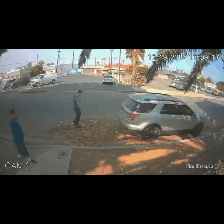

In [47]:
# Create initial states for the stream model
init_states_fn = inference_model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, 224, 224, 3])))

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states



video = TEST.skip(0).take(1)

frames = video_inference(video, states, inference_model)

to_gif(frames[0].numpy())

## Animating the predictions over time

In [48]:
# Get top_k labels and probabilities predicted using MoViNets streaming model
def get_top_k_streaming_labels(probs, k=2, label_map=CLASSES):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  # Sort predictions to find top_k
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  # find unique indices of categories
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  # decode the top_k labels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx



# Plot top_k predictions at a given time step
def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
    
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  # find number of top_k labels and frames in the video
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames
  # Visualize frames and top_k probabilities of streaming video
  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])
  # display the frame
  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')
  # x-axis (frame number)
  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  # y-axis (top_k probabilities)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image

# Plotting top_k predictions from MoViNets streaming model
def plot_streaming_top_preds(
    probs,
    video,
    top_k=2,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
    
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  # select number of frames per second
  #video_fps = 8.
  # select height of the image
  figure_height = 500
  # number of time steps of the given video
  steps = video.shape[0]
  # estimate duration of the video (in seconds)
  duration = steps / video_fps
  # estimate top_k probabilities and corresponding labels
  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm(range(steps)) if use_progbar else range(steps)
  for i in step_generator:
    image = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

    

In [49]:
# Read and process a video
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor.

  Use images resized to match what's expected by your model.
  The model pages say the "A2" models expect 224 x 224 images at 5 fps

  Args:
    file_path: path to the location of a gif file.
    image_size: a tuple of target size.

  Returns:
    a video of the gif file
  """
  # Load a gif file, convert it to a TF tensor
  raw = tf.io.read_file(file_path)
  video = tf.io.decode_gif(raw)
  # Resize the video
  video = tf.image.resize(video, image_size)
  # change dtype to a float32
  # Hub models always want images normalized to [0,1]
  # ref: https://www.tensorflow.org/hub/common_signatures/images#input
  video = tf.cast(video, tf.float32) / 255.
  return video

In [50]:
def streaming_inference(video, states, inference_model):
    """
    Perform streaming inference on a video using our pre-trained model.

    Args:
        video (tf.Tensor): Video frames to perform inference on.
        states (dict): Initial states for the model.

    Returns:
        tf.Tensor: Probabilities estimated by the model.
    """
    images = tf.split(video[tf.newaxis], video.shape[0], axis=1)
    all_logits = []
    
    # To run on a video, pass in one frame at a time
    states = init_states
    for image in images:
      # predictions for each frame
      logits, states = inference_model({**states, 'image': image})
      all_logits.append(logits)
    
    # concatenating all the logits
    logits = tf.concat(all_logits, 0)
    # estimating probabilities
    probs = tf.nn.softmax(logits, axis=-1)

    final_probs = probs[-1]
    print('Top_k predictions and their probabilities\n')
    for label, p in get_top_k(final_probs):
        print(f'{label:20s}: {p:.3f}')

    return probs
        

In [51]:

#video_path = "./test_videos/boxing_2.1.mp4"
video_path = "./datasets/RWF-2000/RWF-2000/train/No_Fight/HW48LUZKOL4_3.avi" #Violence, then normal IMPORTANT
video_path = "./datasets/RWF-2000/RWF-2000/train/Fight/1tU4kxa51vw_1.avi"
video_path = "./test_videos/videos/test2.mp4"

#video_path = "./final_data_NoVioPeru/No_Fight/1A3zEkCHBl8_1.avi" # Just running & Playing

#video_path = "./final_data_NoVioPeru/Fight/aKK0B4kpKZA_1.avi" 


sample_video = frames_from_video_file(video_path, n_frames = 50)
print(sample_video.shape)

#gif_path = "./test_videos/gifs/boxing_2.1.gif"
#gif_path = "./test_videos/gifs/no_fight.gif"

gif_path = "./test_videos/gifs/aKK0B4kpKZA_1.gif"
gif_path = "./test_videos/gifs/test2.gif"

to_gif(sample_video, gif_path)


#gif_path = './animation.gif'

gif=load_gif(gif_path)
gif.shape

states = inference_model.init_states(gif[tf.newaxis].shape)

probs = streaming_inference(gif, states, inference_model)


(50, 224, 224, 3)
Top_k predictions and their probabilities

Fight               : 0.929
No_Fight            : 0.071


In [52]:
# Generate a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, gif, video_fps=60.)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.56it/s]


In [53]:
# For gif format, set codec='gif'
media.show_video(plot_video, fps=2)

# Download a zip with all the weights and data

In [56]:
import os
import zipfile

def zip_folders(folder_paths, output_zip_path):
    """
    Create a zip file containing all files from a list of specified folders.

    Parameters:
    - folder_paths (list of str): List of paths to folders whose contents should be zipped.
    - output_zip_path (str): Path where the output zip file should be saved.
    
    Returns:
    - None
    """
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for folder_path in folder_paths:
            if not os.path.exists(folder_path):
                print(f"Folder {folder_path} does not exist. Skipping...")
                continue
            for root, _, files in os.walk(folder_path):
                for file in files:
                    # Get absolute path of the file
                    file_path = os.path.join(root, file)
                    # Create a relative path to maintain the folder structure in the zip
                    relative_path = os.path.relpath(file_path, os.path.commonpath(folder_paths))
                    zipf.write(file_path, relative_path)
                    
def zip_selected_folders(root_path, output_zip_path):
    """
    Zip folders from a specified root directory that start with certain prefixes into a zip file.

    Parameters:
    - root_path (str): Path to the root directory to search for folders.
    - output_zip_path (str): Path where the output zip file should be saved.

    Returns:
    - None
    """
    # Define prefixes of the folders to be zipped
    valid_prefixes = ("conf_matrix", "trained_models", "notebook", "train_data","Movinet" )
    
    # Collect all relevant folders that start with the valid prefixes
    folders_to_zip = [
        os.path.join(root_path, folder) for folder in os.listdir(root_path)
        if os.path.isdir(os.path.join(root_path, folder)) and folder.startswith(valid_prefixes)
    ]
    print(f'Folders in ZIP:{folders_to_zip}')
    # Use the previously defined function to zip the collected folders
    zip_folders(folders_to_zip, output_zip_path)

root_path = './'
zip_file_name = './TFG.zip'

zip_selected_folders(root_path,zip_file_name)

Folders in ZIP:['./conf_matrix__dropout_autolr_trlayers_NoAugVioPeru', './train_data_dropout_autolr_trlayers_NoAug', './trained_models_dropout_autolr_trlayers_NoAug', './train_data_dropout_autolr_trlayers_NoVioPeru', './conf_matrix__dropout_autolr_trlayers_NoAug', './notebooks_history', './conf_matrix__dropout_autolr_trlayers_NoVioPeru', './trained_models_dropout_autolr_trlayers_NoAugVioPeru', './notebooks_test', './train_data_dropout_autolr_trlayers_NoAugVioPeru', './train_data_dropout_autolr_trlayers_NoVioPeru_NoAug', './trained_models_dropout_autolr_trlayers', './train_data_dropout_autolr_trlayers', './conf_matrix__dropout_autolr_trlayers', './trained_models_dropout_autolr_trlayers_NoVioPeru', './trained_models_dropout_autolr_trlayers_NoVioPeru_NoAug', './conf_matrix__dropout_autolr_trlayers_NoVioPeru_NoAug']
